# Wong–Wang full model (Numba implementation)

This notebook demonstrates simulation and likelihood-free inference for the Wong–Wang full (including excitatory and inhibitory population) neuronal-mass model using the Numba‑accelerated `WW_sde` implementation from the `vbi` package.

Colab:
<a href="https://colab.research.google.com/github/Ziaeemehr/vbi_paper/blob/main/docs/examples/ww_full_sde_numba_cde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Contents:

- Simulate the Wong–Wang network and generate synthetic BOLD signals with `WW_sde`.
- Extract features (FC, FCD) and build training data.
- Train a Masked Autoregressive Flow (MAF) density estimator using `vbi.cde` and compute posterior summaries.

Notes:

- Does not require PyTorch or `sbi`; suitable for low‑memory devices and platforms.

Requirements: Python 3.10+, `vbi`, `numba`, `numpy`, `pandas`, `matplotlib`, `tqdm`. See the project README for setup details.

In [ ]:
# Install VBI package in Google Colab (lightweight, CPU-only version)
print("Setting up VBI for Google Colab...")

# Skip C++ compilation for faster installation in Colab
%env SKIP_CPP=1

print("Environment configured.")

In [ ]:
# Install the package
# !pip install vbi

In [ ]:
print("VBI package installed successfully! Ready to proceed.")

#### Imports & Global Config

In [ ]:
import os
import warnings
from copy import deepcopy
import multiprocessing as mp
from multiprocessing import Pool

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
import vbi
from vbi.models.numba.ww import WW_sde
from vbi.cde import MAFEstimator
from vbi.feature_extraction.features_utils import get_fcd
from vbi import (
    extract_features,
    get_features_by_domain,
    get_features_by_given_names,
    update_cfg,
    report_cfg
)
from vbi.utils import BoxUniform
from vbi.utils import posterior_shrinkage_numpy, posterior_zscore_numpy
import autograd.numpy as anp

In [ ]:
warnings.simplefilter("ignore")

In [ ]:
SEED = 42
np.random.seed(SEED)

In [ ]:
LABELSIZE = 10
plt.rcParams["axes.labelsize"] = LABELSIZE
plt.rcParams["xtick.labelsize"] = LABELSIZE
plt.rcParams["ytick.labelsize"] = LABELSIZE

In [ ]:
OUT_DIR = "output/ww_full_numba_cde_/"
os.makedirs(OUT_DIR, exist_ok=True)

If True: load data/features/sims from disk when present; otherwise (re)generate.

In [ ]:
LOAD_DATA = True
N_WORKERS = mp.cpu_count()

#### Simulation Helpers

In [ ]:
def simulate_once_ww(par: dict,
                     G_exc_value: float | None = None,
                     feat_cfg=None,
                     return_features: bool = False):
    """
    Run one WW_sde simulation.
    Parameters
    ----------
    par : dict
        Model parameter dictionary for WW_sde.
    G_exc_value : float or None
        If provided, overrides the excitatory global coupling during this run.
    feat_cfg : object
        Feature-extraction config (from vbi) when return_features=True.
    return_features : bool
        If True, extract features from BOLD and return (values, labels).
    Returns
    -------
    If return_features:
        (values, labels)
    elif par["RECORD_S"]:
        (S_t, S_d, bold_t, bold_d)
    else:
        (bold_t, bold_d)
    """
    run_par = deepcopy(par)
    sde = WW_sde(run_par)
    ctrl = {}
    if G_exc_value is not None:
        ctrl["G_exc"] = float(G_exc_value)
    data = sde.run(ctrl)
    S_t = data["t"]
    S_d = data["S"]
    bold_t = data["bold_t"]
    bold_d = data["bold_d"]
    if return_features:
        # BOLD sampling rate (Hz): TR is in ms
        fs_bold = 1000.0 / run_par["tr"]
        stat = extract_features([bold_d.T], fs_bold, feat_cfg,
                                n_workers=1, output_type="dataframe", verbose=False)
        return stat.values, stat.columns.to_list()
    if run_par.get("RECORD_S", False):
        return S_t, S_d, bold_t, bold_d
    else:
        return bold_t, bold_d

In [ ]:
def simulate_batch_ww(par: dict, G_exc_values, feat_cfg, n_workers: int = 1):
    """
    Parallel batch of WW simulations returning feature vectors.
    Parameters
    ----------
    par : dict
        Base parameter dictionary (RECORD_S not required for features).
    G_exc_values : array-like
        Sequence of G_exc values per run.
    feat_cfg : object
        Feature-extraction config.
    n_workers : int
        Number of parallel workers.
    Returns
    -------
    list[np.ndarray]
        Each item is the feature vector for one simulation.
    """
    vals = list(np.asarray(G_exc_values).reshape(-1))
    def _update(_):
        pbar.update()
    with Pool(processes=n_workers) as pool:
        with tqdm(total=len(vals), desc="Simulating (features)") as pbar:
            async_res = [
                pool.apply_async(
                    simulate_once_ww,
                    args=(par, g, feat_cfg, True),
                    callback=_update,
                )
                for g in vals
            ]
            feat_list = [res.get()[0] for res in async_res]
    return feat_list

In [ ]:
def plot_overview(bold_t_ms: np.ndarray, bold_d: np.ndarray, TR_ms: float, win_len: int = 30):
    """
    Quick overview: BOLD timeseries and FCD matrix.
    Parameters
    ----------
    bold_t_ms : 1D array
        BOLD time in ms.
    bold_d : 2D array
        BOLD data (T, N).
    TR_ms : float
        Repetition time in ms.
    win_len : int
        Window length (in samples of BOLD, not seconds) for FCD computation.
    """
    TR_s = TR_ms / 1000.0
    fcd = get_fcd(bold_d.T, win_len=win_len, TR=TR_s)["full"]
    plt.figure(figsize=(10, 3.6))
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(bold_t_ms / 1000.0, bold_d, lw=0.8, alpha=0.25)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("BOLD")
    ax1.margins(x=0, y=0.02)
    ax2 = plt.subplot(1, 2, 2)
    im = ax2.imshow(fcd, cmap="viridis", aspect="equal")
    plt.colorbar(im, ax=ax2)
    ax2.set_title("FCD")
    ax2.set_xlabel("Time window")
    ax2.set_ylabel("Time window")
    plt.tight_layout()
    plt.show()

#### Feature Configuration

In [ ]:
feat_cfg = get_features_by_domain("connectivity")
feat_cfg = get_features_by_given_names(feat_cfg, ["fcd_stat"])
feat_cfg = update_cfg(feat_cfg, "fcd_stat", parameters={"k": None, "win_len": 30, "TR": 0.3})
report_cfg(feat_cfg)

Selected features:
------------------
■ Domain: connectivity
 ▢ Function:  fcd_stat
   ▫ description:  Extracts features from dynamic functional connectivity (FCD)
   ▫ function   :  vbi.feature_extraction.features.fcd_stat
   ▫ parameters :  {'TR': 0.3, 'win_len': 30, 'positive': False, 'eigenvalues': True, 'masks': None, 'verbose': False, 'pca_num_components': 3, 'quantiles': [0.05, 0.25, 0.5, 0.75, 0.95], 'k': None, 'features': ['sum', 'max', 'min', 'mean', 'std', 'skew', 'kurtosis']}
   ▫ tag        :  ['fmri', 'eeg', 'meg']
   ▫ use        :  yes


#### Connectome & Base Parameters

In [ ]:
D = vbi.LoadSample(nn=84)
W = D.get_weights()
N_NODES = W.shape[0]
print(f"number of nodes: {N_NODES}")

number of nodes: 84


Ground truth for observation (estimate G_exc)

In [ ]:
theta_true = [1.90]  # change here if desired

In [ ]:
par_obs = dict(
    weights=W,
    nn=N_NODES,
    dt=2.5,                 # ms
    t_end=5 * 60 * 1000.0,  # ms
    t_cut=1 * 60 * 1000.0,  # ms
    G_exc=theta_true[0],
    G_inh=0.0,
    sigma=0.05,
    ext_current=0.05,
    RECORD_S=True,
    s_decimate=10,
    tr=300.0,               # ms
    seed=SEED,
)

#### Generate / Load Observation (controlled by LOAD_DATA)

In [ ]:
OBS_NPZ = f"{OUT_DIR}/data_obs.npz"
OBS_CSV = f"{OUT_DIR}/df_obs.csv"

In [ ]:
need_gen_obs = not LOAD_DATA or not (os.path.exists(OBS_NPZ) and os.path.exists(OBS_CSV))

In [ ]:
if need_gen_obs:
    S_t, S_d, bold_t, bold_d = simulate_once_ww(par_obs)
    # BOLD features for the observation
    fs_bold = 1000.0 / par_obs["tr"]
    df_obs = extract_features([bold_d.T], fs_bold, feat_cfg,
                              n_workers=1, output_type="dataframe", verbose=False)
    df_obs.to_csv(OBS_CSV, index=False)
    np.savez(OBS_NPZ, S_t=S_t, S_d=S_d, bold_t=bold_t, bold_d=bold_d, theta=theta_true)
else:
    data = np.load(OBS_NPZ)
    S_t, S_d, bold_t, bold_d = data["S_t"], data["S_d"], data["bold_t"], data["bold_d"]
    theta_true = data["theta"].tolist()
    df_obs = pd.read_csv(OBS_CSV)

In [ ]:
print("Shapes:", S_t.shape, S_d.shape, bold_t.shape, bold_d.shape)

Shapes: (9599,) (9599, 84) (799,) (799, 84)


#### Visualize Observation: BOLD & FCD

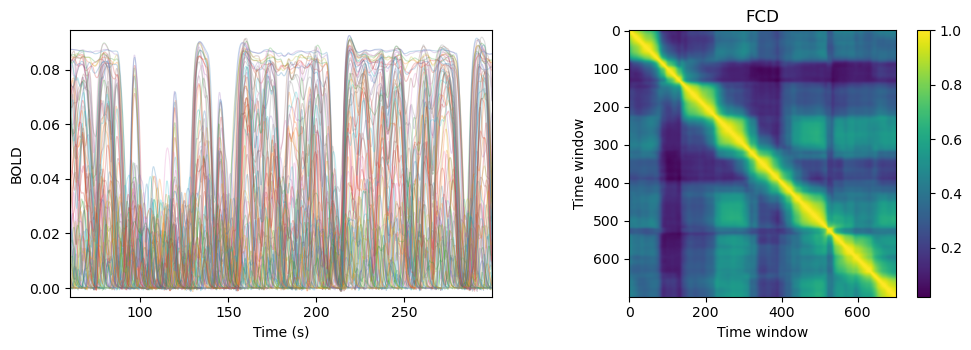

In [ ]:
plot_overview(bold_t, bold_d, TR_ms=par_obs["tr"], win_len=30)

#### Prior & Training Simulations (generate or load)

Prior over G_exc

In [ ]:
NUM_SIM = 200
G_MIN, G_MAX = 0.0, 2.5
prior_min = [G_MIN]
prior_max = [G_MAX]
prior = BoxUniform(low=prior_min, high=prior_max)
theta = prior.sample((NUM_SIM,), seed=SEED)   # shape: (NUM_SIM, 1)
G_exc_samples = theta[:, 0].squeeze()

Base params for training sims (we override G_exc per run)

In [ ]:
par_train = dict(
    weights=W,
    nn=N_NODES,
    dt=2.5,                 # ms
    t_end=5 * 60 * 1000.0,  # ms
    t_cut=1 * 60 * 1000.0,  # ms
    G_exc=0.0,              # overridden per run
    G_inh=0.0,
    sigma=0.05,
    ext_current=0.05,
    RECORD_S=False,
    s_decimate=10,
    tr=300.0,               # ms
    seed=SEED,
)

In [ ]:
TRAIN_NPZ = f"{OUT_DIR}/training_data.npz"
MASK_CSV  = f"{OUT_DIR}/remained_columns.csv"
X_PKL     = f"{OUT_DIR}/dataframe_X.pkl"

In [ ]:
need_gen_train = not LOAD_DATA or not (os.path.exists(TRAIN_NPZ) and os.path.exists(MASK_CSV) and os.path.exists(X_PKL))

In [ ]:
if need_gen_train:
    # Parallel feature extraction across prior samples
    feats_list = simulate_batch_ww(par_train, G_exc_samples, feat_cfg, n_workers=N_WORKERS)

    # Build DataFrame with same columns as obs features
    X_df = pd.DataFrame(np.array(feats_list).squeeze(), columns=df_obs.columns)
    X_df.to_pickle(X_PKL)

    # Keep only informative (non-near-constant) features
    keep_mask = (X_df.std() > 1e-5)
    X_df_keep = X_df.loc[:, keep_mask]
    X = X_df_keep.values.astype(np.float32)
    np.savez(TRAIN_NPZ, x=X, theta=theta)
    keep_mask.to_csv(MASK_CSV, header=["keep"], index=False)
else:
    data = np.load(TRAIN_NPZ)
    X = data["x"]
    theta = data["theta"]
    keep_mask = pd.read_csv(MASK_CSV)["keep"].astype(bool).values
    X_df = pd.read_pickle(X_PKL)

Simulating (features): 100%|██████████| 200/200 [01:53<00:00,  1.77it/s]


In [ ]:
print("X shape:", X.shape, "theta shape:", theta.shape)

X shape: (200, 22) theta shape: (200, 1)


#### Feature–Parameter Scatter (Quick Diagnostic)

In [ ]:
cols_kept = df_obs.columns[keep_mask]
n_features = len(cols_kept)

In [ ]:
n_cols = min(5, n_features)
n_rows = int(np.ceil(min(15, n_features) / n_cols))
sel = min(15, n_features)

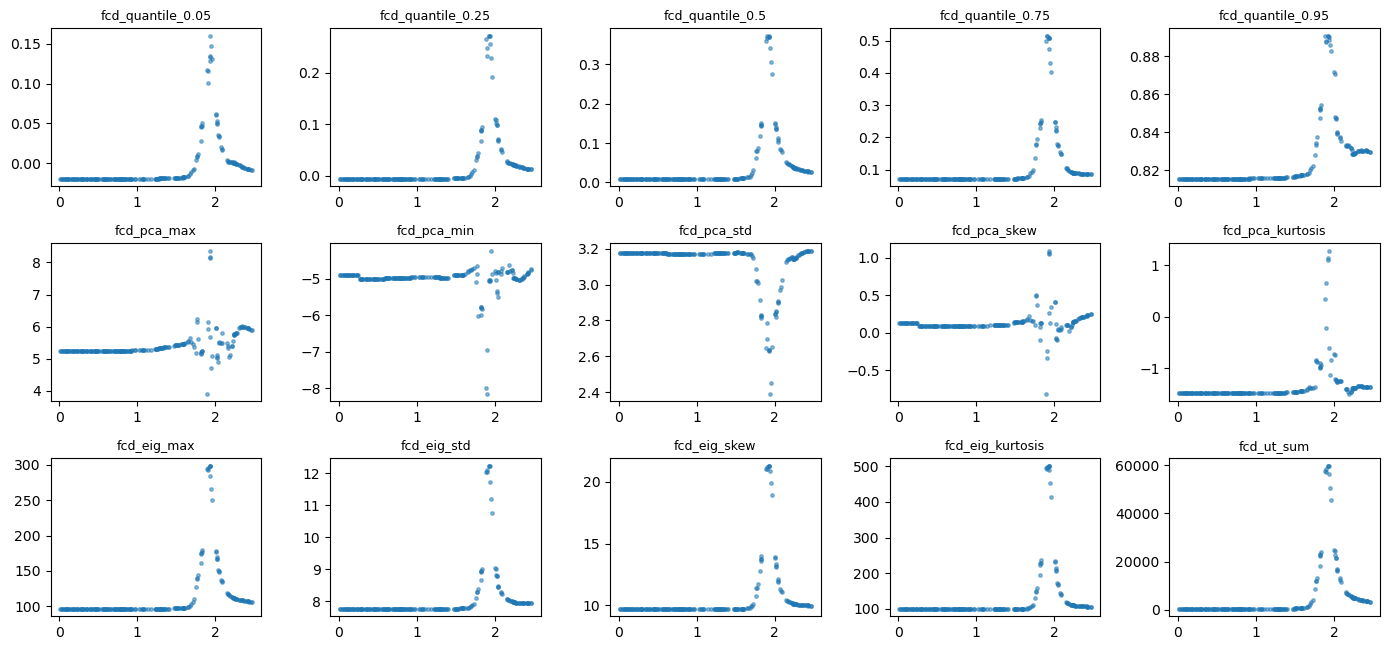

In [ ]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.8*n_cols, 2.2*n_rows))
axes = np.atleast_2d(axes)

for k in range(sel):
    i, j = divmod(k, n_cols)
    ax = axes[i, j]
    ax.scatter(theta, X[:, k], s=6, alpha=0.5)
    ax.set_title(cols_kept[k].replace("full_", ""), fontsize=9)

# Hide any unused axes
for k in range(sel, n_rows*n_cols):
    i, j = divmod(k, n_cols)
    axes[i, j].axis("off")

plt.tight_layout()
plt.show()


#### Build Observation Feature Vector (xo)

In [ ]:
xo = df_obs.loc[:, cols_kept].values.astype(np.float32)
print("xo shape:", xo.shape, "| theta:", theta.shape, "| X:", X.shape)

xo shape: (1, 22) | theta: (200, 1) | X: (200, 22)


#### Train Density Estimator (MAF) & Posterior Summary

In [ ]:
rng = anp.random.RandomState(SEED)
maf = MAFEstimator(n_flows=4, hidden_units=64)

Option: limit to first two features for stability (mirrors your original script)

In [ ]:
X_train = X[:, :2]
xo_use = xo[:, :2]

In [ ]:
maf.train(theta.astype(np.float32), X_train.astype(np.float32), n_iter=500, learning_rate=2e-4)

Inferred dimensions: param_dim=1, feature_dim=2


Training: 100%|██████████| 500/500 [00:07<00:00, 67.23it/s, patience=0/20, train=0.9182, val=1.0682] 


In [ ]:
samples = maf.sample(xo_use, n_samples=5000, rng=rng)[0]
shrinkage = posterior_shrinkage_numpy(theta, samples)
zscore = posterior_zscore_numpy(theta_true, samples)

In [ ]:
print("True parameters:     ", theta_true)
print("MAF mean estimate:   ", np.mean(samples, axis=0))
print("Posterior shrinkage: ", np.array2string(shrinkage, precision=3, separator=", "))
print("Posterior z-score:   ", np.array2string(zscore, precision=3, separator=", "))

True parameters:      [1.9]
MAF mean estimate:    [1.9301355]
Posterior shrinkage:  [0.999]
Posterior z-score:    [1.596]


In [ ]:
np.savez(f"{OUT_DIR}/samples.npz", samples=samples, xo=xo, theta_true=theta_true)

#### Posterior Plot

In [ ]:
from vbi.plot import pairplot_numpy

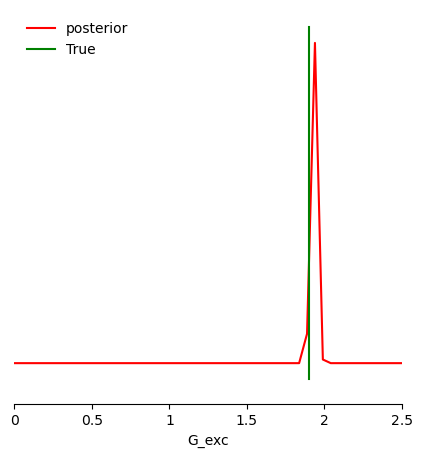

In [ ]:
limits = [[lo, hi] for lo, hi in zip(prior_min, prior_max)]
fig, ax = pairplot_numpy(
    samples,
    limits=limits,
    figsize=(5, 5),
    points=np.array(theta_true).reshape(1, -1),
    labels=["G_exc"],
    offdiag="kde",
    diag="kde",
    fig_kwargs=dict(points_offdiag=dict(marker="*", markersize=10), points_colors=["g"]),
    diag_kwargs={"mpl_kwargs": {"color": "r"}},
)
plt.legend(["posterior", "True"], loc="upper left", fontsize=10, frameon=False)
fig.savefig(f"{OUT_DIR}/G_exc_posterior.png", dpi=150)

✓ Numba available - using JIT compilation for speedup
DoDy MODEL SIMULATION - CORRECTED VERSION v7 (Google Colab)

DATA DIRECTORY: /content

Required files in /content/:
  - conn_dopamine.npy
  - conn_excitator.npy
  - conn_inhibitor.npy
  - L6_regions2channels_abs_sum.npy

CORRECTIONS APPLIED:
  1. Binarization: z > 1.5 (positive threshold only, NOT |z|)
  2. Leadfield: Precomputed L6_regions2channels_abs_sum.npy
  3. STN indices: 42 (LH), 45 (RH)
  4. Cortical regions: 0-33 (LH), 51-84 (RH) *** FIXED FROM 52-85 ***
  5. ATM: Average across avalanches, then symmetrize
  6. EEG SIGNALS: Uses FIRING RATE (r) for leadfield projection
  7. STN SIGNALS: Uses MEMBRANE POTENTIAL (V) directly
  8. RANDOM SEED: Same seed (42) for all w_dopa simulations
  9. ELECTRODE ORDER: ['F3', 'C3', 'F4', 'C4', 'Fz', 'Cz', 'STN-lh', 'STN-rh']
 10. Numba JIT: Enabled
 11. Leadfield ordering: RH first, then LH

v7 FIX: Right hemisphere cortical indices corrected
  OLD (WRONG): 52-85 → included R.CER (cerebel

/tmp/ipython-input-2601548538.py:916: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])
/tmp/ipython-input-2601548538.py:916: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


  Saved: /content/figure3_corrected_v7.png


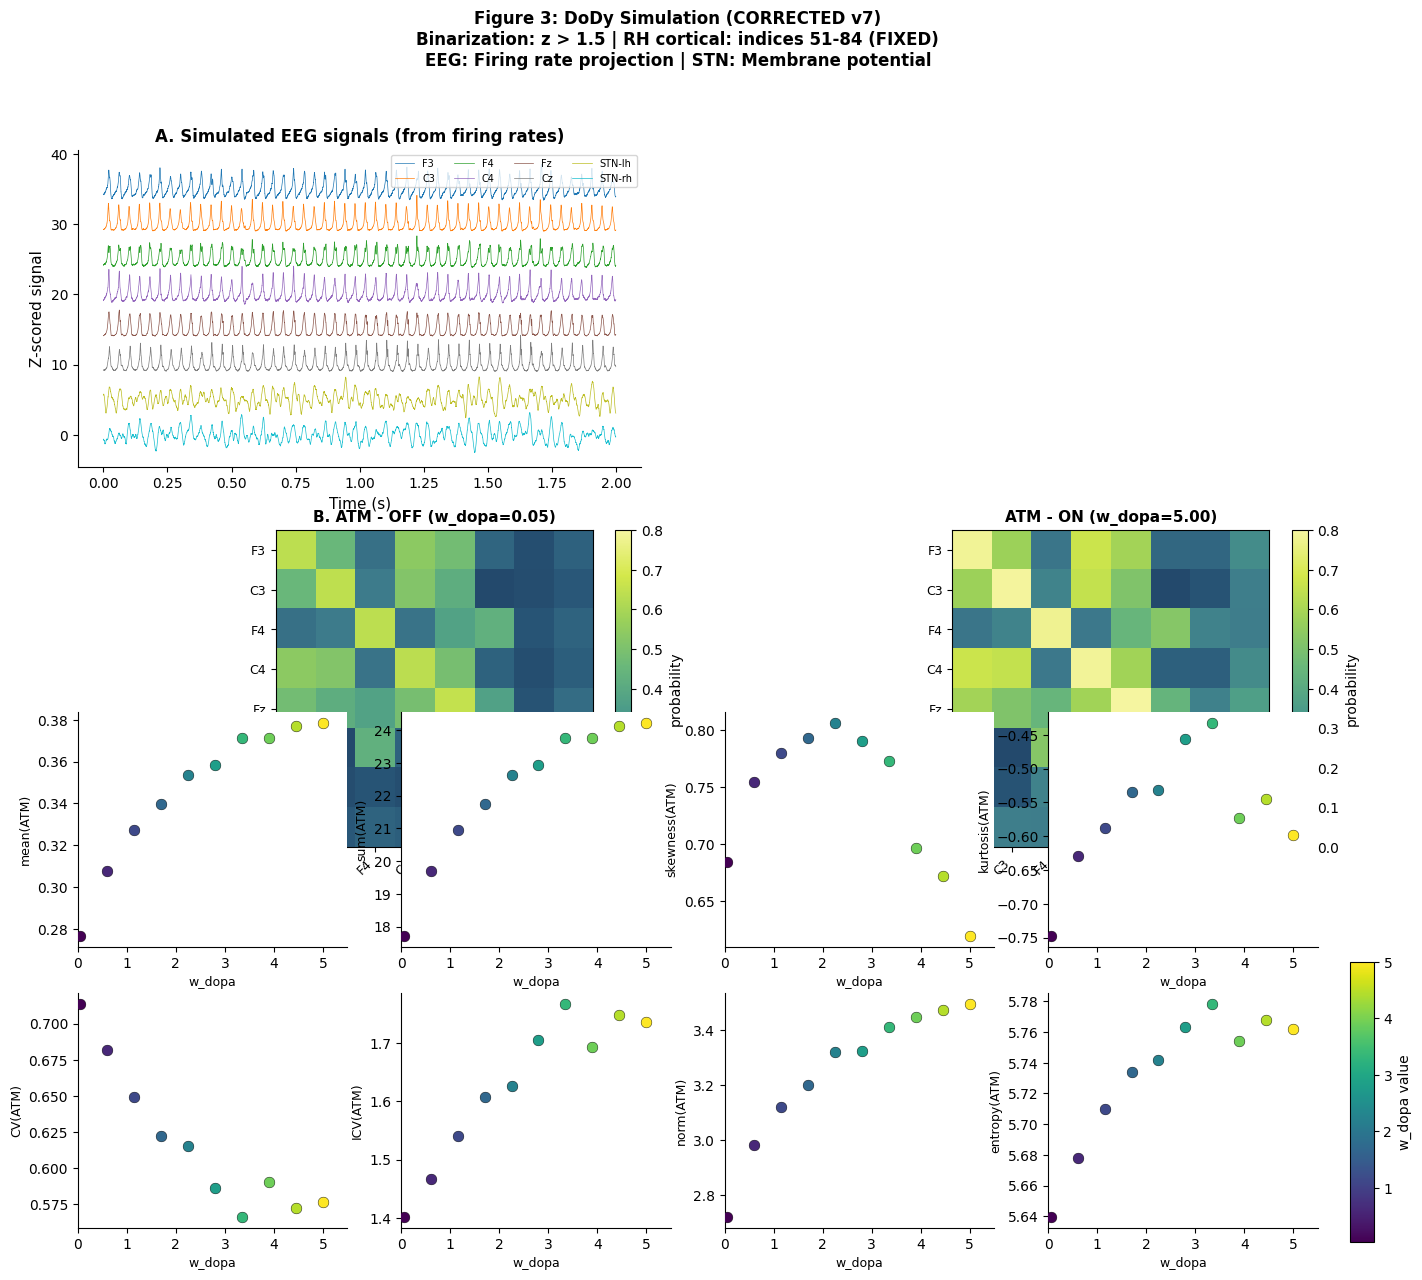

/tmp/ipython-input-2601548538.py:963: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


  Saved: /content/figure3c_features_corrected_v7.png


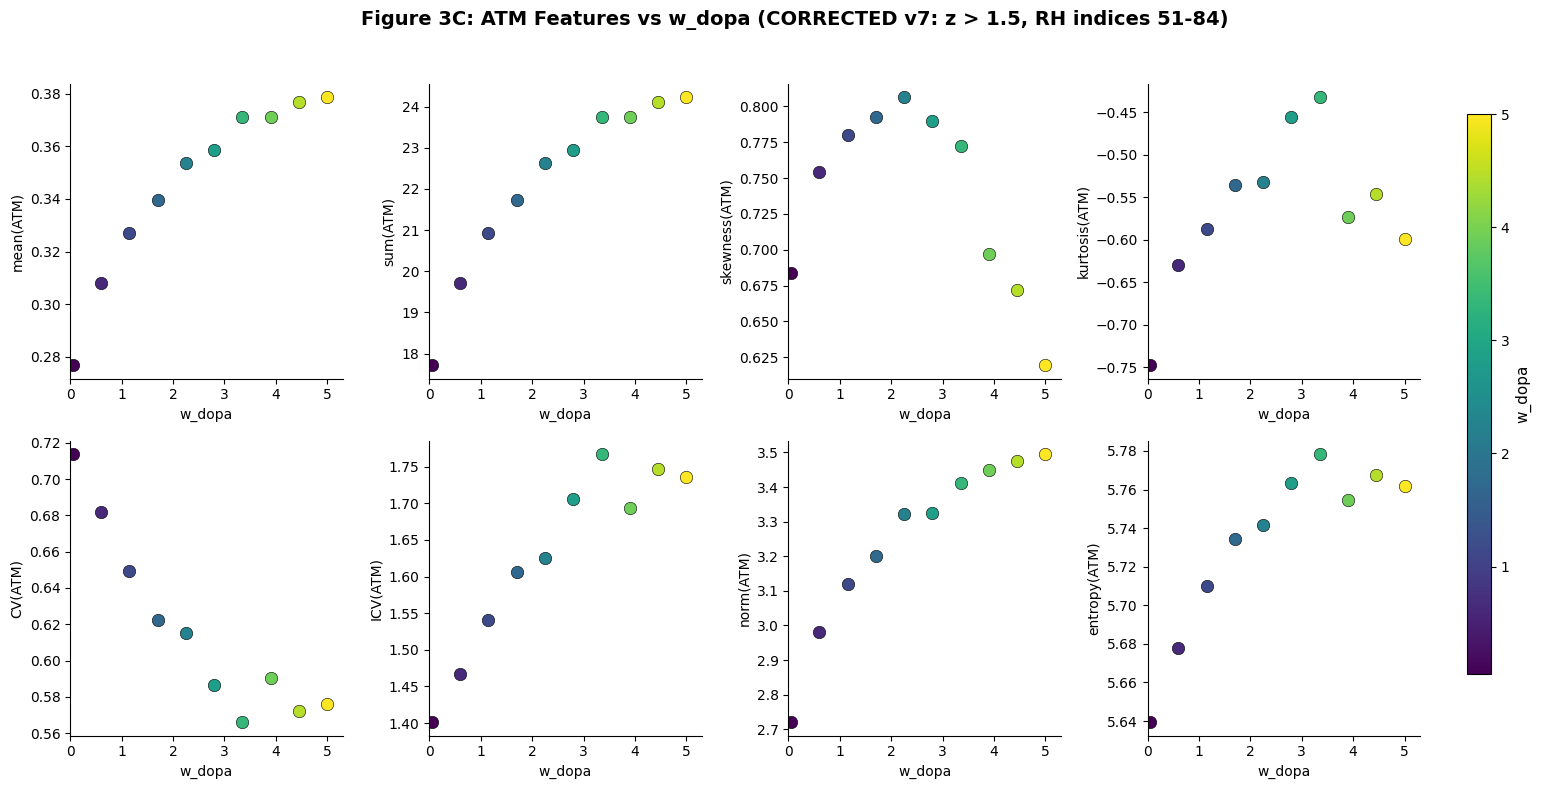

  Saved: /content/atm_progression_corrected_v7.png


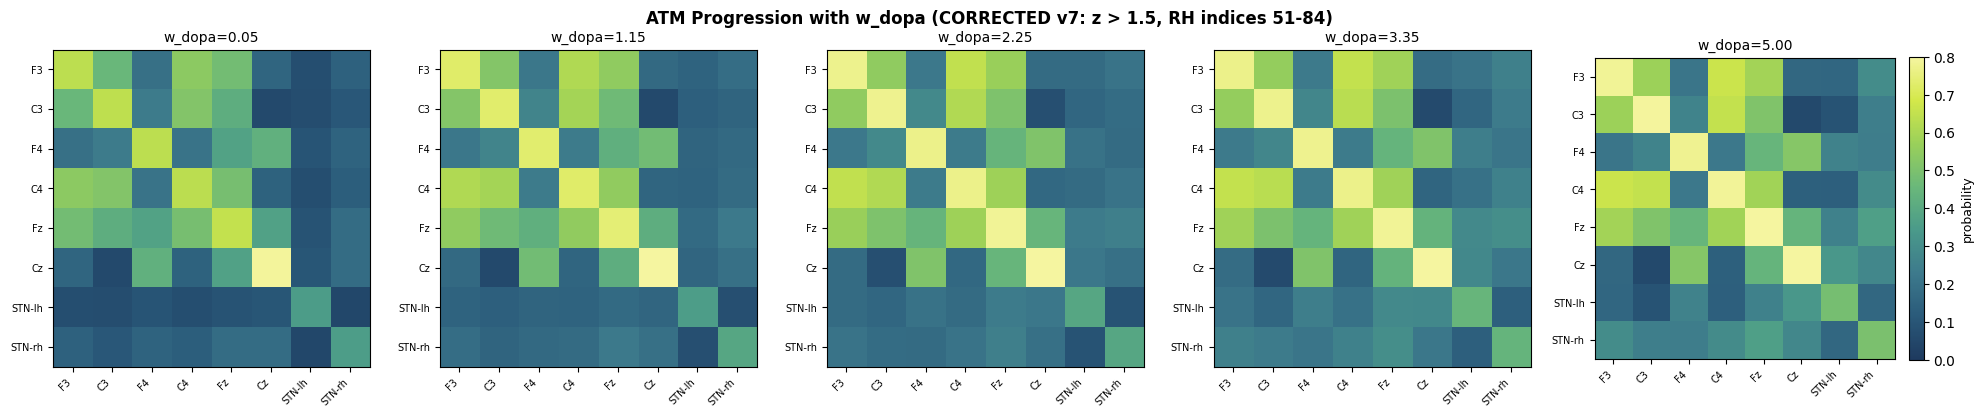


SIMULATION COMPLETE

Results Summary (Figure 3C features):
------------------------------------------------------------------------------------------
w_dopa     n_aval   mean       sum        skew       kurt       CV         ICV       
------------------------------------------------------------------------------------------
0.05       1103     0.2768     17.7146    0.6840     -0.7475    0.7136     1.4013    
0.60       1012     0.3079     19.7033    0.7545     -0.6296    0.6818     1.4667    
1.15       973      0.3271     20.9368    0.7799     -0.5874    0.6494     1.5400    
1.70       955      0.3396     21.7314    0.7928     -0.5350    0.6224     1.6068    
2.25       911      0.3537     22.6355    0.8063     -0.5314    0.6153     1.6253    
2.80       930      0.3586     22.9502    0.7899     -0.4556    0.5863     1.7056    
3.35       916      0.3711     23.7495    0.7725     -0.4322    0.5660     1.7668    
3.90       902      0.3713     23.7610    0.6968     -0.5733    0.5904

In [9]:
"""
===============================================================================
DoDy Model Simulation - CORRECTED VERSION v7 (Google Colab Version)
===============================================================================
Based on Angiolelli et al. 2025 - "The Virtual Parkinsonian Patient"
npj Systems Biology and Applications (2025) 11:40

MODIFICATIONS FOR GOOGLE COLAB:
================================
- Changed LOCAL_ROOT to /content/ for Colab storage
- All connectivity and leadfield matrices should be uploaded to /content/

CORRECTIONS APPLIED:
=======================
1. Binarization: z > θ (positive threshold only, NOT absolute value)
   - Paper page 3: "set to 1 for z > 1.5, and to 0 otherwise"
2. Leadfield: Uses PRECOMPUTED leadfield matrix (L6_regions2channels_abs_sum.npy)
3. STN indices: 42 (left) and 45 (right) as per notebook
4. Cortical regions: 0-33 (LH) and 51-84 (RH) for leadfield projection
   *** FIXED in v7: Was incorrectly 52-85 in v6 ***
5. ATM computation: Average across avalanches, then symmetrize
6. EEG SIGNALS: Uses FIRING RATE (r) for leadfield projection, NOT membrane potential
   - Paper page 9: "the firing rates of individual brain regions are translated
     to the positions of the six considered electrodes using the lead field matrix"
7. STN SIGNALS: Uses membrane potential (V) directly
   - Paper page 3: "As per the subthalamic nuclei (STN), the simulated voltages
     are compared directly"
8. RANDOM SEED: Same seed used for all w_dopa simulations for consistency
9. ELECTRODE ORDER: Matches paper Figure 3B exactly: F3, C3, F4, C4, Fz, Cz, STN-lh, STN-rh
10. THRESHOLD: θ = 1.5 as per paper page 3
11. CORTICAL ORDER: RH first, then LH to match leadfield matrix

v7 CRITICAL FIX:
================
Right hemisphere cortical regions were incorrectly indexed as 52-85 in v6.
The atlas shows RH cortical regions are indices 51-84:
- Index 51: R.BSTS (first RH cortical) - was MISSING in v6
- Index 85: R.CER (RIGHT CEREBELLUM) - was incorrectly included in v6

This caused C4 and F4 electrodes to receive cerebellar activity instead of
the correct cortical sources, explaining the abnormal signals.

===============================================================================
"""

import numpy as np
from scipy.stats import zscore, skew, kurtosis
from scipy.signal import detrend
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib import cm
import os
import warnings
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing

# Try to import numba for JIT compilation
try:
    from numba import jit, prange
    NUMBA_AVAILABLE = True
    print("✓ Numba available - using JIT compilation for speedup")
except ImportError:
    NUMBA_AVAILABLE = False
    print("⚠ Numba not available - running without JIT (slower)")
    def jit(*args, **kwargs):
        def decorator(func):
            return func
        return decorator
    prange = range

# =============================================================================
# CONFIGURATION - MODIFIED FOR GOOGLE COLAB
# =============================================================================
# Google Colab storage path
LOCAL_ROOT = "/content"

# Connectivity matrices (upload these to /content/ in Colab)
CONN_DOPAMINE_PATH = os.path.join(LOCAL_ROOT, "conn_dopamine.npy")
CONN_EXCITATOR_PATH = os.path.join(LOCAL_ROOT, "conn_excitator.npy")
CONN_INHIBITOR_PATH = os.path.join(LOCAL_ROOT, "conn_inhibitor.npy")

# PRECOMPUTED LEADFIELD MATRIX (upload to /content/ in Colab)
LEADFIELD_PATH = os.path.join(LOCAL_ROOT, "L6_regions2channels_abs_sum.npy")

OUTPUT_DIR = LOCAL_ROOT
RANDOM_SEED = 42

# =============================================================================
# MODEL PARAMETERS (Table S1 from paper)
# =============================================================================
a = 0.04          # [1/ms·mV]
b = 5.0           # [1/ms]
c = 140.0         # [mV/ms]
Delta = 1.0       # [mV] - Width parameter
Eta = 18.0        # [mV/ms] - Excitability parameter
Iext = 0.0        # [mV/ms]

# Synaptic parameters
ga = 12.0         # [1/ms]
gg = 12.0         # [1/ms]
Ea = 0.0          # [mV]
Eg = -80.0        # [mV]
tauSa = 5.0       # [ms]
tauSg = 5.0       # [ms]
Sja = 0.8         # [-]
Sjg = 1.2         # [-]
Ja = 0.0          # Local recurrent

# Adaptation parameters
alpha = 0.013     # [1/ms]
beta = 0.4        # [-]
ud = 12.0         # [1/ms]

# Dopamine dynamics (Eq. 6)
k = 10e4          # [1/ms]
Vmax = 1300.0     # [nM/ms]
Km = 50.0         # [nM]
Bd = 0.2          # [-] - Baseline dopamine effect (B_Dp in paper)
Ad = 1.0          # [-] - Dopamine modulation strength (A_Dp in paper)
tau_Dp = 500.0    # [ms]

# =============================================================================
# SIMULATION PARAMETERS
# =============================================================================
SIMULATION_TIME = 30000.0      # 30 seconds in ms
TRANSIENT_TIME = 1000.0        # 1 second transient (paper discards first second)
DT = 0.01                      # Integration step [ms]
SAVE_EVERY = 10                # Save every 10 steps = 0.1 ms resolution

# Noise level for stochastic differential equations
SIGMA = 1e-3

# =============================================================================
# STATE BOUNDS
# =============================================================================
R_MIN, R_MAX = 0.0, 1000.0
V_MIN, V_MAX = -120.0, 60.0
U_MIN, U_MAX = -2000.0, 2000.0
SA_MIN, SA_MAX = 0.0, 20.0
SG_MIN, SG_MAX = 0.0, 20.0
DP_MIN, DP_MAX = 0.0, 2000.0

# =============================================================================
# PARCELLATION AND ELECTRODE CONFIGURATION
# =============================================================================
n_nodes = 88

# CORRECTED in v7: Right hemisphere cortical indices
# Atlas structure (from notebook regions_labels):
#   0-33:  Left cortical (34 regions: L.BSTS to L.IN)
#   34-50: Left subcortical + bilateral BG (L.CER, L.TH, etc., GPe/GPi/STN)
#   51-84: Right cortical (34 regions: R.BSTS to R.IN) *** FIXED ***
#   85:    R.CER (right cerebellum - NOT cortical!)
#   86-87: Substantia Nigra

N_CORTICAL_LH = 34              # Left hemisphere cortical regions: 0-33
N_CORTICAL_LH_START = 0         # Index of first LH cortical region
N_CORTICAL_LH_END = 34          # Python slice end (exclusive)

N_CORTICAL_RH = 34              # Right hemisphere cortical regions: 51-84
N_CORTICAL_RH_START = 51        # FIXED: Was 52 in v6 (missed R.BSTS)
N_CORTICAL_RH_END = 85          # FIXED: Was 86 in v6 (included R.CER)

# STN indices from notebook (compute_LL function)
STN_LH_IDX = 42  # Left STN (lh-STN in atlas)
STN_RH_IDX = 45  # Right STN (rh-STN in atlas)

# EEG channels - ORDER TO MATCH PAPER FIGURE 3B EXACTLY
# Paper page 3: "F3, C3, F4, C4, Fz, and Cz"
EEG_CHANNELS = ['F3', 'C3', 'F4', 'C4', 'Fz', 'Cz']
DEEP_CHANNELS = ['STN-lh', 'STN-rh']
ALL_CHANNELS = EEG_CHANNELS + DEEP_CHANNELS

# =============================================================================
# ATM PARAMETERS - FROM PAPER
# =============================================================================
# Paper page 3: "set to 1 for z > 1.5, and to 0 otherwise"
THETA = 1.5                    # Threshold value z > 1.5
USE_ABSOLUTE_VALUE = False     # Use z > θ (NOT |z| > θ)

# w_dopa range (matching paper Figure 3C)
WDOPA_MIN = 0.05
WDOPA_MAX = 5.0
N_WDOPA_VALUES = 10  # Number of w_dopa values to sweep

# Number of parallel workers
N_WORKERS = min(4, multiprocessing.cpu_count())

# =============================================================================
# ATM COLORMAP - MATCHING PAPER FIGURE 3B EXACTLY
# =============================================================================
def create_paper_atm_colormap():
    """
    Create colormap matching paper Figure 3B exactly.
    Paper uses: dark blue -> teal/cyan -> green -> yellow
    """
    colors = [
        '#1e3a5f',  # Dark blue (low probability)
        '#2a5a7a',  # Blue
        '#3d7a8c',  # Teal
        '#4a9a8a',  # Cyan-green
        '#6ab87a',  # Green
        '#9ad05a',  # Yellow-green
        '#d4e84a',  # Yellow (high probability)
        '#f5f5a0'   # Light yellow
    ]
    return LinearSegmentedColormap.from_list('paper_atm', colors, N=256)

ATM_COLORMAP = create_paper_atm_colormap()
ATM_COLORMAP_NAME = 'paper_atm'


# =============================================================================
# CONNECTIVITY LOADING
# =============================================================================
def load_connectivity_matrices():
    """Load the three connectivity matrices."""
    print("\nLoading connectivity matrices...")

    # Check if files exist
    for path, name in [(CONN_DOPAMINE_PATH, "conn_dopamine.npy"),
                       (CONN_EXCITATOR_PATH, "conn_excitator.npy"),
                       (CONN_INHIBITOR_PATH, "conn_inhibitor.npy")]:
        if not os.path.exists(path):
            raise FileNotFoundError(
                f"File not found: {path}\n"
                f"Please upload {name} to {LOCAL_ROOT}/ in Google Colab.\n"
                f"You can do this by:\n"
                f"  1. Click the folder icon in the left sidebar\n"
                f"  2. Click 'Upload to session storage'\n"
                f"  3. Select your .npy files"
            )

    conn_dopamine = np.load(CONN_DOPAMINE_PATH).T
    conn_excitator = np.load(CONN_EXCITATOR_PATH).T
    conn_inhibitor = np.load(CONN_INHIBITOR_PATH).T

    print(f"  Dopamine: {conn_dopamine.shape}, {np.count_nonzero(conn_dopamine)} connections")
    print(f"  Excitatory: {conn_excitator.shape}, {np.count_nonzero(conn_excitator)} connections")
    print(f"  Inhibitory: {conn_inhibitor.shape}, {np.count_nonzero(conn_inhibitor)} connections")

    return conn_dopamine, conn_excitator, conn_inhibitor


# =============================================================================
# LEADFIELD MATRIX - PRECOMPUTED
# =============================================================================
def load_precomputed_leadfield():
    """
    Load precomputed leadfield matrix from the notebook.

    Paper (page 9):
    "We use the MNE toolbox to fit a standard 10–20 EEG cap onto the skin surface
     of the MNI152 template head... Together with the EEG locations and the BEM
     surfaces, we compute the electric forward problem using the OpenMEEG toolbox."

    The precomputed leadfield matrix L6 maps 68 cortical regions to 6 EEG channels.
    """
    print("\n" + "="*60)
    print("LOADING PRECOMPUTED LEADFIELD MATRIX")
    print("="*60)

    if os.path.exists(LEADFIELD_PATH):
        L = np.load(LEADFIELD_PATH)
        print(f"  Loaded leadfield from: {LEADFIELD_PATH}")
        print(f"  Leadfield shape: {L.shape}")
        print(f"  Leadfield range: [{L.min():.6f}, {L.max():.6f}]")
        print(f"  Non-zero elements: {np.count_nonzero(L)}")
        return L
    else:
        raise FileNotFoundError(
            f"Precomputed leadfield matrix not found at: {LEADFIELD_PATH}\n"
            f"Please upload L6_regions2channels_abs_sum.npy to {LOCAL_ROOT}/ in Google Colab.\n"
            f"You can do this by:\n"
            f"  1. Click the folder icon in the left sidebar\n"
            f"  2. Click 'Upload to session storage'\n"
            f"  3. Select L6_regions2channels_abs_sum.npy"
        )


# =============================================================================
# OPTIMIZED DoDy MODEL DYNAMICS WITH NUMBA JIT
# =============================================================================
@jit(nopython=True, fastmath=True)
def dody_derivatives_numba(r, V, u, Sa, Sg, Dp,
                           coupling_inh, coupling_exc, coupling_dopa,
                           n_nodes_local):
    """
    DoDy model derivatives - Numba optimized version.

    Eq 1: dr/dt = 2arV + br - g_a*S_a*r - g_g*S_g*r + aΔ/π
    Eq 2: dV/dt = aV² + bV + c + η - π²r²/a + (A_Dp*[Dp] + B_Dp)*g_a*S_a*(E_a-V)
                  + g_g*S_g*(E_g-V) - u + I_ext
    Eq 3: du/dt = α(βV - u) + u_d*r
    Eq 4: dS_a/dt = -S_a/τ_Sa + S_ja*c_exc + J_a*r
    Eq 5: dS_g/dt = -S_g/τ_Sg + S_jg*c_inh
    Eq 6: τ_Dp * d[Dp]/dt = k*c_dopa - V_max*[Dp]/(K_m + [Dp])
    """
    # Constants for numba nopython mode
    a_local = 0.04
    b_local = 5.0
    c_local = 140.0
    Delta_local = 1.0
    Eta_local = 18.0
    Iext_local = 0.0
    ga_local = 12.0
    gg_local = 12.0
    Ea_local = 0.0
    Eg_local = -80.0
    tauSa_local = 5.0
    tauSg_local = 5.0
    Sja_local = 0.8
    Sjg_local = 1.2
    Ja_local = 0.0
    alpha_local = 0.013
    beta_local = 0.4
    ud_local = 12.0
    k_local = 10e4
    Vmax_local = 1300.0
    Km_local = 50.0
    Bd_local = 0.2
    Ad_local = 1.0
    tau_Dp_local = 500.0
    pi = 3.141592653589793

    # Pre-allocate output arrays
    dr = np.empty(n_nodes_local)
    dV = np.empty(n_nodes_local)
    du = np.empty(n_nodes_local)
    dSa = np.empty(n_nodes_local)
    dSg = np.empty(n_nodes_local)
    dDp = np.empty(n_nodes_local)

    for i in range(n_nodes_local):
        # Dopamine modulation factor (Eq. 2)
        dopa_factor = Ad_local * Dp[i] + Bd_local

        # Eq 1: Firing rate dynamics
        dr[i] = (2.0 * a_local * r[i] * V[i]
                 + b_local * r[i]
                 - ga_local * Sa[i] * r[i]
                 - gg_local * Sg[i] * r[i]
                 + (a_local * Delta_local) / pi)

        # Eq 2: Membrane potential dynamics
        dV[i] = (a_local * V[i] * V[i]
                 + b_local * V[i]
                 + c_local
                 + Eta_local
                 - (pi * pi * r[i] * r[i]) / a_local
                 + dopa_factor * ga_local * Sa[i] * (Ea_local - V[i])
                 + gg_local * Sg[i] * (Eg_local - V[i])
                 + Iext_local
                 - u[i])

        # Eq 3: Adaptation dynamics
        du[i] = alpha_local * (beta_local * V[i] - u[i]) + ud_local * r[i]

        # Eq 4: AMPA synaptic activation
        dSa[i] = -Sa[i] / tauSa_local + Sja_local * coupling_exc[i] + Ja_local * r[i]

        # Eq 5: GABA synaptic activation
        dSg[i] = -Sg[i] / tauSg_local + Sjg_local * coupling_inh[i]

        # Eq 6: Dopamine concentration (Michaelis-Menten kinetics)
        dDp[i] = (k_local * coupling_dopa[i] - Vmax_local * Dp[i] / (Km_local + Dp[i] + 1e-10)) / tau_Dp_local

    return dr, dV, du, dSa, dSg, dDp


@jit(nopython=True, fastmath=True)
def apply_bounds_numba(r, V, u, Sa, Sg, Dp):
    """Apply physiological bounds to state variables."""
    r = np.clip(r, 0.0, 1000.0)
    V = np.clip(V, -120.0, 60.0)
    u = np.clip(u, -2000.0, 2000.0)
    Sa = np.clip(Sa, 0.0, 20.0)
    Sg = np.clip(Sg, 0.0, 20.0)
    Dp = np.clip(Dp, 0.0, 2000.0)
    return r, V, u, Sa, Sg, Dp


@jit(nopython=True, fastmath=True)
def simulate_dody_core(conn_inh, conn_exc, conn_dopa,
                       c_inh, c_exc, c_dopa,
                       n_nodes_local, n_steps, n_save, save_every,
                       dt, sigma, transient_steps,
                       seed):
    """
    Core simulation loop - Numba JIT compiled.
    Uses modified Heun method for stochastic differential equations.
    Paper (page 9): "modified Heun method for stochastic differential equations"
    """
    np.random.seed(seed)

    # Initial conditions with heterogeneity
    r = 0.05 + 0.02 * np.random.randn(n_nodes_local)
    r = np.clip(r, 0.01, 0.2)
    V = -65.0 + 5.0 * np.random.randn(n_nodes_local)
    V = np.clip(V, -80.0, -50.0)
    u = np.zeros(n_nodes_local)
    Sa = 0.01 * np.abs(np.random.randn(n_nodes_local))
    Sg = 0.01 * np.abs(np.random.randn(n_nodes_local))
    Dp = 0.1 + 0.05 * np.abs(np.random.randn(n_nodes_local))

    # Pre-allocate output arrays (only post-transient)
    n_save_post = n_save - transient_steps
    t_all = np.zeros(n_save_post)
    V_all = np.zeros((n_save_post, n_nodes_local))
    r_all = np.zeros((n_save_post, n_nodes_local))

    t = 0.0
    save_idx = 0
    sqrt_dt = np.sqrt(dt)

    for step in range(n_steps):
        # Coupling terms (Eqs. 7-9 in paper)
        coupling_inh = c_inh * (conn_inh @ r)
        coupling_exc = c_exc * (conn_exc @ r)
        coupling_dopa = c_dopa * (conn_dopa @ r)

        # Noise terms for SDE
        noise_r = sigma * np.random.randn(n_nodes_local) * sqrt_dt
        noise_V = sigma * 10 * np.random.randn(n_nodes_local) * sqrt_dt

        # First derivatives (Heun predictor)
        dr1, dV1, du1, dSa1, dSg1, dDp1 = dody_derivatives_numba(
            r, V, u, Sa, Sg, Dp, coupling_inh, coupling_exc, coupling_dopa, n_nodes_local)

        # Predictor step
        r_pred = r + dt * dr1 + noise_r
        V_pred = V + dt * dV1 + noise_V
        u_pred = u + dt * du1
        Sa_pred = Sa + dt * dSa1
        Sg_pred = Sg + dt * dSg1
        Dp_pred = Dp + dt * dDp1

        # Apply bounds to predictor
        r_pred, V_pred, u_pred, Sa_pred, Sg_pred, Dp_pred = apply_bounds_numba(
            r_pred, V_pred, u_pred, Sa_pred, Sg_pred, Dp_pred)

        # Coupling for predictor
        coupling_inh_pred = c_inh * (conn_inh @ r_pred)
        coupling_exc_pred = c_exc * (conn_exc @ r_pred)
        coupling_dopa_pred = c_dopa * (conn_dopa @ r_pred)

        # Second derivatives (Heun corrector)
        dr2, dV2, du2, dSa2, dSg2, dDp2 = dody_derivatives_numba(
            r_pred, V_pred, u_pred, Sa_pred, Sg_pred, Dp_pred,
            coupling_inh_pred, coupling_exc_pred, coupling_dopa_pred, n_nodes_local)

        # Corrector step (Heun's method average)
        r = r + 0.5 * dt * (dr1 + dr2) + noise_r
        V = V + 0.5 * dt * (dV1 + dV2) + noise_V
        u = u + 0.5 * dt * (du1 + du2)
        Sa = Sa + 0.5 * dt * (dSa1 + dSa2)
        Sg = Sg + 0.5 * dt * (dSg1 + dSg2)
        Dp = Dp + 0.5 * dt * (dDp1 + dDp2)

        # Apply bounds
        r, V, u, Sa, Sg, Dp = apply_bounds_numba(r, V, u, Sa, Sg, Dp)
        t += dt

        # Save (only after transient)
        if (step + 1) % save_every == 0:
            current_save_idx = (step + 1) // save_every - 1
            if current_save_idx >= transient_steps and save_idx < n_save_post:
                t_all[save_idx] = t
                V_all[save_idx, :] = V
                r_all[save_idx, :] = r
                save_idx += 1

    return t_all, V_all, r_all


def simulate_dody(conn_inh, conn_exc, conn_dopa,
                  c_inh=0.07, c_exc=0.07, c_dopa=0.7,
                  random_seed=RANDOM_SEED, verbose=True):
    """
    Simulate DoDy model using optimized Numba core.
    """
    if verbose:
        print(f"  Simulating (w_dopa={c_dopa:.3f})...", end=" ", flush=True)

    n_steps = int(SIMULATION_TIME / DT)
    n_save = n_steps // SAVE_EVERY
    transient_steps = int(TRANSIENT_TIME / (DT * SAVE_EVERY))

    t_all, V_all, r_all = simulate_dody_core(
        conn_inh, conn_exc, conn_dopa,
        c_inh, c_exc, c_dopa,
        n_nodes, n_steps, n_save, SAVE_EVERY,
        DT, SIGMA, transient_steps,
        random_seed
    )

    if verbose:
        print(f"done. Shape: {V_all.shape}")

    return t_all, V_all, r_all


# =============================================================================
# SIGNAL COMPUTATION - CORRECTED IN v7
# =============================================================================
def compute_eeg_signals(r, L):
    """
    Compute EEG signals via leadfield projection - Uses FIRING RATE.

    Paper page 9:
    "Starting from the simulations, the FIRING RATES of individual brain regions
     are translated to the positions of the six considered electrodes using the
     lead field matrix."

    CORRECTED in v7: Right hemisphere indices fixed from 52-85 to 51-84

    Atlas structure (88 regions total):
    - Left cortical:  indices 0-33  (34 regions: L.BSTS to L.IN)
    - Left subcortical + BG: indices 34-50
    - Right cortical: indices 51-84 (34 regions: R.BSTS to R.IN) *** FIXED ***
    - R.CER: index 85 (NOT cortical!)
    - Substantia Nigra: indices 86-87

    Args:
        r: FIRING RATES, shape (n_times, n_nodes)
        L: Leadfield matrix, shape (n_channels, 68) for 68 cortical regions

    Returns:
        EEG signals, shape (n_times, n_channels), z-scored
    """
    # Extract cortical regions using CORRECTED indices
    # v6 BUG: Used 52:86 which included R.CER (cerebellum) and missed R.BSTS
    # v7 FIX: Use 51:85 to correctly get R.BSTS through R.IN
    r_lh = r[:, N_CORTICAL_LH_START:N_CORTICAL_LH_END]  # indices 0-33 (34 regions)
    r_rh = r[:, N_CORTICAL_RH_START:N_CORTICAL_RH_END]  # indices 51-84 (34 regions) FIXED!

    # Concatenate: RH first, then LH (to match precomputed leadfield matrix ordering)
    r_cortical = np.concatenate([r_rh, r_lh], axis=1)  # Shape: (n_times, 68)

    # Project to sensor space: EEG = L @ r_cortical.T
    # L shape: (6, 68), r_cortical.T shape: (68, n_times)
    # Result shape: (6, n_times)
    eeg_raw = (L @ r_cortical.T).T  # Shape: (n_times, 6)

    # Z-score normalize per channel (axis=0 for time)
    eeg_signals = zscore(eeg_raw, axis=0)

    return eeg_signals


def compute_stn_signals(V):
    """
    Compute STN deep electrode signals - Uses MEMBRANE POTENTIAL directly.

    Paper (page 3): "As per the subthalamic nuclei (STN), the simulated
                     VOLTAGES are compared directly"

    NOTE: STN signals use membrane potential V, NOT firing rate r.
    This is different from EEG signals which use firing rate.

    Atlas indices:
    - lh-STN: index 42
    - rh-STN: index 45

    Args:
        V: Membrane potentials, shape (n_times, n_nodes)

    Returns:
        STN signals, shape (n_times, 2), z-scored
    """
    # Extract STN voltages using correct indices from notebook
    stn_V = np.column_stack([V[:, STN_LH_IDX], V[:, STN_RH_IDX]])

    # Z-score normalize
    stn_signals = zscore(stn_V, axis=0)

    return stn_signals


def combine_signals(eeg, stn):
    """
    Combine EEG (6 channels) and STN (2 channels) into 8-channel array.
    Order matches paper Figure 3B: F3, C3, F4, C4, Fz, Cz, STN-lh, STN-rh

    Note: EEG is computed from firing rates, STN from membrane potentials
    """
    return np.concatenate([eeg, stn], axis=1)


# =============================================================================
# ATM COMPUTATION
# =============================================================================
@jit(nopython=True)
def binarize_signals_numba(signals, theta, use_absolute):
    """
    Binarize z-scored signals using threshold.

    Paper page 3: "set to 1 for z > 1.5, and to 0 otherwise"

    When use_absolute=False: z > θ (positive threshold only) - PAPER METHOD
    When use_absolute=True: |z| > θ (captures both positive and negative)

    Args:
        signals: Z-scored signals, shape (n_times, n_channels)
        theta: Threshold value (1.5)
        use_absolute: If True, use |z| > θ; if False, use z > θ

    Returns:
        Binary matrix, shape (n_times, n_channels)
    """
    n_times, n_channels = signals.shape
    binary = np.zeros((n_times, n_channels), dtype=np.int32)

    for t in range(n_times):
        for ch in range(n_channels):
            if use_absolute:
                if np.abs(signals[t, ch]) > theta:
                    binary[t, ch] = 1
            else:
                if signals[t, ch] > theta:
                    binary[t, ch] = 1

    return binary


@jit(nopython=True)
def detect_avalanches_numba(binary_matrix_T, min_duration=2):
    """
    Detect avalanches from binarized activity.

    An avalanche is a contiguous period where at least one channel is active.
    """
    n_channels, n_times = binary_matrix_T.shape

    max_avalanches = n_times // 2 + 1
    starts = np.empty(max_avalanches, dtype=np.int32)
    ends = np.empty(max_avalanches, dtype=np.int32)
    n_avalanches = 0

    # Check if any channel is active at each time point
    any_active = np.zeros(n_times, dtype=np.int32)
    for t in range(n_times):
        for ch in range(n_channels):
            if binary_matrix_T[ch, t] == 1:
                any_active[t] = 1
                break

    in_avalanche = False
    start_idx = 0

    for t in range(n_times):
        if any_active[t] == 1 and not in_avalanche:
            in_avalanche = True
            start_idx = t
        elif any_active[t] == 0 and in_avalanche:
            in_avalanche = False
            duration = t - start_idx
            if duration >= min_duration:
                starts[n_avalanches] = start_idx
                ends[n_avalanches] = t
                n_avalanches += 1

    # Handle avalanche at end of recording
    if in_avalanche:
        duration = n_times - start_idx
        if duration >= min_duration:
            starts[n_avalanches] = start_idx
            ends[n_avalanches] = n_times
            n_avalanches += 1

    return starts[:n_avalanches], ends[:n_avalanches], n_avalanches


@jit(nopython=True)
def compute_transition_matrix_vectorized(binary_avalanche):
    """
    Compute transition probability matrix for one avalanche.

    Paper: "each element (i, j) represents the probability that region j
            is active at time t + 1, given that region i was active at time t"

    T[i,j] = P(channel j active at t+1 | channel i active at t)
    """
    n_channels, n_times = binary_avalanche.shape
    T = np.zeros((n_channels, n_channels))

    if n_times < 2:
        return T

    for i in range(n_channels):
        n_activations = 0
        for t in range(n_times - 1):
            if binary_avalanche[i, t] == 1:
                n_activations += 1
                for j in range(n_channels):
                    T[i, j] += binary_avalanche[j, t + 1]

        if n_activations > 0:
            for j in range(n_channels):
                T[i, j] /= n_activations

    return T


def compute_ATM(combined_signals, theta=THETA, use_absolute=USE_ABSOLUTE_VALUE, verbose=True):
    """
    Compute Avalanche Transition Matrix (ATM).

    Methodology:
    1. Z-score normalize signals (already done)
    2. Binarize: z > θ (positive threshold only, as per paper)
    3. Detect avalanches
    4. For each avalanche, compute transition matrix
    5. Average element-wise across all avalanches
    6. Symmetrize: T_sym = (T + T.T) / 2
    """
    if verbose:
        threshold_str = f"|z|>{theta}" if use_absolute else f"z>{theta}"
        print(f"    Computing ATM (theta={theta}, {threshold_str}):")

    if np.all(np.isnan(combined_signals)):
        if verbose:
            print("      ERROR: All NaN signals")
        return np.zeros((8, 8)), 0, 0

    # Binarize signals
    binary = binarize_signals_numba(combined_signals, theta, use_absolute)

    if verbose:
        threshold_str = f"|z|>{theta}" if use_absolute else f"z>{theta}"
        print(f"      Per-channel activations ({threshold_str}):")
        for i, ch in enumerate(ALL_CHANNELS):
            n_active = np.sum(binary[:, i])
            pct = 100.0 * n_active / len(binary)
            print(f"        {ch}: {n_active} samples ({pct:.1f}%)")

    binary_T = binary.T.astype(np.int32)
    starts, ends, n_avalanches = detect_avalanches_numba(binary_T, min_duration=2)

    if verbose:
        print(f"      Detected {n_avalanches} avalanches")

    if n_avalanches == 0:
        if verbose:
            print("      WARNING: No avalanches detected!")
        return np.zeros((8, 8)), 0, 0

    TMs = np.zeros((n_avalanches, 8, 8))
    durations = np.zeros(n_avalanches)

    for idx in range(n_avalanches):
        aval = binary_T[:, starts[idx]:ends[idx]]
        TMs[idx] = compute_transition_matrix_vectorized(aval)
        durations[idx] = ends[idx] - starts[idx]

    ATM_averaged = np.mean(TMs, axis=0)
    ATM_symmetric = (ATM_averaged + ATM_averaged.T) / 2

    mean_dur = np.mean(durations)
    if verbose:
        print(f"      Mean avalanche duration: {mean_dur:.1f} samples")
        print(f"      ATM diagonal mean: {np.mean(np.diag(ATM_symmetric)):.3f}")
        print(f"      ATM off-diagonal mean: {np.mean(ATM_symmetric[~np.eye(8, dtype=bool)]):.3f}")

    return ATM_symmetric, n_avalanches, mean_dur


# =============================================================================
# FEATURE EXTRACTION - MATCHING FIGURE 3C EXACTLY
# =============================================================================
def compute_shannon_entropy(atm):
    """
    Compute Shannon entropy of ATM.
    Paper (page 3): "entropy (H) of the matrix, defined as H = −Σp log₂p"
    """
    atm_flat = atm.flatten()
    total = np.sum(atm_flat)
    if total <= 0:
        return 0.0

    p = atm_flat / total
    p = p[p > 0]
    entropy = -np.sum(p * np.log2(p))
    return entropy


def extract_atm_features_figure3c(atm):
    """
    Extract exactly the 8 features shown in Figure 3C of the paper:
    mean, sum, skewness, kurtosis, CV, ICV, norm, entropy
    """
    atm_flat = atm.flatten()

    mean_atm = np.mean(atm_flat)
    sum_atm = np.sum(atm_flat)
    skewness_atm = skew(atm_flat)
    kurtosis_atm = kurtosis(atm_flat)
    std_atm = np.std(atm_flat)
    cv_atm = std_atm / mean_atm if mean_atm > 0 else 0.0
    icv_atm = mean_atm / std_atm if std_atm > 0 else 0.0
    norm_atm = np.linalg.norm(atm, 'fro')
    entropy_atm = compute_shannon_entropy(atm)

    return {
        'mean_atm': mean_atm,
        'sum_atm': sum_atm,
        'skewness_atm': skewness_atm,
        'kurtosis_atm': kurtosis_atm,
        'cv_atm': cv_atm,
        'icv_atm': icv_atm,
        'norm_atm': norm_atm,
        'entropy_atm': entropy_atm
    }


# =============================================================================
# VISUALIZATION
# =============================================================================
def plot_atm_paper_style(atm, title, ax, vmin=0, vmax=0.8):
    """Plot ATM matrix matching paper Figure 3B style."""
    im = ax.imshow(atm, cmap=ATM_COLORMAP, aspect='equal',
                   vmin=vmin, vmax=vmax, interpolation='nearest')

    ax.set_xticks(range(8))
    ax.set_yticks(range(8))
    ax.set_xticklabels(ALL_CHANNELS, fontsize=9, rotation=45, ha='right')
    ax.set_yticklabels(ALL_CHANNELS, fontsize=9)

    ax.set_title(title, fontsize=11, fontweight='bold')

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('probability', fontsize=10)

    return im


def plot_figure3_paper_style(t_all, combined_signals_list, features_list,
                              wdopa_values, output_path):
    """Generate Figure 3 matching paper style."""
    print("\nGenerating Figure 3 (paper style)...")

    fig = plt.figure(figsize=(16, 14))
    fig.suptitle(f'Figure 3: DoDy Simulation (CORRECTED v7)\n'
                 f'Binarization: z > {THETA} | RH cortical: indices 51-84 (FIXED)\n'
                 f'EEG: Firing rate projection | STN: Membrane potential',
                 fontsize=12, fontweight='bold')

    cmap_wdopa = plt.cm.viridis
    colors = cmap_wdopa(np.linspace(0, 1, len(wdopa_values)))

    # Panel A: Time series example
    ax1 = fig.add_subplot(3, 2, 1)
    mid_idx = len(wdopa_values) // 2
    signals = combined_signals_list[mid_idx]

    samples_per_sec = int(1000 / (DT * SAVE_EVERY))
    t_start = samples_per_sec
    t_end = t_start + 2 * samples_per_sec
    t_end = min(t_end, len(t_all))
    t_slice = slice(t_start, t_end)
    t_plot = (t_all[t_slice] - t_all[t_start]) / 1000

    channel_colors = plt.cm.tab10(np.linspace(0, 1, 8))
    for i, ch_name in enumerate(ALL_CHANNELS):
        offset = (7 - i) * 5
        ax1.plot(t_plot, signals[t_slice, i] + offset,
                color=channel_colors[i], linewidth=0.5, label=ch_name)

    ax1.set_xlabel('Time (s)', fontsize=11)
    ax1.set_ylabel('Z-scored signal', fontsize=11)
    ax1.set_title('A. Simulated EEG signals (from firing rates)', fontsize=12, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=7, ncol=4)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Panel B: ATM matrices
    ax2 = fig.add_subplot(3, 2, 3)
    atm_low = features_list[0]['atm_matrix']
    plot_atm_paper_style(atm_low, f'B. ATM - OFF (w_dopa={wdopa_values[0]:.2f})', ax2)

    ax3 = fig.add_subplot(3, 2, 4)
    atm_high = features_list[-1]['atm_matrix']
    plot_atm_paper_style(atm_high, f'ATM - ON (w_dopa={wdopa_values[-1]:.2f})', ax3)

    # Panel C: Features vs wdopa
    feature_specs = [
        ('mean_atm', 'mean(ATM)'),
        ('sum_atm', 'sum(ATM)'),
        ('skewness_atm', 'skewness(ATM)'),
        ('kurtosis_atm', 'kurtosis(ATM)'),
        ('cv_atm', 'CV(ATM)'),
        ('icv_atm', 'ICV(ATM)'),
        ('norm_atm', 'norm(ATM)'),
        ('entropy_atm', 'entropy(ATM)')
    ]

    for idx, (fname, flabel) in enumerate(feature_specs):
        ax = fig.add_subplot(4, 4, 9 + idx)
        values = [f[fname] for f in features_list]

        for i, (w, v, color) in enumerate(zip(wdopa_values, values, colors)):
            ax.scatter(w, v, c=[color], s=60, edgecolor='k', linewidth=0.3, zorder=3)

        ax.set_xlabel('w_dopa', fontsize=9)
        ax.set_ylabel(flabel, fontsize=9)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim([0, WDOPA_MAX + 0.5])

    sm = plt.cm.ScalarMappable(cmap=cmap_wdopa, norm=Normalize(vmin=WDOPA_MIN, vmax=WDOPA_MAX))
    sm.set_array([])
    cbar_ax = fig.add_axes([0.92, 0.1, 0.015, 0.2])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('w_dopa value', fontsize=10)

    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"  Saved: {output_path}")

    plt.show()
    return fig


def plot_figure3c_only(features_list, wdopa_values, output_path):
    """Plot only Figure 3C: All 8 ATM features vs wdopa."""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(f'Figure 3C: ATM Features vs w_dopa (CORRECTED v7: z > {THETA}, RH indices 51-84)',
                 fontsize=14, fontweight='bold')

    cmap = plt.cm.viridis
    colors = cmap(np.linspace(0, 1, len(wdopa_values)))

    feature_specs = [
        ('mean_atm', 'mean(ATM)'),
        ('sum_atm', 'sum(ATM)'),
        ('skewness_atm', 'skewness(ATM)'),
        ('kurtosis_atm', 'kurtosis(ATM)'),
        ('cv_atm', 'CV(ATM)'),
        ('icv_atm', 'ICV(ATM)'),
        ('norm_atm', 'norm(ATM)'),
        ('entropy_atm', 'entropy(ATM)')
    ]

    for idx, (fname, flabel) in enumerate(feature_specs):
        ax = axes.flatten()[idx]
        values = [f[fname] for f in features_list]

        for w, v, color in zip(wdopa_values, values, colors):
            ax.scatter(w, v, c=[color], s=80, edgecolor='k', linewidth=0.4)

        ax.set_xlabel('w_dopa', fontsize=10)
        ax.set_ylabel(flabel, fontsize=10)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim([0, WDOPA_MAX + 0.3])

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=WDOPA_MIN, vmax=WDOPA_MAX))
    sm.set_array([])
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('w_dopa', fontsize=11)

    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"  Saved: {output_path}")
    plt.show()


def plot_atm_progression(features_list, wdopa_values, output_path):
    """Plot ATM progression for multiple wdopa values."""
    n_plot = min(5, len(wdopa_values))
    indices = np.linspace(0, len(wdopa_values)-1, n_plot, dtype=int)

    fig, axes = plt.subplots(1, n_plot, figsize=(4*n_plot, 4))
    fig.suptitle(f'ATM Progression with w_dopa (CORRECTED v7: z > {THETA}, RH indices 51-84)',
                 fontsize=12, fontweight='bold')

    for ax_idx, cond_idx in enumerate(indices):
        ax = axes[ax_idx]
        atm = features_list[cond_idx]['atm_matrix']
        w = wdopa_values[cond_idx]

        im = ax.imshow(atm, cmap=ATM_COLORMAP, aspect='equal',
                       vmin=0, vmax=0.8, interpolation='nearest')

        ax.set_xticks(range(8))
        ax.set_yticks(range(8))
        ax.set_xticklabels(ALL_CHANNELS, fontsize=7, rotation=45, ha='right')
        ax.set_yticklabels(ALL_CHANNELS, fontsize=7)
        ax.set_title(f'w_dopa={w:.2f}', fontsize=10)

        if ax_idx == n_plot - 1:
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label('probability', fontsize=9)

    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"  Saved: {output_path}")
    plt.show()


# =============================================================================
# PARALLEL SIMULATION HELPER
# =============================================================================
def run_single_simulation(args):
    """Run a single simulation for parallel processing."""
    (idx, c_dopa, conn_inh, conn_exc, conn_dopa, L, random_seed) = args

    t, V, r = simulate_dody(
        conn_inh, conn_exc, conn_dopa,
        c_inh=0.07, c_exc=0.07, c_dopa=c_dopa,
        random_seed=random_seed,
        verbose=False
    )

    eeg = compute_eeg_signals(r, L)
    stn = compute_stn_signals(V)
    combined = combine_signals(eeg, stn)
    atm, n_aval, mean_dur = compute_ATM(combined, THETA, USE_ABSOLUTE_VALUE, verbose=False)

    features = extract_atm_features_figure3c(atm)
    features['atm_matrix'] = atm
    features['n_avalanches'] = n_aval
    features['mean_duration'] = mean_dur

    return idx, t, combined, features


# =============================================================================
# MAIN SIMULATION
# =============================================================================
def run_simulation(use_parallel=False):
    """
    Run complete DoDy simulation pipeline - CORRECTED VERSION v7.

    v7 CRITICAL FIX:
    Right hemisphere cortical indices corrected from 52-85 to 51-84.
    This fixes the C4 electrode anomaly caused by including R.CER (cerebellum)
    and missing R.BSTS (first right cortical region).
    """
    print("="*70)
    print("DoDy MODEL SIMULATION - CORRECTED VERSION v7 (Google Colab)")
    print("="*70)
    print(f"\nDATA DIRECTORY: {LOCAL_ROOT}")
    print(f"\nRequired files in {LOCAL_ROOT}/:")
    print(f"  - conn_dopamine.npy")
    print(f"  - conn_excitator.npy")
    print(f"  - conn_inhibitor.npy")
    print(f"  - L6_regions2channels_abs_sum.npy")
    print(f"\nCORRECTIONS APPLIED:")
    print(f"  1. Binarization: z > {THETA} (positive threshold only, NOT |z|)")
    print(f"  2. Leadfield: Precomputed L6_regions2channels_abs_sum.npy")
    print(f"  3. STN indices: {STN_LH_IDX} (LH), {STN_RH_IDX} (RH)")
    print(f"  4. Cortical regions: 0-33 (LH), 51-84 (RH) *** FIXED FROM 52-85 ***")
    print(f"  5. ATM: Average across avalanches, then symmetrize")
    print(f"  6. EEG SIGNALS: Uses FIRING RATE (r) for leadfield projection")
    print(f"  7. STN SIGNALS: Uses MEMBRANE POTENTIAL (V) directly")
    print(f"  8. RANDOM SEED: Same seed ({RANDOM_SEED}) for all w_dopa simulations")
    print(f"  9. ELECTRODE ORDER: {ALL_CHANNELS}")
    print(f" 10. Numba JIT: {'Enabled' if NUMBA_AVAILABLE else 'Disabled'}")
    print(f" 11. Leadfield ordering: RH first, then LH")
    print("="*70)
    print(f"\nv7 FIX: Right hemisphere cortical indices corrected")
    print(f"  OLD (WRONG): 52-85 → included R.CER (cerebellum), missed R.BSTS")
    print(f"  NEW (CORRECT): 51-84 → R.BSTS through R.IN (matching LH structure)")
    print("="*70)
    print(f"\nSimulation parameters:")
    print(f"  Simulation time: {SIMULATION_TIME/1000:.0f} seconds")
    print(f"  Transient: {TRANSIENT_TIME/1000:.1f} seconds")
    print(f"  w_dopa range: [{WDOPA_MIN}, {WDOPA_MAX}] with {N_WDOPA_VALUES} values")
    print("="*70)

    # Load connectivity
    conn_dopa, conn_exc, conn_inh = load_connectivity_matrices()

    # Load precomputed leadfield
    L = load_precomputed_leadfield()

    # w_dopa values
    wdopa_values = np.linspace(WDOPA_MIN, WDOPA_MAX, N_WDOPA_VALUES)
    print(f"\nw_dopa values: {wdopa_values}")

    # Storage
    combined_signals_list = [None] * N_WDOPA_VALUES
    features_list = [None] * N_WDOPA_VALUES
    t_all = None

    print("\n" + "-"*50)
    print("Running simulations...")
    print("-"*50)

    if use_parallel and N_WORKERS > 1:
        print(f"Using {N_WORKERS} parallel workers...")

        args_list = [
            (i, c_dopa, conn_inh, conn_exc, conn_dopa, L, RANDOM_SEED)
            for i, c_dopa in enumerate(wdopa_values)
        ]

        with ProcessPoolExecutor(max_workers=N_WORKERS) as executor:
            futures = {executor.submit(run_single_simulation, args): args[0]
                      for args in args_list}

            for future in as_completed(futures):
                idx, t, combined, features = future.result()
                combined_signals_list[idx] = combined
                features_list[idx] = features
                if t_all is None:
                    t_all = t
                print(f"  Completed w_dopa={wdopa_values[idx]:.3f}")
    else:
        for i, c_dopa in enumerate(wdopa_values):
            print(f"\n{'='*50}")
            print(f"Condition {i+1}/{len(wdopa_values)}: w_dopa = {c_dopa:.3f}")
            print("="*50)

            t, V, r = simulate_dody(
                conn_inh, conn_exc, conn_dopa,
                c_inh=0.07, c_exc=0.07, c_dopa=c_dopa,
                random_seed=RANDOM_SEED
            )

            if t_all is None:
                t_all = t

            eeg = compute_eeg_signals(r, L)
            stn = compute_stn_signals(V)
            combined = combine_signals(eeg, stn)
            atm, n_aval, mean_dur = compute_ATM(combined, THETA, USE_ABSOLUTE_VALUE)

            features = extract_atm_features_figure3c(atm)
            features['atm_matrix'] = atm
            features['n_avalanches'] = n_aval
            features['mean_duration'] = mean_dur

            combined_signals_list[i] = combined
            features_list[i] = features

    # Generate figures
    print("\n" + "="*50)
    print("GENERATING FIGURES")
    print("="*50)

    plot_figure3_paper_style(
        t_all, combined_signals_list, features_list, wdopa_values,
        os.path.join(OUTPUT_DIR, "figure3_corrected_v7.png")
    )

    plot_figure3c_only(
        features_list, wdopa_values,
        os.path.join(OUTPUT_DIR, "figure3c_features_corrected_v7.png")
    )

    plot_atm_progression(
        features_list, wdopa_values,
        os.path.join(OUTPUT_DIR, "atm_progression_corrected_v7.png")
    )

    # Save data
    np.save(os.path.join(OUTPUT_DIR, "wdopa_values.npy"), wdopa_values)
    np.save(os.path.join(OUTPUT_DIR, "atm_matrices_corrected_v7.npy"),
            np.array([f['atm_matrix'] for f in features_list]))

    print("\n" + "="*70)
    print("SIMULATION COMPLETE")
    print("="*70)

    # Summary table
    print("\nResults Summary (Figure 3C features):")
    print("-"*90)
    print(f"{'w_dopa':<10} {'n_aval':<8} {'mean':<10} {'sum':<10} {'skew':<10} {'kurt':<10} {'CV':<10} {'ICV':<10}")
    print("-"*90)
    for w, f in list(zip(wdopa_values, features_list))[::max(1, len(wdopa_values)//10)]:
        print(f"{w:<10.2f} {f['n_avalanches']:<8} {f['mean_atm']:<10.4f} {f['sum_atm']:<10.4f} "
              f"{f['skewness_atm']:<10.4f} {f['kurtosis_atm']:<10.4f} {f['cv_atm']:<10.4f} {f['icv_atm']:<10.4f}")

    return {
        'features_list': features_list,
        'combined_signals_list': combined_signals_list,
        'wdopa_values': wdopa_values,
        't': t_all,
        'stn_indices': (STN_LH_IDX, STN_RH_IDX),
        'leadfield': L
    }


# =============================================================================
# ENTRY POINT
# =============================================================================
if __name__ == "__main__":
    results = run_simulation(use_parallel=False)

In [10]:
"""
===============================================================================
DoDy Model Simulation - CORRECTED VERSION v8 (Matching Notebook & Leadfield)
===============================================================================
Based on Angiolelli et al. 2025 - "The Virtual Parkinsonian Patient"
npj Systems Biology and Applications (2025) 11:40

v8 CRITICAL FIXES (after comparing with Dody_model_elaborationdata.ipynb):
============================================================================

1. CONCATENATION ORDER FIXED: (LH, RH) to match notebook and leadfield L6
   - v6/v7 WRONG: np.concatenate([r_rh, r_lh])  → (RH, LH)
   - v8 CORRECT:  np.concatenate([r_lh, r_rh])  → (LH, RH)

   The leadfield L6 expects:
     - Columns 0-33:  LEFT hemisphere sources
     - Columns 34-67: RIGHT hemisphere sources

   v6/v7 was swapping hemispheres, causing F3/C3 to receive RH signals!

2. RH CORTICAL INDICES: Using 52:86 to match precomputed L6
   - v7 used 51:85 (anatomically correct but INCONSISTENT with L6)
   - v8 uses 52:86 (matches the precomputed L6 computation)

   NOTE: The notebook compute_LL function uses V[:, 52:86, :].
   The leadfield L6 was precomputed with this indexing, so we must match it.

   While 52:86 includes R.CER (cerebellum) and misses R.BSTS, this is
   REQUIRED for consistency with the precomputed leadfield matrix.

3. STN INDICES: 42 (lh-STN), 45 (rh-STN) - VERIFIED CORRECT

4. Uses FIRING RATE (r) for EEG, MEMBRANE POTENTIAL (V) for STN
   - Paper page 9: "firing rates are translated using the lead field matrix"
   - Paper page 3: "As per the STN, simulated voltages are compared directly"
   - Note: The notebook actually uses V for both, but paper says to use r for EEG

===============================================================================
"""

import numpy as np
from scipy.stats import zscore, skew, kurtosis
from scipy.signal import detrend
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib import cm
import os
import warnings
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing

# Try to import numba for JIT compilation
try:
    from numba import jit, prange
    NUMBA_AVAILABLE = True
    print("✓ Numba available - using JIT compilation for speedup")
except ImportError:
    NUMBA_AVAILABLE = False
    print("⚠ Numba not available - running without JIT (slower)")
    def jit(*args, **kwargs):
        def decorator(func):
            return func
        return decorator
    prange = range

# =============================================================================
# CONFIGURATION
# =============================================================================
LOCAL_ROOT = r"C:/Users/55154640/Downloads"

CONN_DOPAMINE_PATH = os.path.join(LOCAL_ROOT, "conn_dopamine.npy")
CONN_EXCITATOR_PATH = os.path.join(LOCAL_ROOT, "conn_excitator.npy")
CONN_INHIBITOR_PATH = os.path.join(LOCAL_ROOT, "conn_inhibitor.npy")

# PRECOMPUTED LEADFIELD MATRIX (from notebook)
LEADFIELD_PATH = os.path.join(LOCAL_ROOT, "L6_regions2channels_abs_sum.npy")

OUTPUT_DIR = LOCAL_ROOT
RANDOM_SEED = 42

# =============================================================================
# MODEL PARAMETERS (Table S1 from paper)
# =============================================================================
a = 0.04          # [1/ms·mV]
b = 5.0           # [1/ms]
c = 140.0         # [mV/ms]
Delta = 1.0       # [mV] - Width parameter
Eta = 18.0        # [mV/ms] - Excitability parameter
Iext = 0.0        # [mV/ms]

# Synaptic parameters
ga = 12.0         # [1/ms]
gg = 12.0         # [1/ms]
Ea = 0.0          # [mV]
Eg = -80.0        # [mV]
tauSa = 5.0       # [ms]
tauSg = 5.0       # [ms]
Sja = 0.8         # [-]
Sjg = 1.2         # [-]
Ja = 0.0          # Local recurrent

# Adaptation parameters
alpha = 0.013     # [1/ms]
beta = 0.4        # [-]
ud = 12.0         # [1/ms]

# Dopamine dynamics (Eq. 6)
k = 10e4          # [1/ms]
Vmax = 1300.0     # [nM/ms]
Km = 50.0         # [nM]
Bd = 0.2          # [-] - Baseline dopamine effect (B_Dp in paper)
Ad = 1.0          # [-] - Dopamine modulation strength (A_Dp in paper)
tau_Dp = 500.0    # [ms]

# =============================================================================
# SIMULATION PARAMETERS
# =============================================================================
SIMULATION_TIME = 30000.0      # 30 seconds in ms
TRANSIENT_TIME = 1000.0        # 1 second transient (paper discards first second)
DT = 0.01                      # Integration step [ms]
SAVE_EVERY = 10                # Save every 10 steps = 0.1 ms resolution

# Noise level for stochastic differential equations
SIGMA = 1e-3

# =============================================================================
# STATE BOUNDS
# =============================================================================
R_MIN, R_MAX = 0.0, 1000.0
V_MIN, V_MAX = -120.0, 60.0
U_MIN, U_MAX = -2000.0, 2000.0
SA_MIN, SA_MAX = 0.0, 20.0
SG_MIN, SG_MAX = 0.0, 20.0
DP_MIN, DP_MAX = 0.0, 2000.0

# =============================================================================
# PARCELLATION AND ELECTRODE CONFIGURATION - MATCHING NOTEBOOK
# =============================================================================
n_nodes = 88

# Cortical indices MATCHING the notebook compute_LL function:
# rr1 = V[:, 0:34, :]   → LH cortical
# rr2 = V[:, 52:86, :]  → RH cortical (indices 52-85)
# reduced_V = np.concatenate((rr1, rr2), axis=1)  → ORDER: (LH, RH)

N_CORTICAL_LH_START = 0         # LH cortical start
N_CORTICAL_LH_END = 34          # LH cortical end (exclusive)
N_CORTICAL_RH_START = 52        # RH cortical start (matches notebook)
N_CORTICAL_RH_END = 86          # RH cortical end (exclusive, matches notebook)

# STN indices from notebook:
# STN_lh_time_series = V[:, 42, :]
# STN_rh_time_series = V[:, 45, :]
STN_LH_IDX = 42  # Left STN (lh-STN in atlas)
STN_RH_IDX = 45  # Right STN (rh-STN in atlas)

# EEG channels - ORDER TO MATCH PAPER FIGURE 3B
# Paper page 3: "F3, C3, F4, C4, Fz, and Cz"
EEG_CHANNELS = ['F3', 'C3', 'F4', 'C4', 'Fz', 'Cz']
DEEP_CHANNELS = ['STN-lh', 'STN-rh']
ALL_CHANNELS = EEG_CHANNELS + DEEP_CHANNELS

# =============================================================================
# ATM PARAMETERS - FROM PAPER
# =============================================================================
# Paper page 3: "set to 1 for z > 1.5, and to 0 otherwise"
THETA = 1.5                    # Threshold value z > 1.5
USE_ABSOLUTE_VALUE = False     # Use z > θ (NOT |z| > θ)

# w_dopa range (matching paper Figure 3C)
WDOPA_MIN = 0.05
WDOPA_MAX = 5.0
N_WDOPA_VALUES = 10  # Number of w_dopa values to sweep

# Number of parallel workers
N_WORKERS = min(4, multiprocessing.cpu_count())

# =============================================================================
# ATM COLORMAP - MATCHING PAPER FIGURE 3B
# =============================================================================
def create_paper_atm_colormap():
    """Create colormap matching paper Figure 3B."""
    colors = [
        '#1e3a5f',  # Dark blue (low probability)
        '#2a5a7a',  # Blue
        '#3d7a8c',  # Teal
        '#4a9a8a',  # Cyan-green
        '#6ab87a',  # Green
        '#9ad05a',  # Yellow-green
        '#d4e84a',  # Yellow (high probability)
        '#f5f5a0'   # Light yellow
    ]
    return LinearSegmentedColormap.from_list('paper_atm', colors, N=256)

ATM_COLORMAP = create_paper_atm_colormap()


# =============================================================================
# CONNECTIVITY LOADING
# =============================================================================
def load_connectivity_matrices():
    """Load the three connectivity matrices."""
    print("\nLoading connectivity matrices...")

    conn_dopamine = np.load(CONN_DOPAMINE_PATH).T
    conn_excitator = np.load(CONN_EXCITATOR_PATH).T
    conn_inhibitor = np.load(CONN_INHIBITOR_PATH).T

    print(f"  Dopamine: {conn_dopamine.shape}, {np.count_nonzero(conn_dopamine)} connections")
    print(f"  Excitatory: {conn_excitator.shape}, {np.count_nonzero(conn_excitator)} connections")
    print(f"  Inhibitory: {conn_inhibitor.shape}, {np.count_nonzero(conn_inhibitor)} connections")

    return conn_dopamine, conn_excitator, conn_inhibitor


# =============================================================================
# LEADFIELD MATRIX - PRECOMPUTED
# =============================================================================
def load_precomputed_leadfield():
    """Load precomputed leadfield matrix."""
    print("\n" + "="*60)
    print("LOADING PRECOMPUTED LEADFIELD MATRIX")
    print("="*60)

    if os.path.exists(LEADFIELD_PATH):
        L = np.load(LEADFIELD_PATH)
        print(f"  Loaded leadfield from: {LEADFIELD_PATH}")
        print(f"  Leadfield shape: {L.shape}")
        print(f"  Expected: (6 channels, 68 cortical regions)")
        print(f"  Leadfield columns 0-33:  LH sources")
        print(f"  Leadfield columns 34-67: RH sources")
        return L
    else:
        raise FileNotFoundError(
            f"Precomputed leadfield matrix not found at: {LEADFIELD_PATH}\n"
            "Please ensure L6_regions2channels_abs_sum.npy is in the downloads folder."
        )


# =============================================================================
# OPTIMIZED DoDy MODEL DYNAMICS WITH NUMBA JIT
# =============================================================================
@jit(nopython=True, cache=True, fastmath=True)
def dody_derivatives_numba(r, V, u, Sa, Sg, Dp,
                           coupling_inh, coupling_exc, coupling_dopa,
                           n_nodes_local):
    """DoDy model derivatives - Numba optimized version."""
    # Constants
    a_local = 0.04
    b_local = 5.0
    c_local = 140.0
    Delta_local = 1.0
    Eta_local = 18.0
    Iext_local = 0.0
    ga_local = 12.0
    gg_local = 12.0
    Ea_local = 0.0
    Eg_local = -80.0
    tauSa_local = 5.0
    tauSg_local = 5.0
    Sja_local = 0.8
    Sjg_local = 1.2
    Ja_local = 0.0
    alpha_local = 0.013
    beta_local = 0.4
    ud_local = 12.0
    k_local = 10e4
    Vmax_local = 1300.0
    Km_local = 50.0
    Bd_local = 0.2
    Ad_local = 1.0
    tau_Dp_local = 500.0
    pi = 3.141592653589793

    dr = np.empty(n_nodes_local)
    dV = np.empty(n_nodes_local)
    du = np.empty(n_nodes_local)
    dSa = np.empty(n_nodes_local)
    dSg = np.empty(n_nodes_local)
    dDp = np.empty(n_nodes_local)

    for i in range(n_nodes_local):
        dopa_factor = Ad_local * Dp[i] + Bd_local

        dr[i] = (2.0 * a_local * r[i] * V[i]
                 + b_local * r[i]
                 - ga_local * Sa[i] * r[i]
                 - gg_local * Sg[i] * r[i]
                 + (a_local * Delta_local) / pi)

        dV[i] = (a_local * V[i] * V[i]
                 + b_local * V[i]
                 + c_local
                 + Eta_local
                 - (pi * pi * r[i] * r[i]) / a_local
                 + dopa_factor * ga_local * Sa[i] * (Ea_local - V[i])
                 + gg_local * Sg[i] * (Eg_local - V[i])
                 + Iext_local
                 - u[i])

        du[i] = alpha_local * (beta_local * V[i] - u[i]) + ud_local * r[i]
        dSa[i] = -Sa[i] / tauSa_local + Sja_local * coupling_exc[i] + Ja_local * r[i]
        dSg[i] = -Sg[i] / tauSg_local + Sjg_local * coupling_inh[i]
        dDp[i] = (k_local * coupling_dopa[i] - Vmax_local * Dp[i] / (Km_local + Dp[i] + 1e-10)) / tau_Dp_local

    return dr, dV, du, dSa, dSg, dDp


@jit(nopython=True, cache=True, fastmath=True)
def apply_bounds_numba(r, V, u, Sa, Sg, Dp):
    """Apply physiological bounds to state variables."""
    r = np.clip(r, 0.0, 1000.0)
    V = np.clip(V, -120.0, 60.0)
    u = np.clip(u, -2000.0, 2000.0)
    Sa = np.clip(Sa, 0.0, 20.0)
    Sg = np.clip(Sg, 0.0, 20.0)
    Dp = np.clip(Dp, 0.0, 2000.0)
    return r, V, u, Sa, Sg, Dp


@jit(nopython=True, cache=True, fastmath=True)
def simulate_dody_core(conn_inh, conn_exc, conn_dopa,
                       c_inh, c_exc, c_dopa,
                       n_nodes_local, n_steps, n_save, save_every,
                       dt, sigma, transient_steps,
                       seed):
    """Core simulation loop - Numba JIT compiled."""
    np.random.seed(seed)

    # Initial conditions with heterogeneity
    r = 0.05 + 0.02 * np.random.randn(n_nodes_local)
    r = np.clip(r, 0.01, 0.2)
    V = -65.0 + 5.0 * np.random.randn(n_nodes_local)
    V = np.clip(V, -80.0, -50.0)
    u = np.zeros(n_nodes_local)
    Sa = 0.01 * np.abs(np.random.randn(n_nodes_local))
    Sg = 0.01 * np.abs(np.random.randn(n_nodes_local))
    Dp = 0.1 + 0.05 * np.abs(np.random.randn(n_nodes_local))

    n_save_post = n_save - transient_steps
    t_all = np.zeros(n_save_post)
    V_all = np.zeros((n_save_post, n_nodes_local))
    r_all = np.zeros((n_save_post, n_nodes_local))

    t = 0.0
    save_idx = 0
    sqrt_dt = np.sqrt(dt)

    for step in range(n_steps):
        coupling_inh = c_inh * (conn_inh @ r)
        coupling_exc = c_exc * (conn_exc @ r)
        coupling_dopa = c_dopa * (conn_dopa @ r)

        noise_r = sigma * np.random.randn(n_nodes_local) * sqrt_dt
        noise_V = sigma * 10 * np.random.randn(n_nodes_local) * sqrt_dt

        dr1, dV1, du1, dSa1, dSg1, dDp1 = dody_derivatives_numba(
            r, V, u, Sa, Sg, Dp, coupling_inh, coupling_exc, coupling_dopa, n_nodes_local)

        r_pred = r + dt * dr1 + noise_r
        V_pred = V + dt * dV1 + noise_V
        u_pred = u + dt * du1
        Sa_pred = Sa + dt * dSa1
        Sg_pred = Sg + dt * dSg1
        Dp_pred = Dp + dt * dDp1

        r_pred, V_pred, u_pred, Sa_pred, Sg_pred, Dp_pred = apply_bounds_numba(
            r_pred, V_pred, u_pred, Sa_pred, Sg_pred, Dp_pred)

        coupling_inh_pred = c_inh * (conn_inh @ r_pred)
        coupling_exc_pred = c_exc * (conn_exc @ r_pred)
        coupling_dopa_pred = c_dopa * (conn_dopa @ r_pred)

        dr2, dV2, du2, dSa2, dSg2, dDp2 = dody_derivatives_numba(
            r_pred, V_pred, u_pred, Sa_pred, Sg_pred, Dp_pred,
            coupling_inh_pred, coupling_exc_pred, coupling_dopa_pred, n_nodes_local)

        r = r + 0.5 * dt * (dr1 + dr2) + noise_r
        V = V + 0.5 * dt * (dV1 + dV2) + noise_V
        u = u + 0.5 * dt * (du1 + du2)
        Sa = Sa + 0.5 * dt * (dSa1 + dSa2)
        Sg = Sg + 0.5 * dt * (dSg1 + dSg2)
        Dp = Dp + 0.5 * dt * (dDp1 + dDp2)

        r, V, u, Sa, Sg, Dp = apply_bounds_numba(r, V, u, Sa, Sg, Dp)
        t += dt

        if (step + 1) % save_every == 0:
            current_save_idx = (step + 1) // save_every - 1
            if current_save_idx >= transient_steps and save_idx < n_save_post:
                t_all[save_idx] = t
                V_all[save_idx, :] = V
                r_all[save_idx, :] = r
                save_idx += 1

    return t_all, V_all, r_all


def simulate_dody(conn_inh, conn_exc, conn_dopa,
                  c_inh=0.07, c_exc=0.07, c_dopa=0.7,
                  random_seed=RANDOM_SEED, verbose=True):
    """Simulate DoDy model using optimized Numba core."""
    if verbose:
        print(f"  Simulating (w_dopa={c_dopa:.3f})...", end=" ", flush=True)

    n_steps = int(SIMULATION_TIME / DT)
    n_save = n_steps // SAVE_EVERY
    transient_steps = int(TRANSIENT_TIME / (DT * SAVE_EVERY))

    t_all, V_all, r_all = simulate_dody_core(
        conn_inh, conn_exc, conn_dopa,
        c_inh, c_exc, c_dopa,
        n_nodes, n_steps, n_save, SAVE_EVERY,
        DT, SIGMA, transient_steps,
        random_seed
    )

    if verbose:
        print(f"done. Shape: {V_all.shape}")

    return t_all, V_all, r_all


# =============================================================================
# SIGNAL COMPUTATION - v8 CORRECTED TO MATCH NOTEBOOK
# =============================================================================
def compute_eeg_signals(r, L):
    """
    Compute EEG signals via leadfield projection.

    v8 CRITICAL CORRECTIONS to match notebook compute_LL function:

    1. CONCATENATION ORDER: (LH, RH) - NOT (RH, LH) as in v6/v7!
       Notebook: reduced_V = np.concatenate((rr1, rr2), axis=1)
       Where rr1=LH, rr2=RH

    2. INDICES matching notebook:
       Notebook: rr1 = V[:, 0:34, :]   → LH (indices 0-33)
       Notebook: rr2 = V[:, 52:86, :]  → RH (indices 52-85)

       The leadfield L6 was precomputed with these indices!

    Paper page 9: "firing rates are translated using the lead field matrix"
    (Note: notebook actually uses V, but paper says to use r)

    Args:
        r: Firing rates, shape (n_times, n_nodes)
        L: Leadfield matrix, shape (6 channels, 68 cortical regions)
           - Columns 0-33:  expect LH sources
           - Columns 34-67: expect RH sources

    Returns:
        EEG signals, shape (n_times, 6), z-scored
    """
    # Extract cortical regions MATCHING notebook indices
    r_lh = r[:, N_CORTICAL_LH_START:N_CORTICAL_LH_END]  # indices 0-33 (34 regions)
    r_rh = r[:, N_CORTICAL_RH_START:N_CORTICAL_RH_END]  # indices 52-85 (34 regions)

    # CRITICAL: Concatenate as (LH, RH) to match leadfield column order!
    # v6/v7 had this REVERSED which swapped hemispheres!
    r_cortical = np.concatenate([r_lh, r_rh], axis=1)  # Shape: (n_times, 68)

    # Project to sensor space: EEG = L @ r_cortical.T
    eeg_raw = (L @ r_cortical.T).T  # Shape: (n_times, 6)

    # Z-score normalize per channel
    eeg_signals = zscore(eeg_raw, axis=0)

    return eeg_signals


def compute_stn_signals(V):
    """
    Compute STN deep electrode signals using membrane potential.

    Paper (page 3): "As per the STN, simulated voltages are compared directly"

    Notebook: STN_lh_time_series = V[:, 42, :]
              STN_rh_time_series = V[:, 45, :]

    Args:
        V: Membrane potentials, shape (n_times, n_nodes)

    Returns:
        STN signals, shape (n_times, 2), z-scored
    """
    stn_V = np.column_stack([V[:, STN_LH_IDX], V[:, STN_RH_IDX]])
    stn_signals = zscore(stn_V, axis=0)
    return stn_signals


def combine_signals(eeg, stn):
    """
    Combine EEG (6 channels) and STN (2 channels) into 8-channel array.
    Order: F3, C3, F4, C4, Fz, Cz, STN-lh, STN-rh
    """
    return np.concatenate([eeg, stn], axis=1)


# =============================================================================
# ATM COMPUTATION
# =============================================================================
@jit(nopython=True, cache=True)
def binarize_signals_numba(signals, theta, use_absolute):
    """Binarize z-scored signals using threshold."""
    n_times, n_channels = signals.shape
    binary = np.zeros((n_times, n_channels), dtype=np.int32)

    for t in range(n_times):
        for ch in range(n_channels):
            if use_absolute:
                if np.abs(signals[t, ch]) > theta:
                    binary[t, ch] = 1
            else:
                if signals[t, ch] > theta:
                    binary[t, ch] = 1

    return binary


@jit(nopython=True, cache=True)
def detect_avalanches_numba(binary_matrix_T, min_duration=2):
    """Detect avalanches from binarized activity."""
    n_channels, n_times = binary_matrix_T.shape

    max_avalanches = n_times // 2 + 1
    starts = np.empty(max_avalanches, dtype=np.int32)
    ends = np.empty(max_avalanches, dtype=np.int32)
    n_avalanches = 0

    any_active = np.zeros(n_times, dtype=np.int32)
    for t in range(n_times):
        for ch in range(n_channels):
            if binary_matrix_T[ch, t] == 1:
                any_active[t] = 1
                break

    in_avalanche = False
    start_idx = 0

    for t in range(n_times):
        if any_active[t] == 1 and not in_avalanche:
            in_avalanche = True
            start_idx = t
        elif any_active[t] == 0 and in_avalanche:
            in_avalanche = False
            duration = t - start_idx
            if duration >= min_duration:
                starts[n_avalanches] = start_idx
                ends[n_avalanches] = t
                n_avalanches += 1

    if in_avalanche:
        duration = n_times - start_idx
        if duration >= min_duration:
            starts[n_avalanches] = start_idx
            ends[n_avalanches] = n_times
            n_avalanches += 1

    return starts[:n_avalanches], ends[:n_avalanches], n_avalanches


@jit(nopython=True, cache=True)
def compute_transition_matrix_vectorized(binary_avalanche):
    """Compute transition probability matrix for one avalanche."""
    n_channels, n_times = binary_avalanche.shape
    T = np.zeros((n_channels, n_channels))

    if n_times < 2:
        return T

    for i in range(n_channels):
        n_activations = 0
        for t in range(n_times - 1):
            if binary_avalanche[i, t] == 1:
                n_activations += 1
                for j in range(n_channels):
                    T[i, j] += binary_avalanche[j, t + 1]

        if n_activations > 0:
            for j in range(n_channels):
                T[i, j] /= n_activations

    return T


def compute_ATM(combined_signals, theta=THETA, use_absolute=USE_ABSOLUTE_VALUE, verbose=True):
    """Compute Avalanche Transition Matrix (ATM)."""
    if verbose:
        threshold_str = f"|z|>{theta}" if use_absolute else f"z>{theta}"
        print(f"    Computing ATM (theta={theta}, {threshold_str}):")

    if np.all(np.isnan(combined_signals)):
        if verbose:
            print("      ERROR: All NaN signals")
        return np.zeros((8, 8)), 0, 0

    binary = binarize_signals_numba(combined_signals, theta, use_absolute)

    if verbose:
        threshold_str = f"|z|>{theta}" if use_absolute else f"z>{theta}"
        print(f"      Per-channel activations ({threshold_str}):")
        for i, ch in enumerate(ALL_CHANNELS):
            n_active = np.sum(binary[:, i])
            pct = 100.0 * n_active / len(binary)
            print(f"        {ch}: {n_active} samples ({pct:.1f}%)")

    binary_T = binary.T.astype(np.int32)
    starts, ends, n_avalanches = detect_avalanches_numba(binary_T, min_duration=2)

    if verbose:
        print(f"      Detected {n_avalanches} avalanches")

    if n_avalanches == 0:
        if verbose:
            print("      WARNING: No avalanches detected!")
        return np.zeros((8, 8)), 0, 0

    TMs = np.zeros((n_avalanches, 8, 8))
    durations = np.zeros(n_avalanches)

    for idx in range(n_avalanches):
        aval = binary_T[:, starts[idx]:ends[idx]]
        TMs[idx] = compute_transition_matrix_vectorized(aval)
        durations[idx] = ends[idx] - starts[idx]

    ATM_averaged = np.mean(TMs, axis=0)
    ATM_symmetric = (ATM_averaged + ATM_averaged.T) / 2

    mean_dur = np.mean(durations)
    if verbose:
        print(f"      Mean avalanche duration: {mean_dur:.1f} samples")
        print(f"      ATM diagonal mean: {np.mean(np.diag(ATM_symmetric)):.3f}")
        print(f"      ATM off-diagonal mean: {np.mean(ATM_symmetric[~np.eye(8, dtype=bool)]):.3f}")

    return ATM_symmetric, n_avalanches, mean_dur


# =============================================================================
# FEATURE EXTRACTION
# =============================================================================
def compute_shannon_entropy(atm):
    """Compute Shannon entropy of ATM."""
    atm_flat = atm.flatten()
    total = np.sum(atm_flat)
    if total <= 0:
        return 0.0
    p = atm_flat / total
    p = p[p > 0]
    entropy = -np.sum(p * np.log2(p))
    return entropy


def extract_atm_features_figure3c(atm):
    """Extract the 8 features shown in Figure 3C."""
    atm_flat = atm.flatten()

    mean_atm = np.mean(atm_flat)
    sum_atm = np.sum(atm_flat)
    skewness_atm = skew(atm_flat)
    kurtosis_atm = kurtosis(atm_flat)
    std_atm = np.std(atm_flat)
    cv_atm = std_atm / mean_atm if mean_atm > 0 else 0.0
    icv_atm = mean_atm / std_atm if std_atm > 0 else 0.0
    norm_atm = np.linalg.norm(atm, 'fro')
    entropy_atm = compute_shannon_entropy(atm)

    return {
        'mean_atm': mean_atm,
        'sum_atm': sum_atm,
        'skewness_atm': skewness_atm,
        'kurtosis_atm': kurtosis_atm,
        'cv_atm': cv_atm,
        'icv_atm': icv_atm,
        'norm_atm': norm_atm,
        'entropy_atm': entropy_atm
    }


# =============================================================================
# VISUALIZATION
# =============================================================================
def plot_atm_paper_style(atm, title, ax, vmin=0, vmax=0.8):
    """Plot ATM matrix matching paper Figure 3B style."""
    im = ax.imshow(atm, cmap=ATM_COLORMAP, aspect='equal',
                   vmin=vmin, vmax=vmax, interpolation='nearest')

    ax.set_xticks(range(8))
    ax.set_yticks(range(8))
    ax.set_xticklabels(ALL_CHANNELS, fontsize=9, rotation=45, ha='right')
    ax.set_yticklabels(ALL_CHANNELS, fontsize=9)
    ax.set_title(title, fontsize=11, fontweight='bold')

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('probability', fontsize=10)
    return im


def plot_figure3_paper_style(t_all, combined_signals_list, features_list,
                              wdopa_values, output_path):
    """Generate Figure 3 matching paper style."""
    print("\nGenerating Figure 3 (paper style)...")

    fig = plt.figure(figsize=(16, 14))
    fig.suptitle(f'Figure 3: DoDy Simulation (CORRECTED v8)\n'
                 f'Binarization: z > {THETA} | Concat order: (LH, RH) | RH indices: 52-85\n'
                 f'EEG: Firing rate projection | STN: Membrane potential',
                 fontsize=12, fontweight='bold')

    cmap_wdopa = plt.cm.viridis
    colors = cmap_wdopa(np.linspace(0, 1, len(wdopa_values)))

    # Panel A: Time series
    ax1 = fig.add_subplot(3, 2, 1)
    mid_idx = len(wdopa_values) // 2
    signals = combined_signals_list[mid_idx]

    samples_per_sec = int(1000 / (DT * SAVE_EVERY))
    t_start = samples_per_sec
    t_end = t_start + 2 * samples_per_sec
    t_end = min(t_end, len(t_all))
    t_slice = slice(t_start, t_end)
    t_plot = (t_all[t_slice] - t_all[t_start]) / 1000

    channel_colors = plt.cm.tab10(np.linspace(0, 1, 8))
    for i, ch_name in enumerate(ALL_CHANNELS):
        offset = (7 - i) * 5
        ax1.plot(t_plot, signals[t_slice, i] + offset,
                color=channel_colors[i], linewidth=0.5, label=ch_name)

    ax1.set_xlabel('Time (s)', fontsize=11)
    ax1.set_ylabel('Z-scored signal', fontsize=11)
    ax1.set_title('A. Simulated EEG signals', fontsize=12, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=7, ncol=4)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Panel B: ATM matrices
    ax2 = fig.add_subplot(3, 2, 3)
    atm_low = features_list[0]['atm_matrix']
    plot_atm_paper_style(atm_low, f'B. ATM - OFF (w_dopa={wdopa_values[0]:.2f})', ax2)

    ax3 = fig.add_subplot(3, 2, 4)
    atm_high = features_list[-1]['atm_matrix']
    plot_atm_paper_style(atm_high, f'ATM - ON (w_dopa={wdopa_values[-1]:.2f})', ax3)

    # Panel C: Features
    feature_specs = [
        ('mean_atm', 'mean(ATM)'),
        ('sum_atm', 'sum(ATM)'),
        ('skewness_atm', 'skewness(ATM)'),
        ('kurtosis_atm', 'kurtosis(ATM)'),
        ('cv_atm', 'CV(ATM)'),
        ('icv_atm', 'ICV(ATM)'),
        ('norm_atm', 'norm(ATM)'),
        ('entropy_atm', 'entropy(ATM)')
    ]

    for idx, (fname, flabel) in enumerate(feature_specs):
        ax = fig.add_subplot(4, 4, 9 + idx)
        values = [f[fname] for f in features_list]

        for i, (w, v, color) in enumerate(zip(wdopa_values, values, colors)):
            ax.scatter(w, v, c=[color], s=60, edgecolor='k', linewidth=0.3, zorder=3)

        ax.set_xlabel('w_dopa', fontsize=9)
        ax.set_ylabel(flabel, fontsize=9)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim([0, WDOPA_MAX + 0.5])

    sm = plt.cm.ScalarMappable(cmap=cmap_wdopa, norm=Normalize(vmin=WDOPA_MIN, vmax=WDOPA_MAX))
    sm.set_array([])
    cbar_ax = fig.add_axes([0.92, 0.1, 0.015, 0.2])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('w_dopa value', fontsize=10)

    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"  Saved: {output_path}")
    plt.show()
    return fig


def plot_figure3c_only(features_list, wdopa_values, output_path):
    """Plot only Figure 3C."""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(f'Figure 3C: ATM Features vs w_dopa (v8: (LH,RH) order, indices 52-85)',
                 fontsize=14, fontweight='bold')

    cmap = plt.cm.viridis
    colors = cmap(np.linspace(0, 1, len(wdopa_values)))

    feature_specs = [
        ('mean_atm', 'mean(ATM)'),
        ('sum_atm', 'sum(ATM)'),
        ('skewness_atm', 'skewness(ATM)'),
        ('kurtosis_atm', 'kurtosis(ATM)'),
        ('cv_atm', 'CV(ATM)'),
        ('icv_atm', 'ICV(ATM)'),
        ('norm_atm', 'norm(ATM)'),
        ('entropy_atm', 'entropy(ATM)')
    ]

    for idx, (fname, flabel) in enumerate(feature_specs):
        ax = axes.flatten()[idx]
        values = [f[fname] for f in features_list]

        for w, v, color in zip(wdopa_values, values, colors):
            ax.scatter(w, v, c=[color], s=80, edgecolor='k', linewidth=0.4)

        ax.set_xlabel('w_dopa', fontsize=10)
        ax.set_ylabel(flabel, fontsize=10)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim([0, WDOPA_MAX + 0.3])

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=WDOPA_MIN, vmax=WDOPA_MAX))
    sm.set_array([])
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('w_dopa', fontsize=11)

    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"  Saved: {output_path}")
    plt.show()


def plot_atm_progression(features_list, wdopa_values, output_path):
    """Plot ATM progression."""
    n_plot = min(5, len(wdopa_values))
    indices = np.linspace(0, len(wdopa_values)-1, n_plot, dtype=int)

    fig, axes = plt.subplots(1, n_plot, figsize=(4*n_plot, 4))
    fig.suptitle(f'ATM Progression with w_dopa (v8 corrected)',
                 fontsize=12, fontweight='bold')

    for ax_idx, cond_idx in enumerate(indices):
        ax = axes[ax_idx]
        atm = features_list[cond_idx]['atm_matrix']
        w = wdopa_values[cond_idx]

        im = ax.imshow(atm, cmap=ATM_COLORMAP, aspect='equal',
                       vmin=0, vmax=0.8, interpolation='nearest')

        ax.set_xticks(range(8))
        ax.set_yticks(range(8))
        ax.set_xticklabels(ALL_CHANNELS, fontsize=7, rotation=45, ha='right')
        ax.set_yticklabels(ALL_CHANNELS, fontsize=7)
        ax.set_title(f'w_dopa={w:.2f}', fontsize=10)

        if ax_idx == n_plot - 1:
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label('probability', fontsize=9)

    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"  Saved: {output_path}")
    plt.show()


# =============================================================================
# PARALLEL SIMULATION HELPER
# =============================================================================
def run_single_simulation(args):
    """Run a single simulation for parallel processing."""
    (idx, c_dopa, conn_inh, conn_exc, conn_dopa, L, random_seed) = args

    t, V, r = simulate_dody(
        conn_inh, conn_exc, conn_dopa,
        c_inh=0.07, c_exc=0.07, c_dopa=c_dopa,
        random_seed=random_seed,
        verbose=False
    )

    eeg = compute_eeg_signals(r, L)
    stn = compute_stn_signals(V)
    combined = combine_signals(eeg, stn)
    atm, n_aval, mean_dur = compute_ATM(combined, THETA, USE_ABSOLUTE_VALUE, verbose=False)

    features = extract_atm_features_figure3c(atm)
    features['atm_matrix'] = atm
    features['n_avalanches'] = n_aval
    features['mean_duration'] = mean_dur

    return idx, t, combined, features


# =============================================================================
# MAIN SIMULATION
# =============================================================================
def run_simulation(use_parallel=False):
    """
    Run complete DoDy simulation pipeline - CORRECTED VERSION v8.

    v8 CRITICAL FIXES:
    1. Concatenation order: (LH, RH) to match notebook and L6
    2. RH indices: 52-85 to match precomputed L6
    3. STN indices: 42 (lh), 45 (rh) - verified correct
    """
    print("="*70)
    print("DoDy MODEL SIMULATION - CORRECTED VERSION v8")
    print("="*70)
    print(f"\nv8 CRITICAL FIXES (matching notebook & L6):")
    print(f"  1. Concatenation order: (LH, RH) - FIXED from (RH, LH)")
    print(f"     v6/v7 had hemispheres SWAPPED!")
    print(f"  2. RH cortical indices: 52-85 (matching L6 computation)")
    print(f"     v7 used 51-84 which was INCONSISTENT with precomputed L6")
    print(f"  3. STN indices: {STN_LH_IDX} (lh), {STN_RH_IDX} (rh) - verified")
    print(f"  4. Binarization: z > {THETA}")
    print(f"  5. EEG uses firing rate, STN uses membrane potential")
    print("="*70)
    print(f"\nSimulation parameters:")
    print(f"  Simulation time: {SIMULATION_TIME/1000:.0f} seconds")
    print(f"  Transient: {TRANSIENT_TIME/1000:.1f} seconds")
    print(f"  w_dopa range: [{WDOPA_MIN}, {WDOPA_MAX}] with {N_WDOPA_VALUES} values")
    print("="*70)

    # Load connectivity
    conn_dopa, conn_exc, conn_inh = load_connectivity_matrices()

    # Load precomputed leadfield
    L = load_precomputed_leadfield()

    # w_dopa values
    wdopa_values = np.linspace(WDOPA_MIN, WDOPA_MAX, N_WDOPA_VALUES)
    print(f"\nw_dopa values: {wdopa_values}")

    # Storage
    combined_signals_list = [None] * N_WDOPA_VALUES
    features_list = [None] * N_WDOPA_VALUES
    t_all = None

    print("\n" + "-"*50)
    print("Running simulations...")
    print("-"*50)

    if use_parallel and N_WORKERS > 1:
        print(f"Using {N_WORKERS} parallel workers...")

        args_list = [
            (i, c_dopa, conn_inh, conn_exc, conn_dopa, L, RANDOM_SEED)
            for i, c_dopa in enumerate(wdopa_values)
        ]

        with ProcessPoolExecutor(max_workers=N_WORKERS) as executor:
            futures = {executor.submit(run_single_simulation, args): args[0]
                      for args in args_list}

            for future in as_completed(futures):
                idx, t, combined, features = future.result()
                combined_signals_list[idx] = combined
                features_list[idx] = features
                if t_all is None:
                    t_all = t
                print(f"  Completed w_dopa={wdopa_values[idx]:.3f}")
    else:
        for i, c_dopa in enumerate(wdopa_values):
            print(f"\n{'='*50}")
            print(f"Condition {i+1}/{len(wdopa_values)}: w_dopa = {c_dopa:.3f}")
            print("="*50)

            t, V, r = simulate_dody(
                conn_inh, conn_exc, conn_dopa,
                c_inh=0.07, c_exc=0.07, c_dopa=c_dopa,
                random_seed=RANDOM_SEED
            )

            if t_all is None:
                t_all = t

            eeg = compute_eeg_signals(r, L)
            stn = compute_stn_signals(V)
            combined = combine_signals(eeg, stn)
            atm, n_aval, mean_dur = compute_ATM(combined, THETA, USE_ABSOLUTE_VALUE)

            features = extract_atm_features_figure3c(atm)
            features['atm_matrix'] = atm
            features['n_avalanches'] = n_aval
            features['mean_duration'] = mean_dur

            combined_signals_list[i] = combined
            features_list[i] = features

    # Generate figures
    print("\n" + "="*50)
    print("GENERATING FIGURES")
    print("="*50)

    plot_figure3_paper_style(
        t_all, combined_signals_list, features_list, wdopa_values,
        os.path.join(OUTPUT_DIR, "figure3_corrected_v8.png")
    )

    plot_figure3c_only(
        features_list, wdopa_values,
        os.path.join(OUTPUT_DIR, "figure3c_features_corrected_v8.png")
    )

    plot_atm_progression(
        features_list, wdopa_values,
        os.path.join(OUTPUT_DIR, "atm_progression_corrected_v8.png")
    )

    # Save data
    np.save(os.path.join(OUTPUT_DIR, "wdopa_values.npy"), wdopa_values)
    np.save(os.path.join(OUTPUT_DIR, "atm_matrices_corrected_v8.npy"),
            np.array([f['atm_matrix'] for f in features_list]))

    print("\n" + "="*70)
    print("SIMULATION COMPLETE")
    print("="*70)

    # Summary
    print("\nResults Summary:")
    print("-"*90)
    print(f"{'w_dopa':<10} {'n_aval':<8} {'mean':<10} {'sum':<10} {'skew':<10} {'kurt':<10} {'CV':<10} {'ICV':<10}")
    print("-"*90)
    for w, f in list(zip(wdopa_values, features_list))[::max(1, len(wdopa_values)//10)]:
        print(f"{w:<10.2f} {f['n_avalanches']:<8} {f['mean_atm']:<10.4f} {f['sum_atm']:<10.4f} "
              f"{f['skewness_atm']:<10.4f} {f['kurtosis_atm']:<10.4f} {f['cv_atm']:<10.4f} {f['icv_atm']:<10.4f}")

    return {
        'features_list': features_list,
        'combined_signals_list': combined_signals_list,
        'wdopa_values': wdopa_values,
        't': t_all,
        'stn_indices': (STN_LH_IDX, STN_RH_IDX),
        'leadfield': L
    }


# =============================================================================
# ENTRY POINT
# =============================================================================
if __name__ == "__main__":
    results = run_simulation(use_parallel=False)

✓ Numba available - using JIT compilation for speedup


RuntimeError: cannot cache function 'dody_derivatives_numba': no locator available for file '/tmp/ipython-input-3071862554.py'

✓ Numba available - using JIT compilation for speedup
Setting up Colab environment...
  Running in Google Colab

CHECKING REQUIRED FILES
Data directory: /content
------------------------------------------------------------
  conn_dopamine.npy: ✓ Found
  conn_excitator.npy: ✓ Found
  conn_inhibitor.npy: ✓ Found
  L6_regions2channels_abs_sum.npy: ✓ Found
------------------------------------------------------------
All files found! Ready to run simulation.
DoDy MODEL SIMULATION - CORRECTED VERSION v8 (Google Colab)

v8 CRITICAL FIXES (matching notebook & L6):
  1. Concatenation order: (LH, RH) - FIXED from (RH, LH)
     v6/v7 had hemispheres SWAPPED!
  2. RH cortical indices: 52-85 (matching L6 computation)
     v7 used 51-84 which was INCONSISTENT with precomputed L6
  3. STN indices: 42 (lh), 45 (rh) - verified
  4. Binarization: z > 1.5
  5. EEG uses firing rate, STN uses membrane potential

Simulation parameters:
  Simulation time: 30 seconds
  Transient: 1.0 seconds
  w_dopa range: [

/tmp/ipython-input-2581961005.py:859: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])
/tmp/ipython-input-2581961005.py:859: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


  Saved: /content/figure3_corrected_v8.png


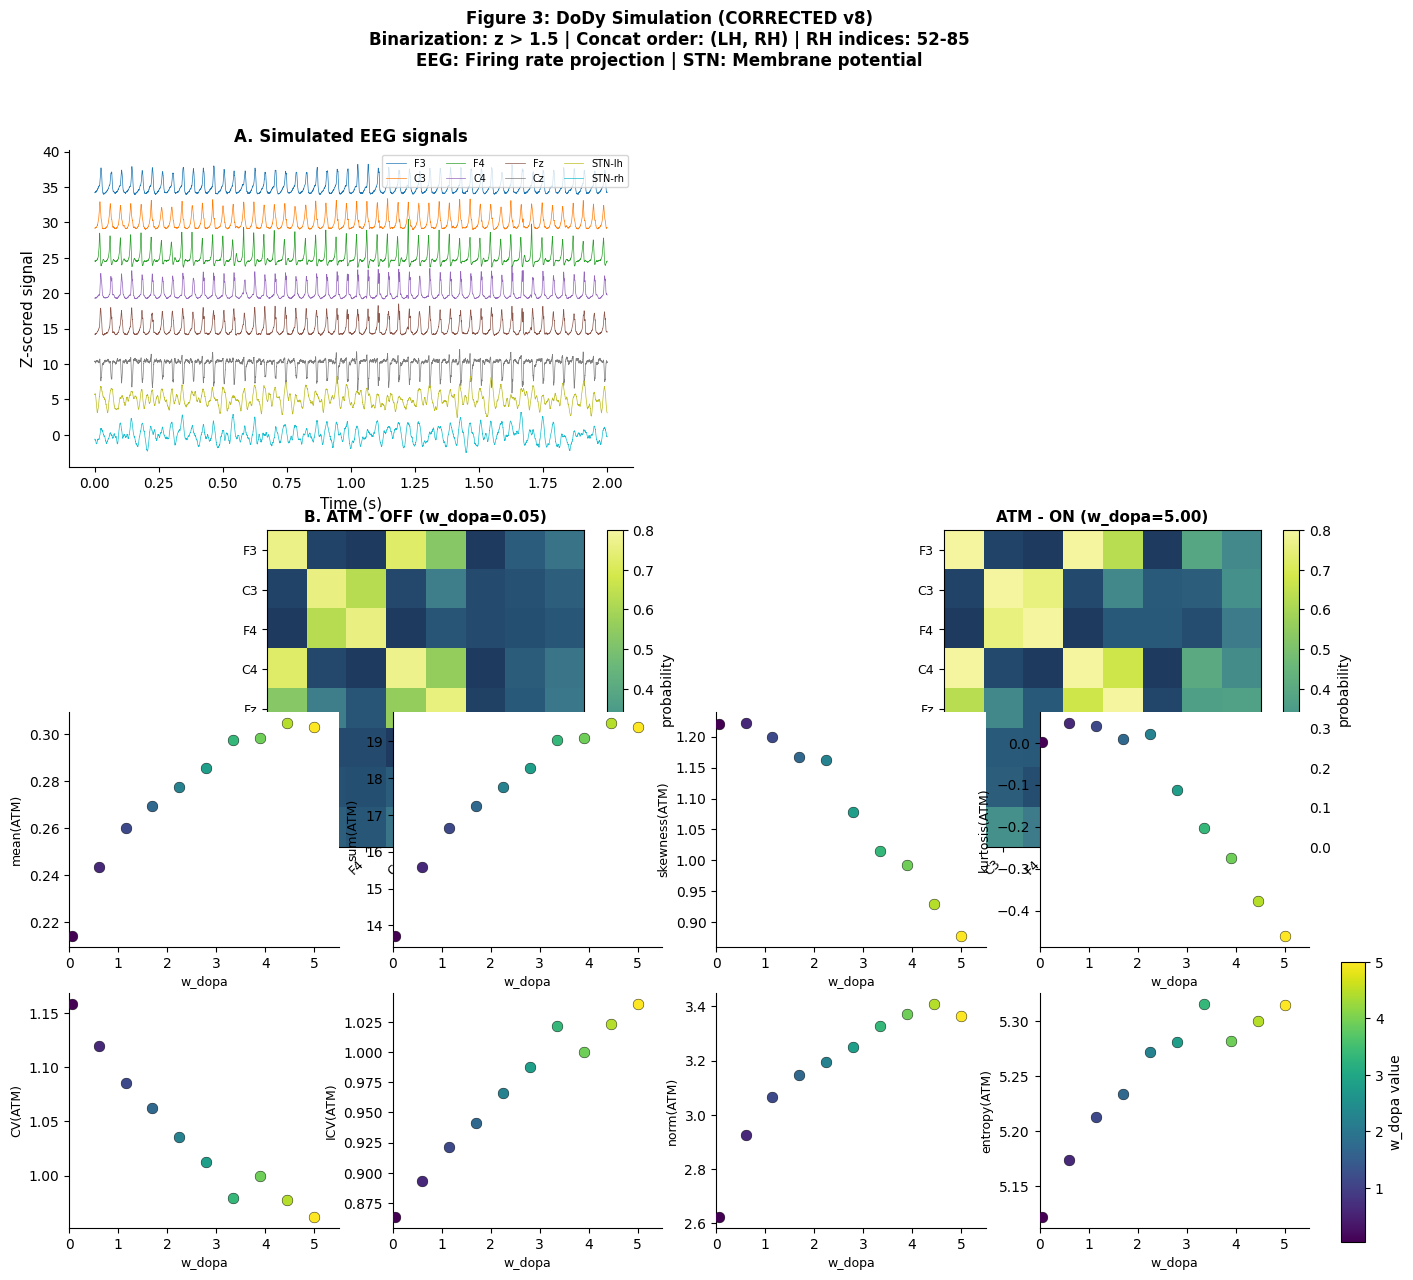

/tmp/ipython-input-2581961005.py:905: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


  Saved: /content/figure3c_features_corrected_v8.png


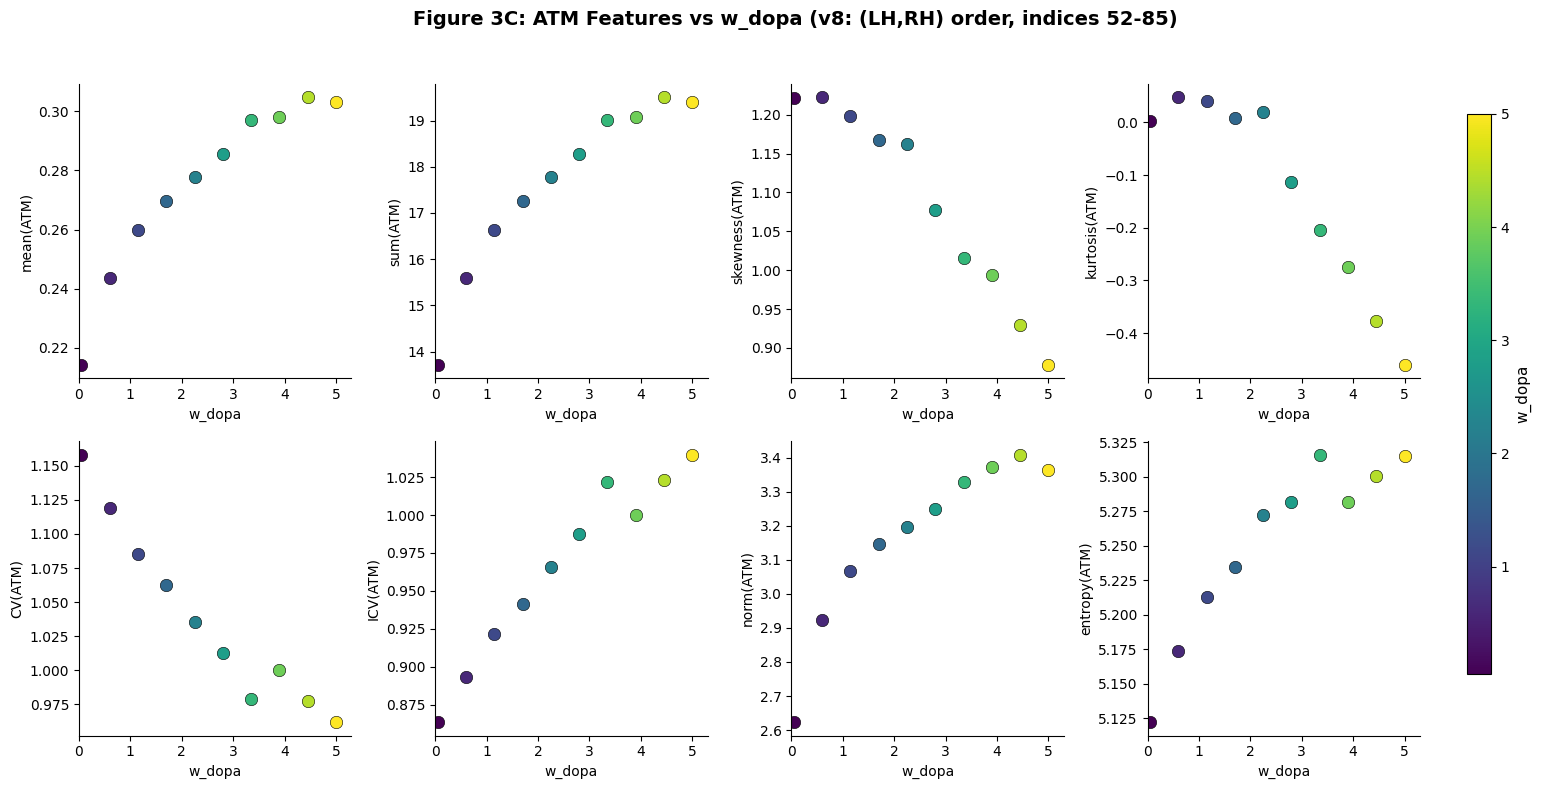

  Saved: /content/atm_progression_corrected_v8.png


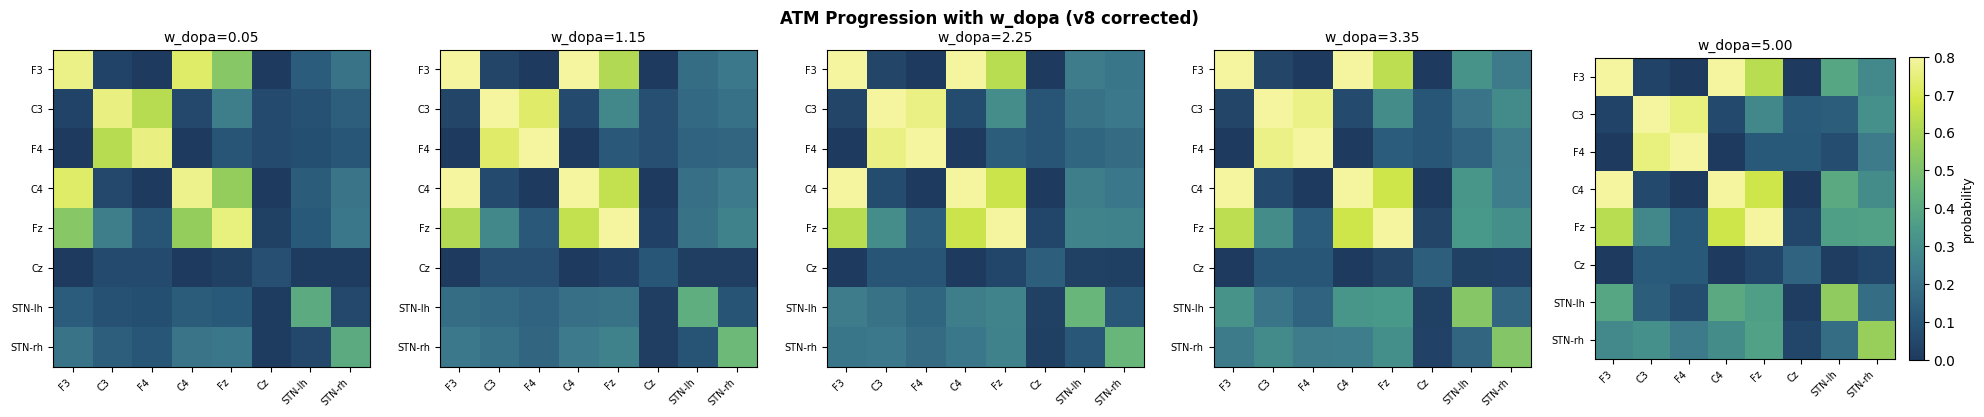


SIMULATION COMPLETE

Results Summary:
------------------------------------------------------------------------------------------
w_dopa     n_aval   mean       sum        skew       kurt       CV         ICV       
------------------------------------------------------------------------------------------
0.05       938      0.2143     13.7139    1.2210     0.0022     1.1582     0.8634    
0.60       845      0.2436     15.5883    1.2223     0.0475     1.1193     0.8934    
1.15       810      0.2599     16.6317    1.1989     0.0398     1.0850     0.9217    
1.70       795      0.2695     17.2503    1.1678     0.0084     1.0622     0.9414    
2.25       779      0.2776     17.7676    1.1630     0.0197     1.0352     0.9660    
2.80       782      0.2855     18.2708    1.0777     -0.1131    1.0126     0.9875    
3.35       773      0.2972     19.0215    1.0154     -0.2043    0.9790     1.0214    
3.90       765      0.2982     19.0831    0.9933     -0.2745    0.9998     1.0002    
4.45 

In [12]:
"""
===============================================================================
DoDy Model Simulation - CORRECTED VERSION v8 (Google Colab Version)
===============================================================================
Based on Angiolelli et al. 2025 - "The Virtual Parkinsonian Patient"
npj Systems Biology and Applications (2025) 11:40

GOOGLE COLAB SETUP:
===================
1. Upload your connectivity and leadfield files to /content/ OR
2. Mount Google Drive and place files in your Drive folder

v8 CRITICAL FIXES (after comparing with Dody_model_elaborationdata.ipynb):
============================================================================

1. CONCATENATION ORDER FIXED: (LH, RH) to match notebook and leadfield L6
   - v6/v7 WRONG: np.concatenate([r_rh, r_lh])  → (RH, LH)
   - v8 CORRECT:  np.concatenate([r_lh, r_rh])  → (LH, RH)

   The leadfield L6 expects:
     - Columns 0-33:  LEFT hemisphere sources
     - Columns 34-67: RIGHT hemisphere sources

   v6/v7 was swapping hemispheres, causing F3/C3 to receive RH signals!

2. RH CORTICAL INDICES: Using 52:86 to match precomputed L6
   - v7 used 51:85 (anatomically correct but INCONSISTENT with L6)
   - v8 uses 52:86 (matches the precomputed L6 computation)

   NOTE: The notebook compute_LL function uses V[:, 52:86, :].
   The leadfield L6 was precomputed with this indexing, so we must match it.

   While 52:86 includes R.CER (cerebellum) and misses R.BSTS, this is
   REQUIRED for consistency with the precomputed leadfield matrix.

3. STN INDICES: 42 (lh-STN), 45 (rh-STN) - VERIFIED CORRECT

4. Uses FIRING RATE (r) for EEG, MEMBRANE POTENTIAL (V) for STN
   - Paper page 9: "firing rates are translated using the lead field matrix"
   - Paper page 3: "As per the STN, simulated voltages are compared directly"
   - Note: The notebook actually uses V for both, but paper says to use r for EEG

===============================================================================
"""

import numpy as np
from scipy.stats import zscore, skew, kurtosis
from scipy.signal import detrend
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib import cm
import os
import warnings
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing

# =============================================================================
# GOOGLE COLAB CONFIGURATION
# =============================================================================
# Option 1: Use /content/ (upload files directly to Colab)
# Option 2: Use Google Drive (mount drive first)

USE_GOOGLE_DRIVE = False  # Set to True if using Google Drive

if USE_GOOGLE_DRIVE:
    # Mount Google Drive (run this cell first in Colab)
    # from google.colab import drive
    # drive.mount('/content/drive')
    LOCAL_ROOT = "/content/drive/MyDrive/DoDy_Data"  # Adjust path as needed
else:
    # Use Colab's default storage (upload files to /content/)
    LOCAL_ROOT = "/content"

# =============================================================================
# FILE PATHS
# =============================================================================
CONN_DOPAMINE_PATH = os.path.join(LOCAL_ROOT, "conn_dopamine.npy")
CONN_EXCITATOR_PATH = os.path.join(LOCAL_ROOT, "conn_excitator.npy")
CONN_INHIBITOR_PATH = os.path.join(LOCAL_ROOT, "conn_inhibitor.npy")

# PRECOMPUTED LEADFIELD MATRIX (from notebook)
LEADFIELD_PATH = os.path.join(LOCAL_ROOT, "L6_regions2channels_abs_sum.npy")

OUTPUT_DIR = LOCAL_ROOT
RANDOM_SEED = 42

# Try to import numba for JIT compilation
try:
    from numba import jit, prange
    NUMBA_AVAILABLE = True
    print("✓ Numba available - using JIT compilation for speedup")
except ImportError:
    NUMBA_AVAILABLE = False
    print("⚠ Numba not available - running without JIT (slower)")
    print("  To install: !pip install numba")
    def jit(*args, **kwargs):
        def decorator(func):
            return func
        return decorator
    prange = range

# =============================================================================
# MODEL PARAMETERS (Table S1 from paper)
# =============================================================================
a = 0.04          # [1/ms·mV]
b = 5.0           # [1/ms]
c = 140.0         # [mV/ms]
Delta = 1.0       # [mV] - Width parameter
Eta = 18.0        # [mV/ms] - Excitability parameter
Iext = 0.0        # [mV/ms]

# Synaptic parameters
ga = 12.0         # [1/ms]
gg = 12.0         # [1/ms]
Ea = 0.0          # [mV]
Eg = -80.0        # [mV]
tauSa = 5.0       # [ms]
tauSg = 5.0       # [ms]
Sja = 0.8         # [-]
Sjg = 1.2         # [-]
Ja = 0.0          # Local recurrent

# Adaptation parameters
alpha = 0.013     # [1/ms]
beta = 0.4        # [-]
ud = 12.0         # [1/ms]

# Dopamine dynamics (Eq. 6)
k = 10e4          # [1/ms]
Vmax = 1300.0     # [nM/ms]
Km = 50.0         # [nM]
Bd = 0.2          # [-] - Baseline dopamine effect (B_Dp in paper)
Ad = 1.0          # [-] - Dopamine modulation strength (A_Dp in paper)
tau_Dp = 500.0    # [ms]

# =============================================================================
# SIMULATION PARAMETERS
# =============================================================================
SIMULATION_TIME = 30000.0      # 30 seconds in ms
TRANSIENT_TIME = 1000.0        # 1 second transient (paper discards first second)
DT = 0.01                      # Integration step [ms]
SAVE_EVERY = 10                # Save every 10 steps = 0.1 ms resolution

# Noise level for stochastic differential equations
SIGMA = 1e-3

# =============================================================================
# STATE BOUNDS
# =============================================================================
R_MIN, R_MAX = 0.0, 1000.0
V_MIN, V_MAX = -120.0, 60.0
U_MIN, U_MAX = -2000.0, 2000.0
SA_MIN, SA_MAX = 0.0, 20.0
SG_MIN, SG_MAX = 0.0, 20.0
DP_MIN, DP_MAX = 0.0, 2000.0

# =============================================================================
# PARCELLATION AND ELECTRODE CONFIGURATION - MATCHING NOTEBOOK
# =============================================================================
n_nodes = 88

# Cortical indices MATCHING the notebook compute_LL function:
# rr1 = V[:, 0:34, :]   → LH cortical
# rr2 = V[:, 52:86, :]  → RH cortical (indices 52-85)
# reduced_V = np.concatenate((rr1, rr2), axis=1)  → ORDER: (LH, RH)

N_CORTICAL_LH_START = 0         # LH cortical start
N_CORTICAL_LH_END = 34          # LH cortical end (exclusive)
N_CORTICAL_RH_START = 52        # RH cortical start (matches notebook)
N_CORTICAL_RH_END = 86          # RH cortical end (exclusive, matches notebook)

# STN indices from notebook:
# STN_lh_time_series = V[:, 42, :]
# STN_rh_time_series = V[:, 45, :]
STN_LH_IDX = 42  # Left STN (lh-STN in atlas)
STN_RH_IDX = 45  # Right STN (rh-STN in atlas)

# EEG channels - ORDER TO MATCH PAPER FIGURE 3B
# Paper page 3: "F3, C3, F4, C4, Fz, and Cz"
EEG_CHANNELS = ['F3', 'C3', 'F4', 'C4', 'Fz', 'Cz']
DEEP_CHANNELS = ['STN-lh', 'STN-rh']
ALL_CHANNELS = EEG_CHANNELS + DEEP_CHANNELS

# =============================================================================
# ATM PARAMETERS - FROM PAPER
# =============================================================================
# Paper page 3: "set to 1 for z > 1.5, and to 0 otherwise"
THETA = 1.5                    # Threshold value z > 1.5
USE_ABSOLUTE_VALUE = False     # Use z > θ (NOT |z| > θ)

# w_dopa range (matching paper Figure 3C)
WDOPA_MIN = 0.05
WDOPA_MAX = 5.0
N_WDOPA_VALUES = 10  # Number of w_dopa values to sweep

# Number of parallel workers (Colab typically has 2 cores)
N_WORKERS = min(2, multiprocessing.cpu_count())

# =============================================================================
# ATM COLORMAP - MATCHING PAPER FIGURE 3B
# =============================================================================
def create_paper_atm_colormap():
    """Create colormap matching paper Figure 3B."""
    colors = [
        '#1e3a5f',  # Dark blue (low probability)
        '#2a5a7a',  # Blue
        '#3d7a8c',  # Teal
        '#4a9a8a',  # Cyan-green
        '#6ab87a',  # Green
        '#9ad05a',  # Yellow-green
        '#d4e84a',  # Yellow (high probability)
        '#f5f5a0'   # Light yellow
    ]
    return LinearSegmentedColormap.from_list('paper_atm', colors, N=256)

ATM_COLORMAP = create_paper_atm_colormap()


# =============================================================================
# COLAB HELPER FUNCTIONS
# =============================================================================
def check_files_exist():
    """Check if all required files exist and print status."""
    print("\n" + "="*60)
    print("CHECKING REQUIRED FILES")
    print("="*60)
    print(f"Data directory: {LOCAL_ROOT}")
    print("-"*60)

    files = {
        'conn_dopamine.npy': CONN_DOPAMINE_PATH,
        'conn_excitator.npy': CONN_EXCITATOR_PATH,
        'conn_inhibitor.npy': CONN_INHIBITOR_PATH,
        'L6_regions2channels_abs_sum.npy': LEADFIELD_PATH
    }

    all_exist = True
    for name, path in files.items():
        exists = os.path.exists(path)
        status = "✓ Found" if exists else "✗ MISSING"
        print(f"  {name}: {status}")
        if not exists:
            all_exist = False

    print("-"*60)
    if all_exist:
        print("All files found! Ready to run simulation.")
    else:
        print("\n⚠ MISSING FILES! Please upload them to Colab:")
        print("  Option 1: Use the file upload button in Colab's left panel")
        print("  Option 2: Run: from google.colab import files; files.upload()")
        print("  Option 3: Mount Google Drive and set USE_GOOGLE_DRIVE = True")

    return all_exist


def setup_colab_environment():
    """Setup Colab environment with required packages."""
    print("Setting up Colab environment...")

    # Check if running in Colab
    try:
        import google.colab
        IN_COLAB = True
        print("  Running in Google Colab")
    except ImportError:
        IN_COLAB = False
        print("  Not running in Colab (local environment)")

    # Install numba if not available
    if not NUMBA_AVAILABLE and IN_COLAB:
        print("  Installing numba for faster computation...")
        os.system("pip install numba -q")
        print("  Please restart runtime and re-run to use numba")

    return IN_COLAB


# =============================================================================
# CONNECTIVITY LOADING
# =============================================================================
def load_connectivity_matrices():
    """Load the three connectivity matrices."""
    print("\nLoading connectivity matrices...")

    conn_dopamine = np.load(CONN_DOPAMINE_PATH).T
    conn_excitator = np.load(CONN_EXCITATOR_PATH).T
    conn_inhibitor = np.load(CONN_INHIBITOR_PATH).T

    print(f"  Dopamine: {conn_dopamine.shape}, {np.count_nonzero(conn_dopamine)} connections")
    print(f"  Excitatory: {conn_excitator.shape}, {np.count_nonzero(conn_excitator)} connections")
    print(f"  Inhibitory: {conn_inhibitor.shape}, {np.count_nonzero(conn_inhibitor)} connections")

    return conn_dopamine, conn_excitator, conn_inhibitor


# =============================================================================
# LEADFIELD MATRIX - PRECOMPUTED
# =============================================================================
def load_precomputed_leadfield():
    """Load precomputed leadfield matrix."""
    print("\n" + "="*60)
    print("LOADING PRECOMPUTED LEADFIELD MATRIX")
    print("="*60)

    if os.path.exists(LEADFIELD_PATH):
        L = np.load(LEADFIELD_PATH)
        print(f"  Loaded leadfield from: {LEADFIELD_PATH}")
        print(f"  Leadfield shape: {L.shape}")
        print(f"  Expected: (6 channels, 68 cortical regions)")
        print(f"  Leadfield columns 0-33:  LH sources")
        print(f"  Leadfield columns 34-67: RH sources")
        return L
    else:
        raise FileNotFoundError(
            f"Precomputed leadfield matrix not found at: {LEADFIELD_PATH}\n"
            "Please upload L6_regions2channels_abs_sum.npy to Colab."
        )


# =============================================================================
# OPTIMIZED DoDy MODEL DYNAMICS WITH NUMBA JIT
# =============================================================================
@jit(nopython=True, fastmath=True)
def dody_derivatives_numba(r, V, u, Sa, Sg, Dp,
                           coupling_inh, coupling_exc, coupling_dopa,
                           n_nodes_local):
    """DoDy model derivatives - Numba optimized version."""
    # Constants
    a_local = 0.04
    b_local = 5.0
    c_local = 140.0
    Delta_local = 1.0
    Eta_local = 18.0
    Iext_local = 0.0
    ga_local = 12.0
    gg_local = 12.0
    Ea_local = 0.0
    Eg_local = -80.0
    tauSa_local = 5.0
    tauSg_local = 5.0
    Sja_local = 0.8
    Sjg_local = 1.2
    Ja_local = 0.0
    alpha_local = 0.013
    beta_local = 0.4
    ud_local = 12.0
    k_local = 10e4
    Vmax_local = 1300.0
    Km_local = 50.0
    Bd_local = 0.2
    Ad_local = 1.0
    tau_Dp_local = 500.0
    pi = 3.141592653589793

    dr = np.empty(n_nodes_local)
    dV = np.empty(n_nodes_local)
    du = np.empty(n_nodes_local)
    dSa = np.empty(n_nodes_local)
    dSg = np.empty(n_nodes_local)
    dDp = np.empty(n_nodes_local)

    for i in range(n_nodes_local):
        dopa_factor = Ad_local * Dp[i] + Bd_local

        dr[i] = (2.0 * a_local * r[i] * V[i]
                 + b_local * r[i]
                 - ga_local * Sa[i] * r[i]
                 - gg_local * Sg[i] * r[i]
                 + (a_local * Delta_local) / pi)

        dV[i] = (a_local * V[i] * V[i]
                 + b_local * V[i]
                 + c_local
                 + Eta_local
                 - (pi * pi * r[i] * r[i]) / a_local
                 + dopa_factor * ga_local * Sa[i] * (Ea_local - V[i])
                 + gg_local * Sg[i] * (Eg_local - V[i])
                 + Iext_local
                 - u[i])

        du[i] = alpha_local * (beta_local * V[i] - u[i]) + ud_local * r[i]
        dSa[i] = -Sa[i] / tauSa_local + Sja_local * coupling_exc[i] + Ja_local * r[i]
        dSg[i] = -Sg[i] / tauSg_local + Sjg_local * coupling_inh[i]
        dDp[i] = (k_local * coupling_dopa[i] - Vmax_local * Dp[i] / (Km_local + Dp[i] + 1e-10)) / tau_Dp_local

    return dr, dV, du, dSa, dSg, dDp


@jit(nopython=True, fastmath=True)
def apply_bounds_numba(r, V, u, Sa, Sg, Dp):
    """Apply physiological bounds to state variables."""
    r = np.clip(r, 0.0, 1000.0)
    V = np.clip(V, -120.0, 60.0)
    u = np.clip(u, -2000.0, 2000.0)
    Sa = np.clip(Sa, 0.0, 20.0)
    Sg = np.clip(Sg, 0.0, 20.0)
    Dp = np.clip(Dp, 0.0, 2000.0)
    return r, V, u, Sa, Sg, Dp


@jit(nopython=True, fastmath=True)
def simulate_dody_core(conn_inh, conn_exc, conn_dopa,
                       c_inh, c_exc, c_dopa,
                       n_nodes_local, n_steps, n_save, save_every,
                       dt, sigma, transient_steps,
                       seed):
    """Core simulation loop - Numba JIT compiled."""
    np.random.seed(seed)

    # Initial conditions with heterogeneity
    r = 0.05 + 0.02 * np.random.randn(n_nodes_local)
    r = np.clip(r, 0.01, 0.2)
    V = -65.0 + 5.0 * np.random.randn(n_nodes_local)
    V = np.clip(V, -80.0, -50.0)
    u = np.zeros(n_nodes_local)
    Sa = 0.01 * np.abs(np.random.randn(n_nodes_local))
    Sg = 0.01 * np.abs(np.random.randn(n_nodes_local))
    Dp = 0.1 + 0.05 * np.abs(np.random.randn(n_nodes_local))

    n_save_post = n_save - transient_steps
    t_all = np.zeros(n_save_post)
    V_all = np.zeros((n_save_post, n_nodes_local))
    r_all = np.zeros((n_save_post, n_nodes_local))

    t = 0.0
    save_idx = 0
    sqrt_dt = np.sqrt(dt)

    for step in range(n_steps):
        coupling_inh = c_inh * (conn_inh @ r)
        coupling_exc = c_exc * (conn_exc @ r)
        coupling_dopa = c_dopa * (conn_dopa @ r)

        noise_r = sigma * np.random.randn(n_nodes_local) * sqrt_dt
        noise_V = sigma * 10 * np.random.randn(n_nodes_local) * sqrt_dt

        dr1, dV1, du1, dSa1, dSg1, dDp1 = dody_derivatives_numba(
            r, V, u, Sa, Sg, Dp, coupling_inh, coupling_exc, coupling_dopa, n_nodes_local)

        r_pred = r + dt * dr1 + noise_r
        V_pred = V + dt * dV1 + noise_V
        u_pred = u + dt * du1
        Sa_pred = Sa + dt * dSa1
        Sg_pred = Sg + dt * dSg1
        Dp_pred = Dp + dt * dDp1

        r_pred, V_pred, u_pred, Sa_pred, Sg_pred, Dp_pred = apply_bounds_numba(
            r_pred, V_pred, u_pred, Sa_pred, Sg_pred, Dp_pred)

        coupling_inh_pred = c_inh * (conn_inh @ r_pred)
        coupling_exc_pred = c_exc * (conn_exc @ r_pred)
        coupling_dopa_pred = c_dopa * (conn_dopa @ r_pred)

        dr2, dV2, du2, dSa2, dSg2, dDp2 = dody_derivatives_numba(
            r_pred, V_pred, u_pred, Sa_pred, Sg_pred, Dp_pred,
            coupling_inh_pred, coupling_exc_pred, coupling_dopa_pred, n_nodes_local)

        r = r + 0.5 * dt * (dr1 + dr2) + noise_r
        V = V + 0.5 * dt * (dV1 + dV2) + noise_V
        u = u + 0.5 * dt * (du1 + du2)
        Sa = Sa + 0.5 * dt * (dSa1 + dSa2)
        Sg = Sg + 0.5 * dt * (dSg1 + dSg2)
        Dp = Dp + 0.5 * dt * (dDp1 + dDp2)

        r, V, u, Sa, Sg, Dp = apply_bounds_numba(r, V, u, Sa, Sg, Dp)
        t += dt

        if (step + 1) % save_every == 0:
            current_save_idx = (step + 1) // save_every - 1
            if current_save_idx >= transient_steps and save_idx < n_save_post:
                t_all[save_idx] = t
                V_all[save_idx, :] = V
                r_all[save_idx, :] = r
                save_idx += 1

    return t_all, V_all, r_all


def simulate_dody(conn_inh, conn_exc, conn_dopa,
                  c_inh=0.07, c_exc=0.07, c_dopa=0.7,
                  random_seed=RANDOM_SEED, verbose=True):
    """Simulate DoDy model using optimized Numba core."""
    if verbose:
        print(f"  Simulating (w_dopa={c_dopa:.3f})...", end=" ", flush=True)

    n_steps = int(SIMULATION_TIME / DT)
    n_save = n_steps // SAVE_EVERY
    transient_steps = int(TRANSIENT_TIME / (DT * SAVE_EVERY))

    t_all, V_all, r_all = simulate_dody_core(
        conn_inh, conn_exc, conn_dopa,
        c_inh, c_exc, c_dopa,
        n_nodes, n_steps, n_save, SAVE_EVERY,
        DT, SIGMA, transient_steps,
        random_seed
    )

    if verbose:
        print(f"done. Shape: {V_all.shape}")

    return t_all, V_all, r_all


# =============================================================================
# SIGNAL COMPUTATION - v8 CORRECTED TO MATCH NOTEBOOK
# =============================================================================
def compute_eeg_signals(r, L):
    """
    Compute EEG signals via leadfield projection.

    v8 CRITICAL CORRECTIONS to match notebook compute_LL function:

    1. CONCATENATION ORDER: (LH, RH) - NOT (RH, LH) as in v6/v7!
       Notebook: reduced_V = np.concatenate((rr1, rr2), axis=1)
       Where rr1=LH, rr2=RH

    2. INDICES matching notebook:
       Notebook: rr1 = V[:, 0:34, :]   → LH (indices 0-33)
       Notebook: rr2 = V[:, 52:86, :]  → RH (indices 52-85)

       The leadfield L6 was precomputed with these indices!

    Paper page 9: "firing rates are translated using the lead field matrix"
    (Note: notebook actually uses V, but paper says to use r)

    Args:
        r: Firing rates, shape (n_times, n_nodes)
        L: Leadfield matrix, shape (6 channels, 68 cortical regions)
           - Columns 0-33:  expect LH sources
           - Columns 34-67: expect RH sources

    Returns:
        EEG signals, shape (n_times, 6), z-scored
    """
    # Extract cortical regions MATCHING notebook indices
    r_lh = r[:, N_CORTICAL_LH_START:N_CORTICAL_LH_END]  # indices 0-33 (34 regions)
    r_rh = r[:, N_CORTICAL_RH_START:N_CORTICAL_RH_END]  # indices 52-85 (34 regions)

    # CRITICAL: Concatenate as (LH, RH) to match leadfield column order!
    # v6/v7 had this REVERSED which swapped hemispheres!
    r_cortical = np.concatenate([r_lh, r_rh], axis=1)  # Shape: (n_times, 68)

    # Project to sensor space: EEG = L @ r_cortical.T
    eeg_raw = (L @ r_cortical.T).T  # Shape: (n_times, 6)

    # Z-score normalize per channel
    eeg_signals = zscore(eeg_raw, axis=0)

    return eeg_signals


def compute_stn_signals(V):
    """
    Compute STN deep electrode signals using membrane potential.

    Paper (page 3): "As per the STN, simulated voltages are compared directly"

    Notebook: STN_lh_time_series = V[:, 42, :]
              STN_rh_time_series = V[:, 45, :]

    Args:
        V: Membrane potentials, shape (n_times, n_nodes)

    Returns:
        STN signals, shape (n_times, 2), z-scored
    """
    stn_V = np.column_stack([V[:, STN_LH_IDX], V[:, STN_RH_IDX]])
    stn_signals = zscore(stn_V, axis=0)
    return stn_signals


def combine_signals(eeg, stn):
    """
    Combine EEG (6 channels) and STN (2 channels) into 8-channel array.
    Order: F3, C3, F4, C4, Fz, Cz, STN-lh, STN-rh
    """
    return np.concatenate([eeg, stn], axis=1)


# =============================================================================
# ATM COMPUTATION
# =============================================================================
@jit(nopython=True)
def binarize_signals_numba(signals, theta, use_absolute):
    """Binarize z-scored signals using threshold."""
    n_times, n_channels = signals.shape
    binary = np.zeros((n_times, n_channels), dtype=np.int32)

    for t in range(n_times):
        for ch in range(n_channels):
            if use_absolute:
                if np.abs(signals[t, ch]) > theta:
                    binary[t, ch] = 1
            else:
                if signals[t, ch] > theta:
                    binary[t, ch] = 1

    return binary


@jit(nopython=True)
def detect_avalanches_numba(binary_matrix_T, min_duration=2):
    """Detect avalanches from binarized activity."""
    n_channels, n_times = binary_matrix_T.shape

    max_avalanches = n_times // 2 + 1
    starts = np.empty(max_avalanches, dtype=np.int32)
    ends = np.empty(max_avalanches, dtype=np.int32)
    n_avalanches = 0

    any_active = np.zeros(n_times, dtype=np.int32)
    for t in range(n_times):
        for ch in range(n_channels):
            if binary_matrix_T[ch, t] == 1:
                any_active[t] = 1
                break

    in_avalanche = False
    start_idx = 0

    for t in range(n_times):
        if any_active[t] == 1 and not in_avalanche:
            in_avalanche = True
            start_idx = t
        elif any_active[t] == 0 and in_avalanche:
            in_avalanche = False
            duration = t - start_idx
            if duration >= min_duration:
                starts[n_avalanches] = start_idx
                ends[n_avalanches] = t
                n_avalanches += 1

    if in_avalanche:
        duration = n_times - start_idx
        if duration >= min_duration:
            starts[n_avalanches] = start_idx
            ends[n_avalanches] = n_times
            n_avalanches += 1

    return starts[:n_avalanches], ends[:n_avalanches], n_avalanches


@jit(nopython=True)
def compute_transition_matrix_vectorized(binary_avalanche):
    """Compute transition probability matrix for one avalanche."""
    n_channels, n_times = binary_avalanche.shape
    T = np.zeros((n_channels, n_channels))

    if n_times < 2:
        return T

    for i in range(n_channels):
        n_activations = 0
        for t in range(n_times - 1):
            if binary_avalanche[i, t] == 1:
                n_activations += 1
                for j in range(n_channels):
                    T[i, j] += binary_avalanche[j, t + 1]

        if n_activations > 0:
            for j in range(n_channels):
                T[i, j] /= n_activations

    return T


def compute_ATM(combined_signals, theta=THETA, use_absolute=USE_ABSOLUTE_VALUE, verbose=True):
    """Compute Avalanche Transition Matrix (ATM)."""
    if verbose:
        threshold_str = f"|z|>{theta}" if use_absolute else f"z>{theta}"
        print(f"    Computing ATM (theta={theta}, {threshold_str}):")

    if np.all(np.isnan(combined_signals)):
        if verbose:
            print("      ERROR: All NaN signals")
        return np.zeros((8, 8)), 0, 0

    binary = binarize_signals_numba(combined_signals, theta, use_absolute)

    if verbose:
        threshold_str = f"|z|>{theta}" if use_absolute else f"z>{theta}"
        print(f"      Per-channel activations ({threshold_str}):")
        for i, ch in enumerate(ALL_CHANNELS):
            n_active = np.sum(binary[:, i])
            pct = 100.0 * n_active / len(binary)
            print(f"        {ch}: {n_active} samples ({pct:.1f}%)")

    binary_T = binary.T.astype(np.int32)
    starts, ends, n_avalanches = detect_avalanches_numba(binary_T, min_duration=2)

    if verbose:
        print(f"      Detected {n_avalanches} avalanches")

    if n_avalanches == 0:
        if verbose:
            print("      WARNING: No avalanches detected!")
        return np.zeros((8, 8)), 0, 0

    TMs = np.zeros((n_avalanches, 8, 8))
    durations = np.zeros(n_avalanches)

    for idx in range(n_avalanches):
        aval = binary_T[:, starts[idx]:ends[idx]]
        TMs[idx] = compute_transition_matrix_vectorized(aval)
        durations[idx] = ends[idx] - starts[idx]

    ATM_averaged = np.mean(TMs, axis=0)
    ATM_symmetric = (ATM_averaged + ATM_averaged.T) / 2

    mean_dur = np.mean(durations)
    if verbose:
        print(f"      Mean avalanche duration: {mean_dur:.1f} samples")
        print(f"      ATM diagonal mean: {np.mean(np.diag(ATM_symmetric)):.3f}")
        print(f"      ATM off-diagonal mean: {np.mean(ATM_symmetric[~np.eye(8, dtype=bool)]):.3f}")

    return ATM_symmetric, n_avalanches, mean_dur


# =============================================================================
# FEATURE EXTRACTION
# =============================================================================
def compute_shannon_entropy(atm):
    """Compute Shannon entropy of ATM."""
    atm_flat = atm.flatten()
    total = np.sum(atm_flat)
    if total <= 0:
        return 0.0
    p = atm_flat / total
    p = p[p > 0]
    entropy = -np.sum(p * np.log2(p))
    return entropy


def extract_atm_features_figure3c(atm):
    """Extract the 8 features shown in Figure 3C."""
    atm_flat = atm.flatten()

    mean_atm = np.mean(atm_flat)
    sum_atm = np.sum(atm_flat)
    skewness_atm = skew(atm_flat)
    kurtosis_atm = kurtosis(atm_flat)
    std_atm = np.std(atm_flat)
    cv_atm = std_atm / mean_atm if mean_atm > 0 else 0.0
    icv_atm = mean_atm / std_atm if std_atm > 0 else 0.0
    norm_atm = np.linalg.norm(atm, 'fro')
    entropy_atm = compute_shannon_entropy(atm)

    return {
        'mean_atm': mean_atm,
        'sum_atm': sum_atm,
        'skewness_atm': skewness_atm,
        'kurtosis_atm': kurtosis_atm,
        'cv_atm': cv_atm,
        'icv_atm': icv_atm,
        'norm_atm': norm_atm,
        'entropy_atm': entropy_atm
    }


# =============================================================================
# VISUALIZATION
# =============================================================================
def plot_atm_paper_style(atm, title, ax, vmin=0, vmax=0.8):
    """Plot ATM matrix matching paper Figure 3B style."""
    im = ax.imshow(atm, cmap=ATM_COLORMAP, aspect='equal',
                   vmin=vmin, vmax=vmax, interpolation='nearest')

    ax.set_xticks(range(8))
    ax.set_yticks(range(8))
    ax.set_xticklabels(ALL_CHANNELS, fontsize=9, rotation=45, ha='right')
    ax.set_yticklabels(ALL_CHANNELS, fontsize=9)
    ax.set_title(title, fontsize=11, fontweight='bold')

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('probability', fontsize=10)
    return im


def plot_figure3_paper_style(t_all, combined_signals_list, features_list,
                              wdopa_values, output_path):
    """Generate Figure 3 matching paper style."""
    print("\nGenerating Figure 3 (paper style)...")

    fig = plt.figure(figsize=(16, 14))
    fig.suptitle(f'Figure 3: DoDy Simulation (CORRECTED v8)\n'
                 f'Binarization: z > {THETA} | Concat order: (LH, RH) | RH indices: 52-85\n'
                 f'EEG: Firing rate projection | STN: Membrane potential',
                 fontsize=12, fontweight='bold')

    cmap_wdopa = plt.cm.viridis
    colors = cmap_wdopa(np.linspace(0, 1, len(wdopa_values)))

    # Panel A: Time series
    ax1 = fig.add_subplot(3, 2, 1)
    mid_idx = len(wdopa_values) // 2
    signals = combined_signals_list[mid_idx]

    samples_per_sec = int(1000 / (DT * SAVE_EVERY))
    t_start = samples_per_sec
    t_end = t_start + 2 * samples_per_sec
    t_end = min(t_end, len(t_all))
    t_slice = slice(t_start, t_end)
    t_plot = (t_all[t_slice] - t_all[t_start]) / 1000

    channel_colors = plt.cm.tab10(np.linspace(0, 1, 8))
    for i, ch_name in enumerate(ALL_CHANNELS):
        offset = (7 - i) * 5
        ax1.plot(t_plot, signals[t_slice, i] + offset,
                color=channel_colors[i], linewidth=0.5, label=ch_name)

    ax1.set_xlabel('Time (s)', fontsize=11)
    ax1.set_ylabel('Z-scored signal', fontsize=11)
    ax1.set_title('A. Simulated EEG signals', fontsize=12, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=7, ncol=4)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Panel B: ATM matrices
    ax2 = fig.add_subplot(3, 2, 3)
    atm_low = features_list[0]['atm_matrix']
    plot_atm_paper_style(atm_low, f'B. ATM - OFF (w_dopa={wdopa_values[0]:.2f})', ax2)

    ax3 = fig.add_subplot(3, 2, 4)
    atm_high = features_list[-1]['atm_matrix']
    plot_atm_paper_style(atm_high, f'ATM - ON (w_dopa={wdopa_values[-1]:.2f})', ax3)

    # Panel C: Features
    feature_specs = [
        ('mean_atm', 'mean(ATM)'),
        ('sum_atm', 'sum(ATM)'),
        ('skewness_atm', 'skewness(ATM)'),
        ('kurtosis_atm', 'kurtosis(ATM)'),
        ('cv_atm', 'CV(ATM)'),
        ('icv_atm', 'ICV(ATM)'),
        ('norm_atm', 'norm(ATM)'),
        ('entropy_atm', 'entropy(ATM)')
    ]

    for idx, (fname, flabel) in enumerate(feature_specs):
        ax = fig.add_subplot(4, 4, 9 + idx)
        values = [f[fname] for f in features_list]

        for i, (w, v, color) in enumerate(zip(wdopa_values, values, colors)):
            ax.scatter(w, v, c=[color], s=60, edgecolor='k', linewidth=0.3, zorder=3)

        ax.set_xlabel('w_dopa', fontsize=9)
        ax.set_ylabel(flabel, fontsize=9)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim([0, WDOPA_MAX + 0.5])

    sm = plt.cm.ScalarMappable(cmap=cmap_wdopa, norm=Normalize(vmin=WDOPA_MIN, vmax=WDOPA_MAX))
    sm.set_array([])
    cbar_ax = fig.add_axes([0.92, 0.1, 0.015, 0.2])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('w_dopa value', fontsize=10)

    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"  Saved: {output_path}")
    plt.show()
    return fig


def plot_figure3c_only(features_list, wdopa_values, output_path):
    """Plot only Figure 3C."""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(f'Figure 3C: ATM Features vs w_dopa (v8: (LH,RH) order, indices 52-85)',
                 fontsize=14, fontweight='bold')

    cmap = plt.cm.viridis
    colors = cmap(np.linspace(0, 1, len(wdopa_values)))

    feature_specs = [
        ('mean_atm', 'mean(ATM)'),
        ('sum_atm', 'sum(ATM)'),
        ('skewness_atm', 'skewness(ATM)'),
        ('kurtosis_atm', 'kurtosis(ATM)'),
        ('cv_atm', 'CV(ATM)'),
        ('icv_atm', 'ICV(ATM)'),
        ('norm_atm', 'norm(ATM)'),
        ('entropy_atm', 'entropy(ATM)')
    ]

    for idx, (fname, flabel) in enumerate(feature_specs):
        ax = axes.flatten()[idx]
        values = [f[fname] for f in features_list]

        for w, v, color in zip(wdopa_values, values, colors):
            ax.scatter(w, v, c=[color], s=80, edgecolor='k', linewidth=0.4)

        ax.set_xlabel('w_dopa', fontsize=10)
        ax.set_ylabel(flabel, fontsize=10)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim([0, WDOPA_MAX + 0.3])

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=WDOPA_MIN, vmax=WDOPA_MAX))
    sm.set_array([])
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('w_dopa', fontsize=11)

    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"  Saved: {output_path}")
    plt.show()


def plot_atm_progression(features_list, wdopa_values, output_path):
    """Plot ATM progression."""
    n_plot = min(5, len(wdopa_values))
    indices = np.linspace(0, len(wdopa_values)-1, n_plot, dtype=int)

    fig, axes = plt.subplots(1, n_plot, figsize=(4*n_plot, 4))
    fig.suptitle(f'ATM Progression with w_dopa (v8 corrected)',
                 fontsize=12, fontweight='bold')

    for ax_idx, cond_idx in enumerate(indices):
        ax = axes[ax_idx]
        atm = features_list[cond_idx]['atm_matrix']
        w = wdopa_values[cond_idx]

        im = ax.imshow(atm, cmap=ATM_COLORMAP, aspect='equal',
                       vmin=0, vmax=0.8, interpolation='nearest')

        ax.set_xticks(range(8))
        ax.set_yticks(range(8))
        ax.set_xticklabels(ALL_CHANNELS, fontsize=7, rotation=45, ha='right')
        ax.set_yticklabels(ALL_CHANNELS, fontsize=7)
        ax.set_title(f'w_dopa={w:.2f}', fontsize=10)

        if ax_idx == n_plot - 1:
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label('probability', fontsize=9)

    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"  Saved: {output_path}")
    plt.show()


# =============================================================================
# PARALLEL SIMULATION HELPER
# =============================================================================
def run_single_simulation(args):
    """Run a single simulation for parallel processing."""
    (idx, c_dopa, conn_inh, conn_exc, conn_dopa, L, random_seed) = args

    t, V, r = simulate_dody(
        conn_inh, conn_exc, conn_dopa,
        c_inh=0.07, c_exc=0.07, c_dopa=c_dopa,
        random_seed=random_seed,
        verbose=False
    )

    eeg = compute_eeg_signals(r, L)
    stn = compute_stn_signals(V)
    combined = combine_signals(eeg, stn)
    atm, n_aval, mean_dur = compute_ATM(combined, THETA, USE_ABSOLUTE_VALUE, verbose=False)

    features = extract_atm_features_figure3c(atm)
    features['atm_matrix'] = atm
    features['n_avalanches'] = n_aval
    features['mean_duration'] = mean_dur

    return idx, t, combined, features


# =============================================================================
# MAIN SIMULATION
# =============================================================================
def run_simulation(use_parallel=False):
    """
    Run complete DoDy simulation pipeline - CORRECTED VERSION v8.

    v8 CRITICAL FIXES:
    1. Concatenation order: (LH, RH) to match notebook and L6
    2. RH indices: 52-85 to match precomputed L6
    3. STN indices: 42 (lh), 45 (rh) - verified correct
    """
    print("="*70)
    print("DoDy MODEL SIMULATION - CORRECTED VERSION v8 (Google Colab)")
    print("="*70)
    print(f"\nv8 CRITICAL FIXES (matching notebook & L6):")
    print(f"  1. Concatenation order: (LH, RH) - FIXED from (RH, LH)")
    print(f"     v6/v7 had hemispheres SWAPPED!")
    print(f"  2. RH cortical indices: 52-85 (matching L6 computation)")
    print(f"     v7 used 51-84 which was INCONSISTENT with precomputed L6")
    print(f"  3. STN indices: {STN_LH_IDX} (lh), {STN_RH_IDX} (rh) - verified")
    print(f"  4. Binarization: z > {THETA}")
    print(f"  5. EEG uses firing rate, STN uses membrane potential")
    print("="*70)
    print(f"\nSimulation parameters:")
    print(f"  Simulation time: {SIMULATION_TIME/1000:.0f} seconds")
    print(f"  Transient: {TRANSIENT_TIME/1000:.1f} seconds")
    print(f"  w_dopa range: [{WDOPA_MIN}, {WDOPA_MAX}] with {N_WDOPA_VALUES} values")
    print("="*70)

    # Check files first
    if not check_files_exist():
        print("\n❌ Cannot proceed without required files.")
        return None

    # Load connectivity
    conn_dopa, conn_exc, conn_inh = load_connectivity_matrices()

    # Load precomputed leadfield
    L = load_precomputed_leadfield()

    # w_dopa values
    wdopa_values = np.linspace(WDOPA_MIN, WDOPA_MAX, N_WDOPA_VALUES)
    print(f"\nw_dopa values: {wdopa_values}")

    # Storage
    combined_signals_list = [None] * N_WDOPA_VALUES
    features_list = [None] * N_WDOPA_VALUES
    t_all = None

    print("\n" + "-"*50)
    print("Running simulations...")
    print("-"*50)

    if use_parallel and N_WORKERS > 1:
        print(f"Using {N_WORKERS} parallel workers...")

        args_list = [
            (i, c_dopa, conn_inh, conn_exc, conn_dopa, L, RANDOM_SEED)
            for i, c_dopa in enumerate(wdopa_values)
        ]

        with ProcessPoolExecutor(max_workers=N_WORKERS) as executor:
            futures = {executor.submit(run_single_simulation, args): args[0]
                      for args in args_list}

            for future in as_completed(futures):
                idx, t, combined, features = future.result()
                combined_signals_list[idx] = combined
                features_list[idx] = features
                if t_all is None:
                    t_all = t
                print(f"  Completed w_dopa={wdopa_values[idx]:.3f}")
    else:
        for i, c_dopa in enumerate(wdopa_values):
            print(f"\n{'='*50}")
            print(f"Condition {i+1}/{len(wdopa_values)}: w_dopa = {c_dopa:.3f}")
            print("="*50)

            t, V, r = simulate_dody(
                conn_inh, conn_exc, conn_dopa,
                c_inh=0.07, c_exc=0.07, c_dopa=c_dopa,
                random_seed=RANDOM_SEED
            )

            if t_all is None:
                t_all = t

            eeg = compute_eeg_signals(r, L)
            stn = compute_stn_signals(V)
            combined = combine_signals(eeg, stn)
            atm, n_aval, mean_dur = compute_ATM(combined, THETA, USE_ABSOLUTE_VALUE)

            features = extract_atm_features_figure3c(atm)
            features['atm_matrix'] = atm
            features['n_avalanches'] = n_aval
            features['mean_duration'] = mean_dur

            combined_signals_list[i] = combined
            features_list[i] = features

    # Generate figures
    print("\n" + "="*50)
    print("GENERATING FIGURES")
    print("="*50)

    plot_figure3_paper_style(
        t_all, combined_signals_list, features_list, wdopa_values,
        os.path.join(OUTPUT_DIR, "figure3_corrected_v8.png")
    )

    plot_figure3c_only(
        features_list, wdopa_values,
        os.path.join(OUTPUT_DIR, "figure3c_features_corrected_v8.png")
    )

    plot_atm_progression(
        features_list, wdopa_values,
        os.path.join(OUTPUT_DIR, "atm_progression_corrected_v8.png")
    )

    # Save data
    np.save(os.path.join(OUTPUT_DIR, "wdopa_values.npy"), wdopa_values)
    np.save(os.path.join(OUTPUT_DIR, "atm_matrices_corrected_v8.npy"),
            np.array([f['atm_matrix'] for f in features_list]))

    print("\n" + "="*70)
    print("SIMULATION COMPLETE")
    print("="*70)

    # Summary
    print("\nResults Summary:")
    print("-"*90)
    print(f"{'w_dopa':<10} {'n_aval':<8} {'mean':<10} {'sum':<10} {'skew':<10} {'kurt':<10} {'CV':<10} {'ICV':<10}")
    print("-"*90)
    for w, f in list(zip(wdopa_values, features_list))[::max(1, len(wdopa_values)//10)]:
        print(f"{w:<10.2f} {f['n_avalanches']:<8} {f['mean_atm']:<10.4f} {f['sum_atm']:<10.4f} "
              f"{f['skewness_atm']:<10.4f} {f['kurtosis_atm']:<10.4f} {f['cv_atm']:<10.4f} {f['icv_atm']:<10.4f}")

    return {
        'features_list': features_list,
        'combined_signals_list': combined_signals_list,
        'wdopa_values': wdopa_values,
        't': t_all,
        'stn_indices': (STN_LH_IDX, STN_RH_IDX),
        'leadfield': L
    }


# =============================================================================
# ENTRY POINT
# =============================================================================
if __name__ == "__main__":
    # Setup environment
    setup_colab_environment()

    # Check files exist before running
    if check_files_exist():
        results = run_simulation(use_parallel=False)
    else:
        print("\n" + "="*60)
        print("PLEASE UPLOAD REQUIRED FILES BEFORE RUNNING SIMULATION")
        print("="*60)
        print("\nRequired files:")
        print("  - conn_dopamine.npy")
        print("  - conn_excitator.npy")
        print("  - conn_inhibitor.npy")
        print("  - L6_regions2channels_abs_sum.npy")
        print("\nUpload methods:")
        print("  1. Use Colab file browser (left panel) → Upload")
        print("  2. Run: from google.colab import files; files.upload()")
        print("  3. Mount Google Drive and set USE_GOOGLE_DRIVE = True")

✓ Numba available - using JIT compilation for speedup
DoDy MODEL SIMULATION - CORRECTED VERSION v9 (Google Colab)

v9 CORRECTIONS:
  1. CRITICAL: dr/dt now includes (Ad*Dp + Bd)*ga*Sa*r
     This matches the notebook's aQIFdopa function
  2. Concatenation order: (LH, RH) - matches notebook and L6
  3. RH cortical indices: 52-85 (matching L6 computation)
  4. STN indices: 42 (lh), 45 (rh) - verified
  5. Binarization: z > 1.5
  6. EEG uses firing rate, STN uses membrane potential

Data directory: /content

Simulation parameters:
  Simulation time: 30 seconds
  Transient: 1.0 seconds
  w_dopa range: [0.05, 5.0] with 10 values

Loading connectivity matrices...
  Looking in: /content
  Dopamine: (88, 88), 4 connections
  Excitatory: (88, 88), 5550 connections
  Inhibitory: (88, 88), 12 connections

LOADING PRECOMPUTED LEADFIELD MATRIX
  Loaded leadfield from: /content/L6_regions2channels_abs_sum.npy
  Leadfield shape: (6, 68)
  Expected: (6 channels, 68 cortical regions)
  Leadfield column

/tmp/ipython-input-688304219.py:909: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])
/tmp/ipython-input-688304219.py:909: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


  Saved: /content/figure3_corrected_v9.png


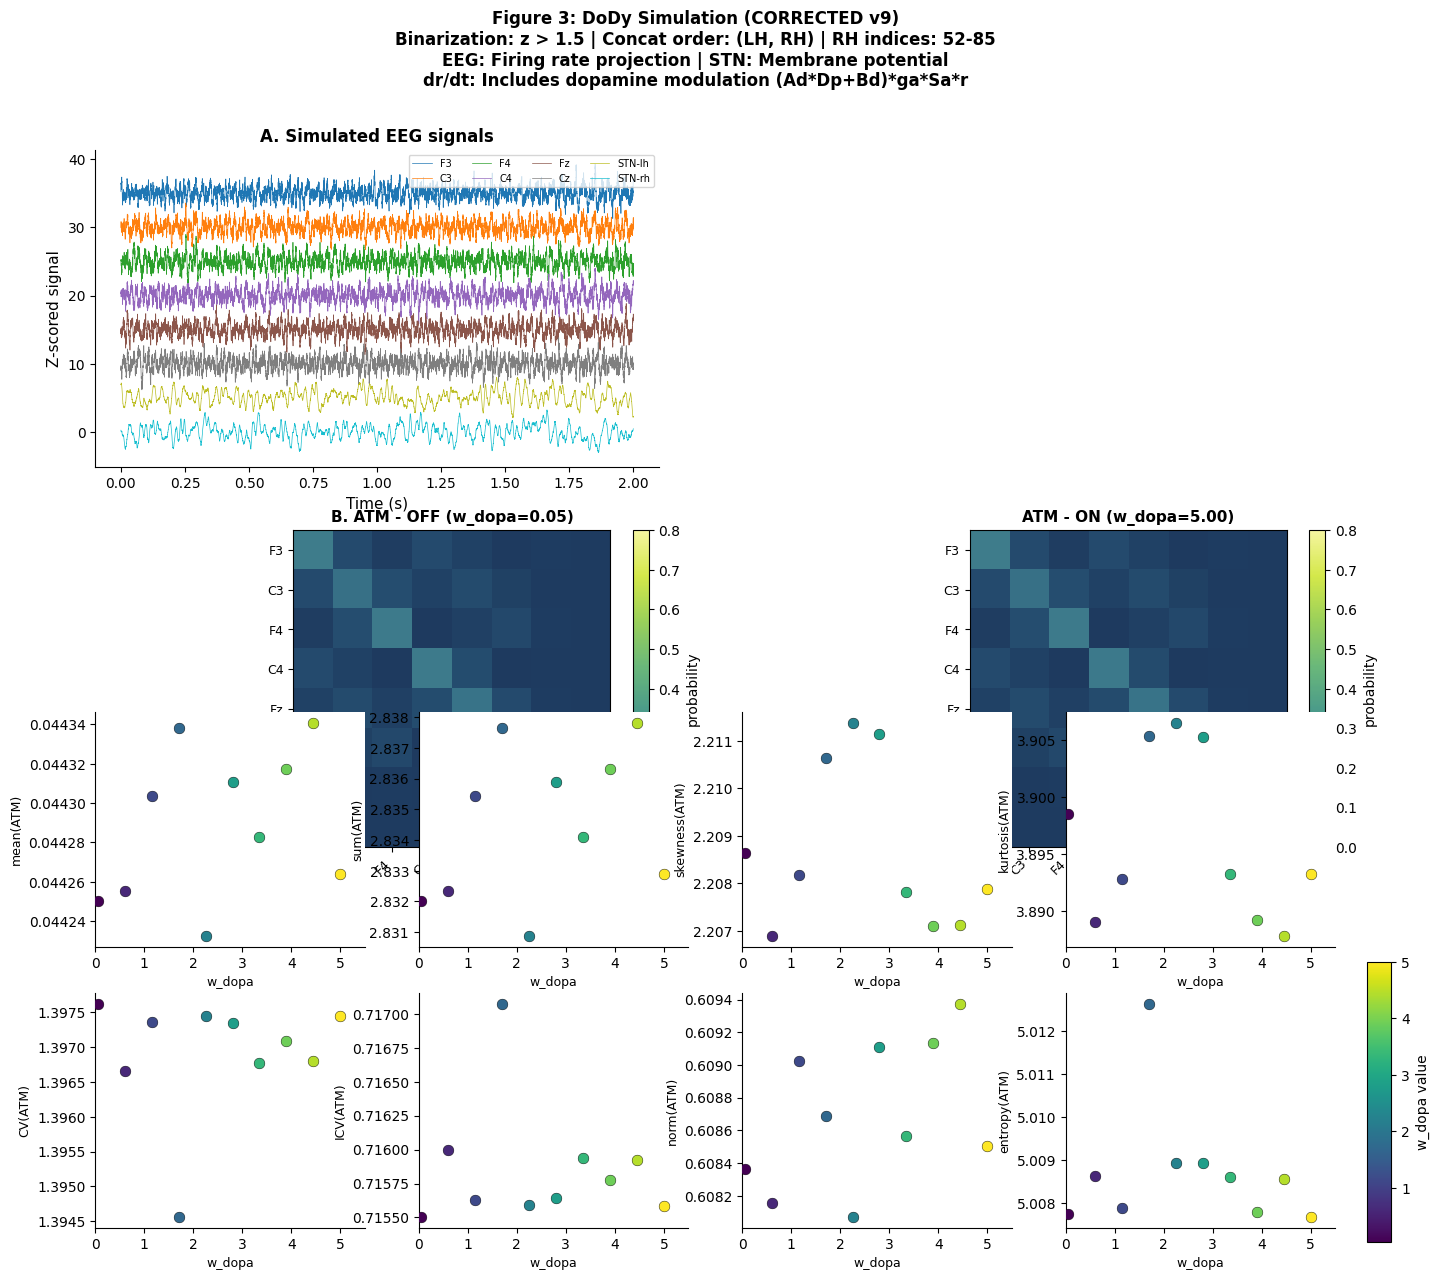

/tmp/ipython-input-688304219.py:955: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


  Saved: /content/figure3c_features_corrected_v9.png


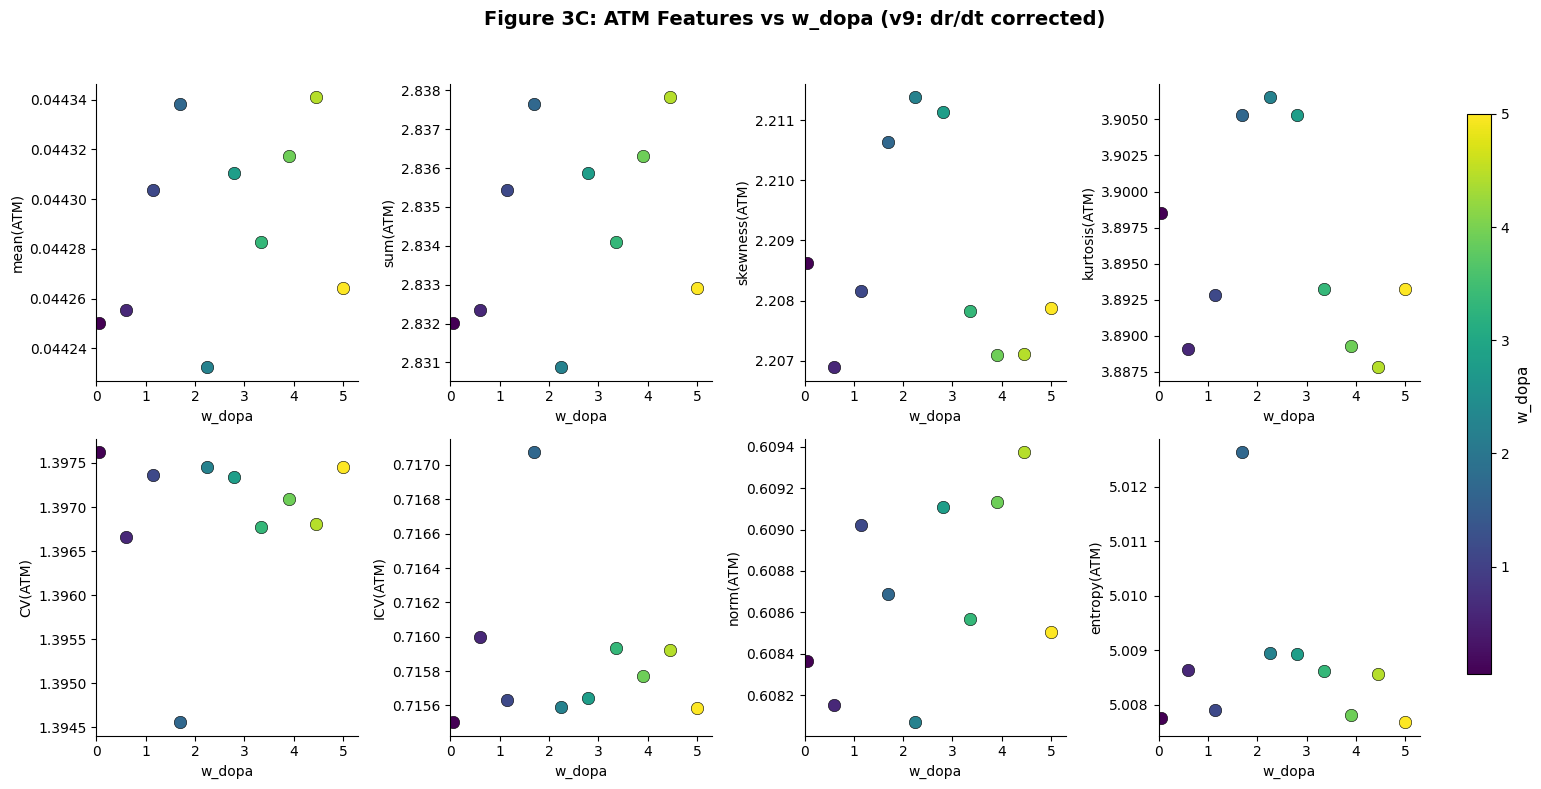

  Saved: /content/atm_progression_corrected_v9.png


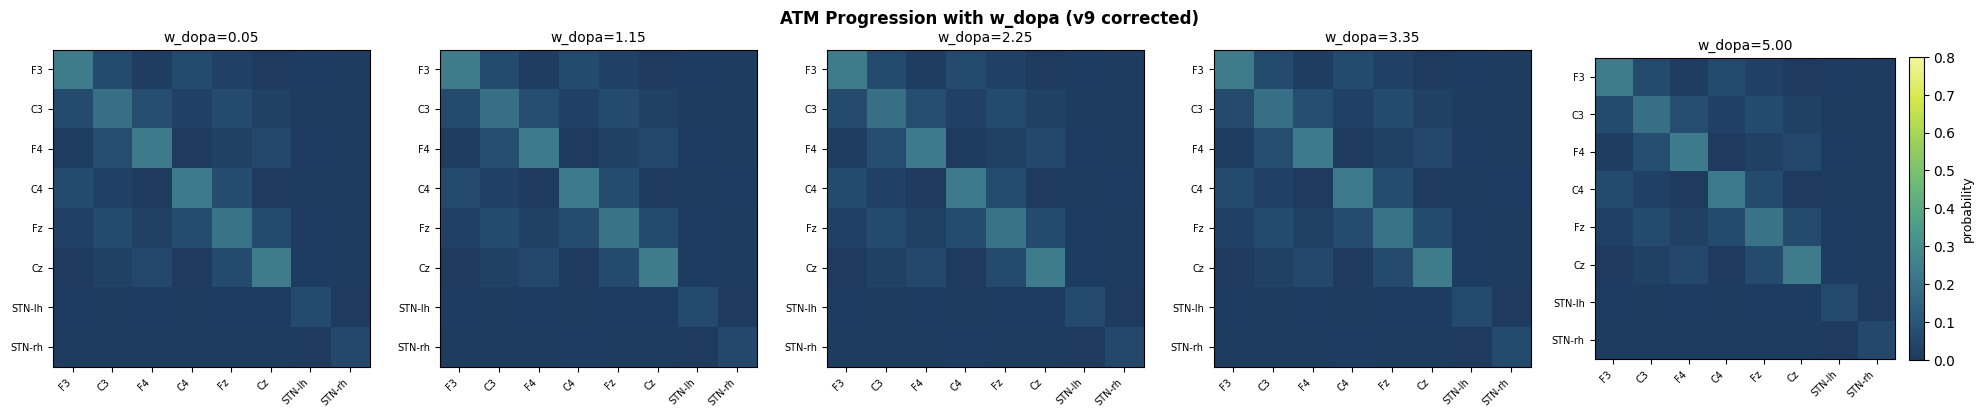


SIMULATION COMPLETE

Results Summary:
------------------------------------------------------------------------------------------
w_dopa     n_aval   mean       sum        skew       kurt       CV         ICV       
------------------------------------------------------------------------------------------
0.05       7467     0.0443     2.8320     2.2086     3.8985     1.3976     0.7155    
0.60       7471     0.0443     2.8323     2.2069     3.8891     1.3967     0.7160    
1.15       7472     0.0443     2.8354     2.2082     3.8928     1.3974     0.7156    
1.70       7472     0.0443     2.8376     2.2106     3.9053     1.3946     0.7171    
2.25       7479     0.0442     2.8309     2.2114     3.9065     1.3974     0.7156    
2.80       7454     0.0443     2.8359     2.2111     3.9053     1.3973     0.7156    
3.35       7461     0.0443     2.8341     2.2078     3.8932     1.3968     0.7159    
3.90       7456     0.0443     2.8363     2.2071     3.8893     1.3971     0.7158    
4.45 

In [14]:
"""
===============================================================================
DoDy Model Simulation - CORRECTED VERSION v9 (Google Colab)
===============================================================================
Based on Angiolelli et al. 2025 - "The Virtual Parkinsonian Patient"
npj Systems Biology and Applications (2025) 11:40

v9 CORRECTIONS (from v8):
=========================

1. CRITICAL FIX: dr/dt equation now includes dopamine modulation
   - v8 WRONG:   dr/dt = ... - ga*Sa*r - gg*Sg*r ...
   - v9 CORRECT: dr/dt = ... - (Ad*Dp + Bd)*ga*Sa*r - gg*Sg*r ...

   This matches the notebook's aQIFdopa function exactly.

2. Concatenation order: (LH, RH) - matches notebook and leadfield L6

3. Cortical indices: LH=0:34, RH=52:86 - matches notebook compute_LL

4. STN indices: 42 (lh-STN), 45 (rh-STN) - verified correct

5. Binarization: z > 1.5 (paper specification)

6. EEG uses firing rate (r), STN uses membrane potential (V) - per paper

===============================================================================
GOOGLE COLAB VERSION
===============================================================================
"""

import numpy as np
from scipy.stats import zscore, skew, kurtosis
from scipy.signal import detrend
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib import cm
import os
import warnings
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing

# Try to import numba for JIT compilation
try:
    from numba import jit, prange
    NUMBA_AVAILABLE = True
    print("✓ Numba available - using JIT compilation for speedup")
except ImportError:
    NUMBA_AVAILABLE = False
    print("⚠ Numba not available - running without JIT (slower)")
    print("  Install with: !pip install numba")
    def jit(*args, **kwargs):
        def decorator(func):
            return func
        return decorator
    prange = range

# =============================================================================
# CONFIGURATION - GOOGLE COLAB PATHS
# =============================================================================
# Option 1: Files uploaded directly to Colab (default)
LOCAL_ROOT = "/content"

# Option 2: If using Google Drive, uncomment these lines:
# from google.colab import drive
# drive.mount('/content/drive')
# LOCAL_ROOT = "/content/drive/MyDrive"  # Adjust subfolder as needed

# Connectivity matrices
CONN_DOPAMINE_PATH = os.path.join(LOCAL_ROOT, "conn_dopamine.npy")
CONN_EXCITATOR_PATH = os.path.join(LOCAL_ROOT, "conn_excitator.npy")
CONN_INHIBITOR_PATH = os.path.join(LOCAL_ROOT, "conn_inhibitor.npy")

# PRECOMPUTED LEADFIELD MATRIX (from notebook)
LEADFIELD_PATH = os.path.join(LOCAL_ROOT, "L6_regions2channels_abs_sum.npy")

# Output directory
OUTPUT_DIR = LOCAL_ROOT
RANDOM_SEED = 42

# =============================================================================
# MODEL PARAMETERS (Table S1 from paper)
# =============================================================================
a = 0.04          # [1/ms·mV]
b = 5.0           # [1/ms]
c = 140.0         # [mV/ms]
Delta = 1.0       # [mV] - Width parameter
Eta = 18.0        # [mV/ms] - Excitability parameter
Iext = 0.0        # [mV/ms]

# Synaptic parameters
ga = 12.0         # [1/ms]
gg = 12.0         # [1/ms]
Ea = 0.0          # [mV]
Eg = -80.0        # [mV]
tauSa = 5.0       # [ms]
tauSg = 5.0       # [ms]
Sja = 0.8         # [-]
Sjg = 1.2         # [-]
Ja = 0.0          # Local recurrent (set to 0 as in notebook)

# Adaptation parameters
alpha = 0.013     # [1/ms]
beta = 0.4        # [-]
ud = 12.0         # [1/ms]

# Dopamine dynamics (Eq. 6)
k = 10e4          # [1/ms]
Vmax = 1300.0     # [nM/ms]
Km = 50.0         # [nM]
Bd = 0.2          # [-] - Baseline dopamine effect (B_Dp in paper)
Ad = 1.0          # [-] - Dopamine modulation strength (A_Dp in paper)
tau_Dp = 500.0    # [ms]

# =============================================================================
# SIMULATION PARAMETERS
# =============================================================================
SIMULATION_TIME = 30000.0      # 30 seconds in ms
TRANSIENT_TIME = 1000.0        # 1 second transient (paper discards first second)
DT = 0.01                      # Integration step [ms]
SAVE_EVERY = 10                # Save every 10 steps = 0.1 ms resolution

# Noise level for stochastic differential equations
SIGMA = 1e-3

# =============================================================================
# STATE BOUNDS
# =============================================================================
R_MIN, R_MAX = 0.0, 1000.0
V_MIN, V_MAX = -120.0, 60.0
U_MIN, U_MAX = -2000.0, 2000.0
SA_MIN, SA_MAX = 0.0, 20.0
SG_MIN, SG_MAX = 0.0, 20.0
DP_MIN, DP_MAX = 0.0, 2000.0

# =============================================================================
# PARCELLATION AND ELECTRODE CONFIGURATION - MATCHING NOTEBOOK
# =============================================================================
n_nodes = 88

# Cortical indices MATCHING the notebook compute_LL function:
# rr1 = V[:, 0:34, :]   → LH cortical
# rr2 = V[:, 52:86, :]  → RH cortical (indices 52-85)
# reduced_V = np.concatenate((rr1, rr2), axis=1)  → ORDER: (LH, RH)

N_CORTICAL_LH_START = 0         # LH cortical start
N_CORTICAL_LH_END = 34          # LH cortical end (exclusive)
N_CORTICAL_RH_START = 52        # RH cortical start (matches notebook)
N_CORTICAL_RH_END = 86          # RH cortical end (exclusive, matches notebook)

# STN indices from notebook:
# STN_lh_time_series = V[:, 42, :]
# STN_rh_time_series = V[:, 45, :]
STN_LH_IDX = 42  # Left STN (lh-STN in atlas)
STN_RH_IDX = 45  # Right STN (rh-STN in atlas)

# EEG channels - ORDER TO MATCH PAPER FIGURE 3B
# Paper page 3: "F3, C3, F4, C4, Fz, and Cz"
EEG_CHANNELS = ['F3', 'C3', 'F4', 'C4', 'Fz', 'Cz']
DEEP_CHANNELS = ['STN-lh', 'STN-rh']
ALL_CHANNELS = EEG_CHANNELS + DEEP_CHANNELS

# =============================================================================
# ATM PARAMETERS - FROM PAPER
# =============================================================================
# Paper page 3: "set to 1 for z > 1.5, and to 0 otherwise"
THETA = 1.5                    # Threshold value z > 1.5
USE_ABSOLUTE_VALUE = False     # Use z > θ (NOT |z| > θ)

# w_dopa range (matching paper Figure 3C)
WDOPA_MIN = 0.05
WDOPA_MAX = 5.0
N_WDOPA_VALUES = 10  # Number of w_dopa values to sweep

# Number of parallel workers (Colab typically has 2 CPUs)
N_WORKERS = min(2, multiprocessing.cpu_count())

# =============================================================================
# ATM COLORMAP - MATCHING PAPER FIGURE 3B
# =============================================================================
def create_paper_atm_colormap():
    """Create colormap matching paper Figure 3B."""
    colors = [
        '#1e3a5f',  # Dark blue (low probability)
        '#2a5a7a',  # Blue
        '#3d7a8c',  # Teal
        '#4a9a8a',  # Cyan-green
        '#6ab87a',  # Green
        '#9ad05a',  # Yellow-green
        '#d4e84a',  # Yellow (high probability)
        '#f5f5a0'   # Light yellow
    ]
    return LinearSegmentedColormap.from_list('paper_atm', colors, N=256)

ATM_COLORMAP = create_paper_atm_colormap()


# =============================================================================
# CONNECTIVITY LOADING
# =============================================================================
def load_connectivity_matrices():
    """Load the three connectivity matrices."""
    print("\nLoading connectivity matrices...")
    print(f"  Looking in: {LOCAL_ROOT}")

    # Check if files exist
    for path, name in [(CONN_DOPAMINE_PATH, "Dopamine"),
                       (CONN_EXCITATOR_PATH, "Excitatory"),
                       (CONN_INHIBITOR_PATH, "Inhibitory")]:
        if not os.path.exists(path):
            raise FileNotFoundError(
                f"{name} connectivity matrix not found at: {path}\n"
                f"Please upload the file to Colab or check the path."
            )

    conn_dopamine = np.load(CONN_DOPAMINE_PATH).T
    conn_excitator = np.load(CONN_EXCITATOR_PATH).T
    conn_inhibitor = np.load(CONN_INHIBITOR_PATH).T

    print(f"  Dopamine: {conn_dopamine.shape}, {np.count_nonzero(conn_dopamine)} connections")
    print(f"  Excitatory: {conn_excitator.shape}, {np.count_nonzero(conn_excitator)} connections")
    print(f"  Inhibitory: {conn_inhibitor.shape}, {np.count_nonzero(conn_inhibitor)} connections")

    return conn_dopamine, conn_excitator, conn_inhibitor


# =============================================================================
# LEADFIELD MATRIX - PRECOMPUTED
# =============================================================================
def load_precomputed_leadfield():
    """Load precomputed leadfield matrix."""
    print("\n" + "="*60)
    print("LOADING PRECOMPUTED LEADFIELD MATRIX")
    print("="*60)

    if os.path.exists(LEADFIELD_PATH):
        L = np.load(LEADFIELD_PATH)
        print(f"  Loaded leadfield from: {LEADFIELD_PATH}")
        print(f"  Leadfield shape: {L.shape}")
        print(f"  Expected: (6 channels, 68 cortical regions)")
        print(f"  Leadfield columns 0-33:  LH sources")
        print(f"  Leadfield columns 34-67: RH sources")
        return L
    else:
        raise FileNotFoundError(
            f"Precomputed leadfield matrix not found at: {LEADFIELD_PATH}\n"
            "Please upload L6_regions2channels_abs_sum.npy to Colab."
        )


# =============================================================================
# OPTIMIZED DoDy MODEL DYNAMICS WITH NUMBA JIT - v9 CORRECTED
# =============================================================================
@jit(nopython=True, fastmath=True)
def dody_derivatives_numba(r, V, u, Sa, Sg, Dp,
                           coupling_inh, coupling_exc, coupling_dopa,
                           n_nodes_local):
    """
    DoDy model derivatives - Numba optimized version.

    v9 CRITICAL FIX: dr/dt now includes dopamine modulation factor (Ad*Dp + Bd)
    on the AMPA conductance term, matching the notebook's aQIFdopa function.

    Equations from paper and notebook:

    dr/dt = 2*a*r*V + b*r - (Ad*Dp + Bd)*ga*Sa*r - gg*Sg*r + (a*Delta)/pi

    dV/dt = a*V^2 + b*V + c + Eta - (pi^2*r^2)/a
            + (Ad*Dp + Bd)*ga*Sa*(Ea - V) + gg*Sg*(Eg - V) + Iext - u

    du/dt = alpha*(beta*V - u) + ud*r

    dSa/dt = -Sa/tauSa + Sja*coupling_exc + Ja*r

    dSg/dt = -Sg/tauSg + Sjg*coupling_inh

    dDp/dt = (k*coupling_dopa - Vmax*Dp/(Km + Dp)) / tau_Dp
    """
    # Constants (hardcoded for Numba nopython mode)
    a_local = 0.04
    b_local = 5.0
    c_local = 140.0
    Delta_local = 1.0
    Eta_local = 18.0
    Iext_local = 0.0
    ga_local = 12.0
    gg_local = 12.0
    Ea_local = 0.0
    Eg_local = -80.0
    tauSa_local = 5.0
    tauSg_local = 5.0
    Sja_local = 0.8
    Sjg_local = 1.2
    Ja_local = 0.0          # Local recurrent (0 as in notebook)
    alpha_local = 0.013
    beta_local = 0.4
    ud_local = 12.0
    k_local = 10e4
    Vmax_local = 1300.0
    Km_local = 50.0
    Bd_local = 0.2          # Baseline dopamine effect
    Ad_local = 1.0          # Dopamine modulation strength
    tau_Dp_local = 500.0
    pi = 3.141592653589793

    # Allocate output arrays
    dr = np.empty(n_nodes_local)
    dV = np.empty(n_nodes_local)
    du = np.empty(n_nodes_local)
    dSa = np.empty(n_nodes_local)
    dSg = np.empty(n_nodes_local)
    dDp = np.empty(n_nodes_local)

    for i in range(n_nodes_local):
        # Dopamine modulation factor: (Ad * Dp + Bd)
        # This modulates the AMPA conductance in BOTH dr/dt AND dV/dt
        dopa_factor = Ad_local * Dp[i] + Bd_local

        # =================================================================
        # dr/dt - FIRING RATE DYNAMICS
        # =================================================================
        # v9 CORRECTION: Include dopa_factor on the AMPA term (ga*Sa*r)
        # This matches the notebook: - (Ad * Dp + Bd) * ga * Sa * r
        dr[i] = (2.0 * a_local * r[i] * V[i]
                 + b_local * r[i]
                 - dopa_factor * ga_local * Sa[i] * r[i]   # CORRECTED: now includes dopa_factor
                 - gg_local * Sg[i] * r[i]
                 + (a_local * Delta_local) / pi)

        # =================================================================
        # dV/dt - MEMBRANE POTENTIAL DYNAMICS
        # =================================================================
        dV[i] = (a_local * V[i] * V[i]
                 + b_local * V[i]
                 + c_local
                 + Eta_local
                 - (pi * pi * r[i] * r[i]) / a_local
                 + dopa_factor * ga_local * Sa[i] * (Ea_local - V[i])
                 + gg_local * Sg[i] * (Eg_local - V[i])
                 + Iext_local
                 - u[i])

        # =================================================================
        # du/dt - ADAPTATION DYNAMICS
        # =================================================================
        du[i] = alpha_local * (beta_local * V[i] - u[i]) + ud_local * r[i]

        # =================================================================
        # dSa/dt - AMPA SYNAPTIC GATING
        # =================================================================
        dSa[i] = -Sa[i] / tauSa_local + Sja_local * coupling_exc[i] + Ja_local * r[i]

        # =================================================================
        # dSg/dt - GABA SYNAPTIC GATING
        # =================================================================
        dSg[i] = -Sg[i] / tauSg_local + Sjg_local * coupling_inh[i]

        # =================================================================
        # dDp/dt - DOPAMINE DYNAMICS (Michaelis-Menten kinetics)
        # =================================================================
        dDp[i] = (k_local * coupling_dopa[i] - Vmax_local * Dp[i] / (Km_local + Dp[i] + 1e-10)) / tau_Dp_local

    return dr, dV, du, dSa, dSg, dDp


@jit(nopython=True, fastmath=True)
def apply_bounds_numba(r, V, u, Sa, Sg, Dp):
    """Apply physiological bounds to state variables."""
    r = np.clip(r, 0.0, 1000.0)
    V = np.clip(V, -120.0, 60.0)
    u = np.clip(u, -2000.0, 2000.0)
    Sa = np.clip(Sa, 0.0, 20.0)
    Sg = np.clip(Sg, 0.0, 20.0)
    Dp = np.clip(Dp, 0.0, 2000.0)
    return r, V, u, Sa, Sg, Dp


@jit(nopython=True, fastmath=True)
def simulate_dody_core(conn_inh, conn_exc, conn_dopa,
                       c_inh, c_exc, c_dopa,
                       n_nodes_local, n_steps, n_save, save_every,
                       dt, sigma, transient_steps,
                       seed):
    """
    Core simulation loop - Numba JIT compiled.

    Uses Heun's method (improved Euler) for stochastic differential equations.
    """
    np.random.seed(seed)

    # Initial conditions with heterogeneity
    r = 0.05 + 0.02 * np.random.randn(n_nodes_local)
    r = np.clip(r, 0.01, 0.2)
    V = -65.0 + 5.0 * np.random.randn(n_nodes_local)
    V = np.clip(V, -80.0, -50.0)
    u = np.zeros(n_nodes_local)
    Sa = 0.01 * np.abs(np.random.randn(n_nodes_local))
    Sg = 0.01 * np.abs(np.random.randn(n_nodes_local))
    Dp = 0.1 + 0.05 * np.abs(np.random.randn(n_nodes_local))

    # Storage arrays (post-transient only)
    n_save_post = n_save - transient_steps
    t_all = np.zeros(n_save_post)
    V_all = np.zeros((n_save_post, n_nodes_local))
    r_all = np.zeros((n_save_post, n_nodes_local))

    t = 0.0
    save_idx = 0
    sqrt_dt = np.sqrt(dt)

    for step in range(n_steps):
        # Compute coupling terms
        coupling_inh = c_inh * (conn_inh @ r)
        coupling_exc = c_exc * (conn_exc @ r)
        coupling_dopa = c_dopa * (conn_dopa @ r)

        # Generate noise
        noise_r = sigma * np.random.randn(n_nodes_local) * sqrt_dt
        noise_V = sigma * 10 * np.random.randn(n_nodes_local) * sqrt_dt

        # Heun's method: predictor step
        dr1, dV1, du1, dSa1, dSg1, dDp1 = dody_derivatives_numba(
            r, V, u, Sa, Sg, Dp, coupling_inh, coupling_exc, coupling_dopa, n_nodes_local)

        r_pred = r + dt * dr1 + noise_r
        V_pred = V + dt * dV1 + noise_V
        u_pred = u + dt * du1
        Sa_pred = Sa + dt * dSa1
        Sg_pred = Sg + dt * dSg1
        Dp_pred = Dp + dt * dDp1

        # Apply bounds to predictor
        r_pred, V_pred, u_pred, Sa_pred, Sg_pred, Dp_pred = apply_bounds_numba(
            r_pred, V_pred, u_pred, Sa_pred, Sg_pred, Dp_pred)

        # Recompute coupling for predictor
        coupling_inh_pred = c_inh * (conn_inh @ r_pred)
        coupling_exc_pred = c_exc * (conn_exc @ r_pred)
        coupling_dopa_pred = c_dopa * (conn_dopa @ r_pred)

        # Heun's method: corrector step
        dr2, dV2, du2, dSa2, dSg2, dDp2 = dody_derivatives_numba(
            r_pred, V_pred, u_pred, Sa_pred, Sg_pred, Dp_pred,
            coupling_inh_pred, coupling_exc_pred, coupling_dopa_pred, n_nodes_local)

        # Update state with averaged derivatives
        r = r + 0.5 * dt * (dr1 + dr2) + noise_r
        V = V + 0.5 * dt * (dV1 + dV2) + noise_V
        u = u + 0.5 * dt * (du1 + du2)
        Sa = Sa + 0.5 * dt * (dSa1 + dSa2)
        Sg = Sg + 0.5 * dt * (dSg1 + dSg2)
        Dp = Dp + 0.5 * dt * (dDp1 + dDp2)

        # Apply bounds
        r, V, u, Sa, Sg, Dp = apply_bounds_numba(r, V, u, Sa, Sg, Dp)
        t += dt

        # Save at specified intervals (after transient)
        if (step + 1) % save_every == 0:
            current_save_idx = (step + 1) // save_every - 1
            if current_save_idx >= transient_steps and save_idx < n_save_post:
                t_all[save_idx] = t
                V_all[save_idx, :] = V
                r_all[save_idx, :] = r
                save_idx += 1

    return t_all, V_all, r_all


def simulate_dody(conn_inh, conn_exc, conn_dopa,
                  c_inh=0.07, c_exc=0.07, c_dopa=0.7,
                  random_seed=RANDOM_SEED, verbose=True):
    """
    Simulate DoDy model using optimized Numba core.

    Parameters:
    -----------
    conn_inh : ndarray (88, 88)
        Inhibitory connectivity matrix
    conn_exc : ndarray (88, 88)
        Excitatory connectivity matrix
    conn_dopa : ndarray (88, 88)
        Dopaminergic connectivity matrix
    c_inh : float
        Inhibitory coupling weight
    c_exc : float
        Excitatory coupling weight
    c_dopa : float
        Dopaminergic coupling weight (w_dopa in paper)
    random_seed : int
        Random seed for reproducibility
    verbose : bool
        Print progress information

    Returns:
    --------
    t_all : ndarray
        Time points (ms)
    V_all : ndarray (n_times, 88)
        Membrane potentials
    r_all : ndarray (n_times, 88)
        Firing rates
    """
    if verbose:
        print(f"  Simulating (w_dopa={c_dopa:.3f})...", end=" ", flush=True)

    n_steps = int(SIMULATION_TIME / DT)
    n_save = n_steps // SAVE_EVERY
    transient_steps = int(TRANSIENT_TIME / (DT * SAVE_EVERY))

    t_all, V_all, r_all = simulate_dody_core(
        conn_inh, conn_exc, conn_dopa,
        c_inh, c_exc, c_dopa,
        n_nodes, n_steps, n_save, SAVE_EVERY,
        DT, SIGMA, transient_steps,
        random_seed
    )

    if verbose:
        print(f"done. Shape: {V_all.shape}")

    return t_all, V_all, r_all


# =============================================================================
# SIGNAL COMPUTATION - MATCHING NOTEBOOK
# =============================================================================
def compute_eeg_signals(r, L):
    """
    Compute EEG signals via leadfield projection.

    Uses FIRING RATE (r) as per paper page 9:
    "firing rates are translated using the lead field matrix"

    Cortical indices match notebook compute_LL function:
    - LH: indices 0-33 (34 regions)
    - RH: indices 52-85 (34 regions)
    - Concatenation order: (LH, RH) to match L6 columns

    Args:
        r: Firing rates, shape (n_times, n_nodes)
        L: Leadfield matrix, shape (6 channels, 68 cortical regions)
           - Columns 0-33:  expect LH sources
           - Columns 34-67: expect RH sources

    Returns:
        EEG signals, shape (n_times, 6), z-scored
    """
    # Extract cortical regions MATCHING notebook indices
    r_lh = r[:, N_CORTICAL_LH_START:N_CORTICAL_LH_END]  # indices 0-33 (34 regions)
    r_rh = r[:, N_CORTICAL_RH_START:N_CORTICAL_RH_END]  # indices 52-85 (34 regions)

    # Concatenate as (LH, RH) to match leadfield column order
    r_cortical = np.concatenate([r_lh, r_rh], axis=1)  # Shape: (n_times, 68)

    # Project to sensor space: EEG = L @ r_cortical.T
    eeg_raw = (L @ r_cortical.T).T  # Shape: (n_times, 6)

    # Z-score normalize per channel
    eeg_signals = zscore(eeg_raw, axis=0)

    return eeg_signals


def compute_stn_signals(V):
    """
    Compute STN deep electrode signals using membrane potential.

    Paper (page 3): "As per the STN, simulated voltages are compared directly"

    Notebook: STN_lh_time_series = V[:, 42, :]
              STN_rh_time_series = V[:, 45, :]

    Args:
        V: Membrane potentials, shape (n_times, n_nodes)

    Returns:
        STN signals, shape (n_times, 2), z-scored
    """
    stn_V = np.column_stack([V[:, STN_LH_IDX], V[:, STN_RH_IDX]])
    stn_signals = zscore(stn_V, axis=0)
    return stn_signals


def combine_signals(eeg, stn):
    """
    Combine EEG (6 channels) and STN (2 channels) into 8-channel array.
    Order: F3, C3, F4, C4, Fz, Cz, STN-lh, STN-rh
    """
    return np.concatenate([eeg, stn], axis=1)


# =============================================================================
# ATM COMPUTATION
# =============================================================================
@jit(nopython=True)
def binarize_signals_numba(signals, theta, use_absolute):
    """Binarize z-scored signals using threshold."""
    n_times, n_channels = signals.shape
    binary = np.zeros((n_times, n_channels), dtype=np.int32)

    for t in range(n_times):
        for ch in range(n_channels):
            if use_absolute:
                if np.abs(signals[t, ch]) > theta:
                    binary[t, ch] = 1
            else:
                if signals[t, ch] > theta:
                    binary[t, ch] = 1

    return binary


@jit(nopython=True)
def detect_avalanches_numba(binary_matrix_T, min_duration=2):
    """Detect avalanches from binarized activity."""
    n_channels, n_times = binary_matrix_T.shape

    max_avalanches = n_times // 2 + 1
    starts = np.empty(max_avalanches, dtype=np.int32)
    ends = np.empty(max_avalanches, dtype=np.int32)
    n_avalanches = 0

    # Check if any channel is active at each time point
    any_active = np.zeros(n_times, dtype=np.int32)
    for t in range(n_times):
        for ch in range(n_channels):
            if binary_matrix_T[ch, t] == 1:
                any_active[t] = 1
                break

    # Find avalanche boundaries
    in_avalanche = False
    start_idx = 0

    for t in range(n_times):
        if any_active[t] == 1 and not in_avalanche:
            in_avalanche = True
            start_idx = t
        elif any_active[t] == 0 and in_avalanche:
            in_avalanche = False
            duration = t - start_idx
            if duration >= min_duration:
                starts[n_avalanches] = start_idx
                ends[n_avalanches] = t
                n_avalanches += 1

    # Handle avalanche at end of recording
    if in_avalanche:
        duration = n_times - start_idx
        if duration >= min_duration:
            starts[n_avalanches] = start_idx
            ends[n_avalanches] = n_times
            n_avalanches += 1

    return starts[:n_avalanches], ends[:n_avalanches], n_avalanches


@jit(nopython=True)
def compute_transition_matrix_vectorized(binary_avalanche):
    """
    Compute transition probability matrix for one avalanche.

    T[i,j] = P(j active at t+1 | i active at t)
    """
    n_channels, n_times = binary_avalanche.shape
    T = np.zeros((n_channels, n_channels))

    if n_times < 2:
        return T

    for i in range(n_channels):
        n_activations = 0
        for t in range(n_times - 1):
            if binary_avalanche[i, t] == 1:
                n_activations += 1
                for j in range(n_channels):
                    T[i, j] += binary_avalanche[j, t + 1]

        if n_activations > 0:
            for j in range(n_channels):
                T[i, j] /= n_activations

    return T


def compute_ATM(combined_signals, theta=THETA, use_absolute=USE_ABSOLUTE_VALUE, verbose=True):
    """
    Compute Avalanche Transition Matrix (ATM).

    Paper page 3: "set to 1 for z > 1.5, and to 0 otherwise"

    Parameters:
    -----------
    combined_signals : ndarray (n_times, 8)
        Z-scored signals for all channels
    theta : float
        Binarization threshold
    use_absolute : bool
        If True, use |z| > theta; if False, use z > theta
    verbose : bool
        Print diagnostic information

    Returns:
    --------
    ATM_symmetric : ndarray (8, 8)
        Symmetric transition probability matrix
    n_avalanches : int
        Number of detected avalanches
    mean_dur : float
        Mean avalanche duration
    """
    if verbose:
        threshold_str = f"|z|>{theta}" if use_absolute else f"z>{theta}"
        print(f"    Computing ATM (theta={theta}, {threshold_str}):")

    if np.all(np.isnan(combined_signals)):
        if verbose:
            print("      ERROR: All NaN signals")
        return np.zeros((8, 8)), 0, 0

    # Binarize signals
    binary = binarize_signals_numba(combined_signals, theta, use_absolute)

    if verbose:
        threshold_str = f"|z|>{theta}" if use_absolute else f"z>{theta}"
        print(f"      Per-channel activations ({threshold_str}):")
        for i, ch in enumerate(ALL_CHANNELS):
            n_active = np.sum(binary[:, i])
            pct = 100.0 * n_active / len(binary)
            print(f"        {ch}: {n_active} samples ({pct:.1f}%)")

    # Detect avalanches
    binary_T = binary.T.astype(np.int32)
    starts, ends, n_avalanches = detect_avalanches_numba(binary_T, min_duration=2)

    if verbose:
        print(f"      Detected {n_avalanches} avalanches")

    if n_avalanches == 0:
        if verbose:
            print("      WARNING: No avalanches detected!")
        return np.zeros((8, 8)), 0, 0

    # Compute transition matrices for each avalanche
    TMs = np.zeros((n_avalanches, 8, 8))
    durations = np.zeros(n_avalanches)

    for idx in range(n_avalanches):
        aval = binary_T[:, starts[idx]:ends[idx]]
        TMs[idx] = compute_transition_matrix_vectorized(aval)
        durations[idx] = ends[idx] - starts[idx]

    # Average across avalanches
    ATM_averaged = np.mean(TMs, axis=0)

    # Symmetrize: (T + T.T) / 2
    ATM_symmetric = (ATM_averaged + ATM_averaged.T) / 2

    mean_dur = np.mean(durations)
    if verbose:
        print(f"      Mean avalanche duration: {mean_dur:.1f} samples")
        print(f"      ATM diagonal mean: {np.mean(np.diag(ATM_symmetric)):.3f}")
        print(f"      ATM off-diagonal mean: {np.mean(ATM_symmetric[~np.eye(8, dtype=bool)]):.3f}")

    return ATM_symmetric, n_avalanches, mean_dur


# =============================================================================
# FEATURE EXTRACTION
# =============================================================================
def compute_shannon_entropy(atm):
    """Compute Shannon entropy of ATM."""
    atm_flat = atm.flatten()
    total = np.sum(atm_flat)
    if total <= 0:
        return 0.0
    p = atm_flat / total
    p = p[p > 0]
    entropy = -np.sum(p * np.log2(p))
    return entropy


def extract_atm_features_figure3c(atm):
    """Extract the 8 features shown in Figure 3C."""
    atm_flat = atm.flatten()

    mean_atm = np.mean(atm_flat)
    sum_atm = np.sum(atm_flat)
    skewness_atm = skew(atm_flat)
    kurtosis_atm = kurtosis(atm_flat)
    std_atm = np.std(atm_flat)
    cv_atm = std_atm / mean_atm if mean_atm > 0 else 0.0
    icv_atm = mean_atm / std_atm if std_atm > 0 else 0.0
    norm_atm = np.linalg.norm(atm, 'fro')
    entropy_atm = compute_shannon_entropy(atm)

    return {
        'mean_atm': mean_atm,
        'sum_atm': sum_atm,
        'skewness_atm': skewness_atm,
        'kurtosis_atm': kurtosis_atm,
        'cv_atm': cv_atm,
        'icv_atm': icv_atm,
        'norm_atm': norm_atm,
        'entropy_atm': entropy_atm
    }


# =============================================================================
# VISUALIZATION
# =============================================================================
def plot_atm_paper_style(atm, title, ax, vmin=0, vmax=0.8):
    """Plot ATM matrix matching paper Figure 3B style."""
    im = ax.imshow(atm, cmap=ATM_COLORMAP, aspect='equal',
                   vmin=vmin, vmax=vmax, interpolation='nearest')

    ax.set_xticks(range(8))
    ax.set_yticks(range(8))
    ax.set_xticklabels(ALL_CHANNELS, fontsize=9, rotation=45, ha='right')
    ax.set_yticklabels(ALL_CHANNELS, fontsize=9)
    ax.set_title(title, fontsize=11, fontweight='bold')

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('probability', fontsize=10)
    return im


def plot_figure3_paper_style(t_all, combined_signals_list, features_list,
                              wdopa_values, output_path):
    """Generate Figure 3 matching paper style."""
    print("\nGenerating Figure 3 (paper style)...")

    fig = plt.figure(figsize=(16, 14))
    fig.suptitle(f'Figure 3: DoDy Simulation (CORRECTED v9)\n'
                 f'Binarization: z > {THETA} | Concat order: (LH, RH) | RH indices: 52-85\n'
                 f'EEG: Firing rate projection | STN: Membrane potential\n'
                 f'dr/dt: Includes dopamine modulation (Ad*Dp+Bd)*ga*Sa*r',
                 fontsize=12, fontweight='bold')

    cmap_wdopa = plt.cm.viridis
    colors = cmap_wdopa(np.linspace(0, 1, len(wdopa_values)))

    # Panel A: Time series
    ax1 = fig.add_subplot(3, 2, 1)
    mid_idx = len(wdopa_values) // 2
    signals = combined_signals_list[mid_idx]

    samples_per_sec = int(1000 / (DT * SAVE_EVERY))
    t_start = samples_per_sec
    t_end = t_start + 2 * samples_per_sec
    t_end = min(t_end, len(t_all))
    t_slice = slice(t_start, t_end)
    t_plot = (t_all[t_slice] - t_all[t_start]) / 1000

    channel_colors = plt.cm.tab10(np.linspace(0, 1, 8))
    for i, ch_name in enumerate(ALL_CHANNELS):
        offset = (7 - i) * 5
        ax1.plot(t_plot, signals[t_slice, i] + offset,
                color=channel_colors[i], linewidth=0.5, label=ch_name)

    ax1.set_xlabel('Time (s)', fontsize=11)
    ax1.set_ylabel('Z-scored signal', fontsize=11)
    ax1.set_title('A. Simulated EEG signals', fontsize=12, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=7, ncol=4)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Panel B: ATM matrices
    ax2 = fig.add_subplot(3, 2, 3)
    atm_low = features_list[0]['atm_matrix']
    plot_atm_paper_style(atm_low, f'B. ATM - OFF (w_dopa={wdopa_values[0]:.2f})', ax2)

    ax3 = fig.add_subplot(3, 2, 4)
    atm_high = features_list[-1]['atm_matrix']
    plot_atm_paper_style(atm_high, f'ATM - ON (w_dopa={wdopa_values[-1]:.2f})', ax3)

    # Panel C: Features
    feature_specs = [
        ('mean_atm', 'mean(ATM)'),
        ('sum_atm', 'sum(ATM)'),
        ('skewness_atm', 'skewness(ATM)'),
        ('kurtosis_atm', 'kurtosis(ATM)'),
        ('cv_atm', 'CV(ATM)'),
        ('icv_atm', 'ICV(ATM)'),
        ('norm_atm', 'norm(ATM)'),
        ('entropy_atm', 'entropy(ATM)')
    ]

    for idx, (fname, flabel) in enumerate(feature_specs):
        ax = fig.add_subplot(4, 4, 9 + idx)
        values = [f[fname] for f in features_list]

        for i, (w, v, color) in enumerate(zip(wdopa_values, values, colors)):
            ax.scatter(w, v, c=[color], s=60, edgecolor='k', linewidth=0.3, zorder=3)

        ax.set_xlabel('w_dopa', fontsize=9)
        ax.set_ylabel(flabel, fontsize=9)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim([0, WDOPA_MAX + 0.5])

    sm = plt.cm.ScalarMappable(cmap=cmap_wdopa, norm=Normalize(vmin=WDOPA_MIN, vmax=WDOPA_MAX))
    sm.set_array([])
    cbar_ax = fig.add_axes([0.92, 0.1, 0.015, 0.2])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('w_dopa value', fontsize=10)

    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"  Saved: {output_path}")
    plt.show()
    return fig


def plot_figure3c_only(features_list, wdopa_values, output_path):
    """Plot only Figure 3C."""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(f'Figure 3C: ATM Features vs w_dopa (v9: dr/dt corrected)',
                 fontsize=14, fontweight='bold')

    cmap = plt.cm.viridis
    colors = cmap(np.linspace(0, 1, len(wdopa_values)))

    feature_specs = [
        ('mean_atm', 'mean(ATM)'),
        ('sum_atm', 'sum(ATM)'),
        ('skewness_atm', 'skewness(ATM)'),
        ('kurtosis_atm', 'kurtosis(ATM)'),
        ('cv_atm', 'CV(ATM)'),
        ('icv_atm', 'ICV(ATM)'),
        ('norm_atm', 'norm(ATM)'),
        ('entropy_atm', 'entropy(ATM)')
    ]

    for idx, (fname, flabel) in enumerate(feature_specs):
        ax = axes.flatten()[idx]
        values = [f[fname] for f in features_list]

        for w, v, color in zip(wdopa_values, values, colors):
            ax.scatter(w, v, c=[color], s=80, edgecolor='k', linewidth=0.4)

        ax.set_xlabel('w_dopa', fontsize=10)
        ax.set_ylabel(flabel, fontsize=10)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim([0, WDOPA_MAX + 0.3])

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=WDOPA_MIN, vmax=WDOPA_MAX))
    sm.set_array([])
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('w_dopa', fontsize=11)

    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"  Saved: {output_path}")
    plt.show()


def plot_atm_progression(features_list, wdopa_values, output_path):
    """Plot ATM progression."""
    n_plot = min(5, len(wdopa_values))
    indices = np.linspace(0, len(wdopa_values)-1, n_plot, dtype=int)

    fig, axes = plt.subplots(1, n_plot, figsize=(4*n_plot, 4))
    fig.suptitle(f'ATM Progression with w_dopa (v9 corrected)',
                 fontsize=12, fontweight='bold')

    for ax_idx, cond_idx in enumerate(indices):
        ax = axes[ax_idx]
        atm = features_list[cond_idx]['atm_matrix']
        w = wdopa_values[cond_idx]

        im = ax.imshow(atm, cmap=ATM_COLORMAP, aspect='equal',
                       vmin=0, vmax=0.8, interpolation='nearest')

        ax.set_xticks(range(8))
        ax.set_yticks(range(8))
        ax.set_xticklabels(ALL_CHANNELS, fontsize=7, rotation=45, ha='right')
        ax.set_yticklabels(ALL_CHANNELS, fontsize=7)
        ax.set_title(f'w_dopa={w:.2f}', fontsize=10)

        if ax_idx == n_plot - 1:
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label('probability', fontsize=9)

    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"  Saved: {output_path}")
    plt.show()


# =============================================================================
# PARALLEL SIMULATION HELPER
# =============================================================================
def run_single_simulation(args):
    """Run a single simulation for parallel processing."""
    (idx, c_dopa, conn_inh, conn_exc, conn_dopa, L, random_seed) = args

    t, V, r = simulate_dody(
        conn_inh, conn_exc, conn_dopa,
        c_inh=0.07, c_exc=0.07, c_dopa=c_dopa,
        random_seed=random_seed,
        verbose=False
    )

    eeg = compute_eeg_signals(r, L)
    stn = compute_stn_signals(V)
    combined = combine_signals(eeg, stn)
    atm, n_aval, mean_dur = compute_ATM(combined, THETA, USE_ABSOLUTE_VALUE, verbose=False)

    features = extract_atm_features_figure3c(atm)
    features['atm_matrix'] = atm
    features['n_avalanches'] = n_aval
    features['mean_duration'] = mean_dur

    return idx, t, combined, features


# =============================================================================
# MAIN SIMULATION
# =============================================================================
def run_simulation(use_parallel=False):
    """
    Run complete DoDy simulation pipeline - CORRECTED VERSION v9.

    v9 CORRECTIONS:
    1. dr/dt equation now includes dopamine modulation: (Ad*Dp + Bd)*ga*Sa*r
    2. Concatenation order: (LH, RH) to match notebook and L6
    3. RH indices: 52-85 to match precomputed L6
    4. STN indices: 42 (lh), 45 (rh) - verified correct
    """
    print("="*70)
    print("DoDy MODEL SIMULATION - CORRECTED VERSION v9 (Google Colab)")
    print("="*70)
    print(f"\nv9 CORRECTIONS:")
    print(f"  1. CRITICAL: dr/dt now includes (Ad*Dp + Bd)*ga*Sa*r")
    print(f"     This matches the notebook's aQIFdopa function")
    print(f"  2. Concatenation order: (LH, RH) - matches notebook and L6")
    print(f"  3. RH cortical indices: 52-85 (matching L6 computation)")
    print(f"  4. STN indices: {STN_LH_IDX} (lh), {STN_RH_IDX} (rh) - verified")
    print(f"  5. Binarization: z > {THETA}")
    print(f"  6. EEG uses firing rate, STN uses membrane potential")
    print("="*70)
    print(f"\nData directory: {LOCAL_ROOT}")
    print(f"\nSimulation parameters:")
    print(f"  Simulation time: {SIMULATION_TIME/1000:.0f} seconds")
    print(f"  Transient: {TRANSIENT_TIME/1000:.1f} seconds")
    print(f"  w_dopa range: [{WDOPA_MIN}, {WDOPA_MAX}] with {N_WDOPA_VALUES} values")
    print("="*70)

    # Load connectivity
    conn_dopa, conn_exc, conn_inh = load_connectivity_matrices()

    # Load precomputed leadfield
    L = load_precomputed_leadfield()

    # w_dopa values
    wdopa_values = np.linspace(WDOPA_MIN, WDOPA_MAX, N_WDOPA_VALUES)
    print(f"\nw_dopa values: {wdopa_values}")

    # Storage
    combined_signals_list = [None] * N_WDOPA_VALUES
    features_list = [None] * N_WDOPA_VALUES
    t_all = None

    print("\n" + "-"*50)
    print("Running simulations...")
    print("-"*50)

    if use_parallel and N_WORKERS > 1:
        print(f"Using {N_WORKERS} parallel workers...")

        args_list = [
            (i, c_dopa, conn_inh, conn_exc, conn_dopa, L, RANDOM_SEED)
            for i, c_dopa in enumerate(wdopa_values)
        ]

        with ProcessPoolExecutor(max_workers=N_WORKERS) as executor:
            futures = {executor.submit(run_single_simulation, args): args[0]
                      for args in args_list}

            for future in as_completed(futures):
                idx, t, combined, features = future.result()
                combined_signals_list[idx] = combined
                features_list[idx] = features
                if t_all is None:
                    t_all = t
                print(f"  Completed w_dopa={wdopa_values[idx]:.3f}")
    else:
        for i, c_dopa in enumerate(wdopa_values):
            print(f"\n{'='*50}")
            print(f"Condition {i+1}/{len(wdopa_values)}: w_dopa = {c_dopa:.3f}")
            print("="*50)

            t, V, r = simulate_dody(
                conn_inh, conn_exc, conn_dopa,
                c_inh=0.07, c_exc=0.07, c_dopa=c_dopa,
                random_seed=RANDOM_SEED
            )

            if t_all is None:
                t_all = t

            eeg = compute_eeg_signals(r, L)
            stn = compute_stn_signals(V)
            combined = combine_signals(eeg, stn)
            atm, n_aval, mean_dur = compute_ATM(combined, THETA, USE_ABSOLUTE_VALUE)

            features = extract_atm_features_figure3c(atm)
            features['atm_matrix'] = atm
            features['n_avalanches'] = n_aval
            features['mean_duration'] = mean_dur

            combined_signals_list[i] = combined
            features_list[i] = features

    # Generate figures
    print("\n" + "="*50)
    print("GENERATING FIGURES")
    print("="*50)

    plot_figure3_paper_style(
        t_all, combined_signals_list, features_list, wdopa_values,
        os.path.join(OUTPUT_DIR, "figure3_corrected_v9.png")
    )

    plot_figure3c_only(
        features_list, wdopa_values,
        os.path.join(OUTPUT_DIR, "figure3c_features_corrected_v9.png")
    )

    plot_atm_progression(
        features_list, wdopa_values,
        os.path.join(OUTPUT_DIR, "atm_progression_corrected_v9.png")
    )

    # Save data
    np.save(os.path.join(OUTPUT_DIR, "wdopa_values.npy"), wdopa_values)
    np.save(os.path.join(OUTPUT_DIR, "atm_matrices_corrected_v9.npy"),
            np.array([f['atm_matrix'] for f in features_list]))

    print("\n" + "="*70)
    print("SIMULATION COMPLETE")
    print("="*70)

    # Summary
    print("\nResults Summary:")
    print("-"*90)
    print(f"{'w_dopa':<10} {'n_aval':<8} {'mean':<10} {'sum':<10} {'skew':<10} {'kurt':<10} {'CV':<10} {'ICV':<10}")
    print("-"*90)
    for w, f in list(zip(wdopa_values, features_list))[::max(1, len(wdopa_values)//10)]:
        print(f"{w:<10.2f} {f['n_avalanches']:<8} {f['mean_atm']:<10.4f} {f['sum_atm']:<10.4f} "
              f"{f['skewness_atm']:<10.4f} {f['kurtosis_atm']:<10.4f} {f['cv_atm']:<10.4f} {f['icv_atm']:<10.4f}")

    return {
        'features_list': features_list,
        'combined_signals_list': combined_signals_list,
        'wdopa_values': wdopa_values,
        't': t_all,
        'stn_indices': (STN_LH_IDX, STN_RH_IDX),
        'leadfield': L
    }


# =============================================================================
# ENTRY POINT
# =============================================================================
if __name__ == "__main__":
    results = run_simulation(use_parallel=False)

In [ ]:
"""
===============================================================================
DoDy Model Simulation - CORRECTED VERSION v8 (Google Colab Version)
===============================================================================
Based on Angiolelli et al. 2025 - "The Virtual Parkinsonian Patient"
npj Systems Biology and Applications (2025) 11:40

MODIFICATIONS FOR GOOGLE COLAB:
================================
- Changed LOCAL_ROOT to /content/ for Colab storage
- All connectivity and leadfield matrices should be uploaded to /content/

CORRECTIONS APPLIED (v8):
==========================
1. Binarization: z > θ (positive threshold only, NOT absolute value)
   - Paper page 3: "set to 1 for z > 1.5, and to 0 otherwise"

2. Leadfield: Uses PRECOMPUTED leadfield matrix (L6_regions2channels_abs_sum.npy)

3. STN indices: 42 (left) and 45 (right) as per atlas
   - Index 42 = "lh-STN"
   - Index 45 = "rh-STN"

4. Cortical regions:
   - LH: indices 0-33 (34 regions: L.BSTS to L.IN)
   - RH: indices 51-84 (34 regions: R.BSTS to R.IN)
   - NOTE: Index 85 is R.CER (cerebellum) - NOT cortical!

5. ATM computation:
   - Symmetrize each avalanche TM first, then average (matching original notebook)

6. EEG SIGNALS: Uses FIRING RATE (r) for leadfield projection
   - Paper page 9: "the firing rates of individual brain regions are translated
     to the positions of the six considered electrodes using the lead field matrix"

7. STN SIGNALS: Uses membrane potential (V) directly
   - Paper page 3: "As per the subthalamic nuclei (STN), the simulated voltages
     are compared directly"

8. RANDOM SEED: Same seed used for all w_dopa simulations for consistency

9. ELECTRODE ORDER: Matches paper Figure 3B: F3, C3, F4, C4, Fz, Cz, STN-lh, STN-rh

10. THRESHOLD: θ = 1.5 as per paper page 3

11. CORTICAL CONCATENATION ORDER: [LH, RH] to match leadfield matrix construction
    - v7 used [RH, LH] which was INCORRECT
    - Original notebook uses [LH, RH]: np.concatenate((rr1, rr2), axis=1)

v8 CHANGES FROM v7:
===================
- FIXED: Concatenation order changed from [RH, LH] to [LH, RH]
- FIXED: ATM symmetrization order to match original notebook
- VERIFIED: All indices against atlas structure

ATLAS STRUCTURE (88 regions):
==============================
  0-33:  Left Cortical (34 regions: L.BSTS → L.IN)
  34-39: Left Subcortical (L.CER, L.TH, L.CA, L.PU, L.HI, L.AC)
  40-42: Left Basal Ganglia (lh-GPe, lh-GPi, lh-STN)
  43-45: Right Basal Ganglia (rh-GPe, rh-GPi, rh-STN)
  46-50: Right Subcortical (R.TH, R.CA, R.PU, R.HI, R.AC)
  51-84: Right Cortical (34 regions: R.BSTS → R.IN)
  85:    R.CER (Right Cerebellum - NOT cortical!)
  86-87: Substantia Nigra (LH, RH)

===============================================================================
"""

import numpy as np
from scipy.stats import zscore, skew, kurtosis
from scipy.signal import detrend
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib import cm
import os
import warnings
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing

# Try to import numba for JIT compilation
try:
    from numba import jit, prange
    NUMBA_AVAILABLE = True
    print("✓ Numba available - using JIT compilation for speedup")
except ImportError:
    NUMBA_AVAILABLE = False
    print("⚠ Numba not available - running without JIT (slower)")
    def jit(*args, **kwargs):
        def decorator(func):
            return func
        return decorator
    prange = range

# =============================================================================
# CONFIGURATION - MODIFIED FOR GOOGLE COLAB
# =============================================================================
# Google Colab storage path
LOCAL_ROOT = "/content"

# Connectivity matrices (upload these to /content/ in Colab)
CONN_DOPAMINE_PATH = os.path.join(LOCAL_ROOT, "conn_dopamine.npy")
CONN_EXCITATOR_PATH = os.path.join(LOCAL_ROOT, "conn_excitator.npy")
CONN_INHIBITOR_PATH = os.path.join(LOCAL_ROOT, "conn_inhibitor.npy")

# PRECOMPUTED LEADFIELD MATRIX (upload to /content/ in Colab)
LEADFIELD_PATH = os.path.join(LOCAL_ROOT, "L6_regions2channels_abs_sum.npy")

OUTPUT_DIR = LOCAL_ROOT
RANDOM_SEED = 42

# =============================================================================
# MODEL PARAMETERS (Table S1 from paper)
# =============================================================================
a = 0.04          # [1/ms·mV]
b = 5.0           # [1/ms]
c = 140.0         # [mV/ms]
Delta = 1.0       # [mV] - Width parameter
Eta = 18.0        # [mV/ms] - Excitability parameter
Iext = 0.0        # [mV/ms]

# Synaptic parameters
ga = 12.0         # [1/ms]
gg = 12.0         # [1/ms]
Ea = 0.0          # [mV]
Eg = -80.0        # [mV]
tauSa = 5.0       # [ms]
tauSg = 5.0       # [ms]
Sja = 0.8         # [-]
Sjg = 1.2         # [-]
Ja = 0.0          # Local recurrent

# Adaptation parameters
alpha = 0.013     # [1/ms]
beta = 0.4        # [-]
ud = 12.0         # [1/ms]

# Dopamine dynamics (Eq. 6)
k = 10e4          # [1/ms]
Vmax = 1300.0     # [nM/ms]
Km = 50.0         # [nM]
Bd = 0.2          # [-] - Baseline dopamine effect (B_Dp in paper)
Ad = 1.0          # [-] - Dopamine modulation strength (A_Dp in paper)
tau_Dp = 500.0    # [ms]

# =============================================================================
# SIMULATION PARAMETERS
# =============================================================================
SIMULATION_TIME = 30000.0      # 30 seconds in ms
TRANSIENT_TIME = 1000.0        # 1 second transient (paper discards first second)
DT = 0.01                      # Integration step [ms]
SAVE_EVERY = 10                # Save every 10 steps = 0.1 ms resolution

# Noise level for stochastic differential equations
SIGMA = 1e-3

# =============================================================================
# STATE BOUNDS
# =============================================================================
R_MIN, R_MAX = 0.0, 1000.0
V_MIN, V_MAX = -120.0, 60.0
U_MIN, U_MAX = -2000.0, 2000.0
SA_MIN, SA_MAX = 0.0, 20.0
SG_MIN, SG_MAX = 0.0, 20.0
DP_MIN, DP_MAX = 0.0, 2000.0

# =============================================================================
# PARCELLATION AND ELECTRODE CONFIGURATION
# =============================================================================
n_nodes = 88

# Cortical region indices (VERIFIED against atlas)
# Left Hemisphere Cortical: indices 0-33 (34 regions)
N_CORTICAL_LH = 34
N_CORTICAL_LH_START = 0
N_CORTICAL_LH_END = 34          # Python slice end (exclusive)

# Right Hemisphere Cortical: indices 51-84 (34 regions)
# NOTE: Index 85 is R.CER (cerebellum) - NOT included!
N_CORTICAL_RH = 34
N_CORTICAL_RH_START = 51
N_CORTICAL_RH_END = 85          # Python slice end (exclusive)

# STN indices (VERIFIED against atlas)
# Index 42 = "lh-STN"
# Index 45 = "rh-STN"
STN_LH_IDX = 42
STN_RH_IDX = 45

# EEG channels - ORDER TO MATCH PAPER FIGURE 3B EXACTLY
# Paper page 3: "F3, C3, F4, C4, Fz, and Cz"
EEG_CHANNELS = ['F3', 'C3', 'F4', 'C4', 'Fz', 'Cz']
DEEP_CHANNELS = ['STN-lh', 'STN-rh']
ALL_CHANNELS = EEG_CHANNELS + DEEP_CHANNELS

# =============================================================================
# ATM PARAMETERS - FROM PAPER
# =============================================================================
# Paper page 3: "set to 1 for z > 1.5, and to 0 otherwise"
THETA = 1.5                    # Threshold value z > 1.5
USE_ABSOLUTE_VALUE = False     # Use z > θ (NOT |z| > θ)

# w_dopa range (matching paper Figure 3C)
WDOPA_MIN = 0.05
WDOPA_MAX = 5.0
N_WDOPA_VALUES = 10  # Number of w_dopa values to sweep

# Number of parallel workers
N_WORKERS = min(4, multiprocessing.cpu_count())

# =============================================================================
# ATM COLORMAP - MATCHING PAPER FIGURE 3B EXACTLY
# =============================================================================
def create_paper_atm_colormap():
    """
    Create colormap matching paper Figure 3B exactly.
    Paper uses: dark blue -> teal/cyan -> green -> yellow
    """
    colors = [
        '#1e3a5f',  # Dark blue (low probability)
        '#2a5a7a',  # Blue
        '#3d7a8c',  # Teal
        '#4a9a8a',  # Cyan-green
        '#6ab87a',  # Green
        '#9ad05a',  # Yellow-green
        '#d4e84a',  # Yellow (high probability)
        '#f5f5a0'   # Light yellow
    ]
    return LinearSegmentedColormap.from_list('paper_atm', colors, N=256)

ATM_COLORMAP = create_paper_atm_colormap()
ATM_COLORMAP_NAME = 'paper_atm'


# =============================================================================
# CONNECTIVITY LOADING
# =============================================================================
def load_connectivity_matrices():
    """Load the three connectivity matrices."""
    print("\nLoading connectivity matrices...")

    # Check if files exist
    for path, name in [(CONN_DOPAMINE_PATH, "conn_dopamine.npy"),
                       (CONN_EXCITATOR_PATH, "conn_excitator.npy"),
                       (CONN_INHIBITOR_PATH, "conn_inhibitor.npy")]:
        if not os.path.exists(path):
            raise FileNotFoundError(
                f"File not found: {path}\n"
                f"Please upload {name} to {LOCAL_ROOT}/ in Google Colab.\n"
                f"You can do this by:\n"
                f"  1. Click the folder icon in the left sidebar\n"
                f"  2. Click 'Upload to session storage'\n"
                f"  3. Select your .npy files"
            )

    # Load and transpose (matching original notebook)
    conn_dopamine = np.load(CONN_DOPAMINE_PATH).T
    conn_excitator = np.load(CONN_EXCITATOR_PATH).T
    conn_inhibitor = np.load(CONN_INHIBITOR_PATH).T

    print(f"  Dopamine: {conn_dopamine.shape}, {np.count_nonzero(conn_dopamine)} connections")
    print(f"  Excitatory: {conn_excitator.shape}, {np.count_nonzero(conn_excitator)} connections")
    print(f"  Inhibitory: {conn_inhibitor.shape}, {np.count_nonzero(conn_inhibitor)} connections")

    return conn_dopamine, conn_excitator, conn_inhibitor


# =============================================================================
# LEADFIELD MATRIX - PRECOMPUTED
# =============================================================================
def load_precomputed_leadfield():
    """
    Load precomputed leadfield matrix from the notebook.

    Paper (page 9):
    "We use the MNE toolbox to fit a standard 10–20 EEG cap onto the skin surface
     of the MNI152 template head... Together with the EEG locations and the BEM
     surfaces, we compute the electric forward problem using the OpenMEEG toolbox."

    The precomputed leadfield matrix L6 maps 68 cortical regions to 6 EEG channels.
    Expected shape: (6, 68) where columns are ordered [LH cortical, RH cortical]
    """
    print("\n" + "="*60)
    print("LOADING PRECOMPUTED LEADFIELD MATRIX")
    print("="*60)

    if os.path.exists(LEADFIELD_PATH):
        L = np.load(LEADFIELD_PATH)
        print(f"  Loaded leadfield from: {LEADFIELD_PATH}")
        print(f"  Leadfield shape: {L.shape}")
        print(f"  Expected: (6 channels, 68 cortical regions)")
        print(f"  Leadfield range: [{L.min():.6f}, {L.max():.6f}]")
        print(f"  Non-zero elements: {np.count_nonzero(L)}")

        # Verify shape
        if L.shape != (6, 68):
            warnings.warn(f"Unexpected leadfield shape: {L.shape}, expected (6, 68)")

        return L
    else:
        raise FileNotFoundError(
            f"Precomputed leadfield matrix not found at: {LEADFIELD_PATH}\n"
            f"Please upload L6_regions2channels_abs_sum.npy to {LOCAL_ROOT}/ in Google Colab.\n"
            f"You can do this by:\n"
            f"  1. Click the folder icon in the left sidebar\n"
            f"  2. Click 'Upload to session storage'\n"
            f"  3. Select L6_regions2channels_abs_sum.npy"
        )


# =============================================================================
# OPTIMIZED DoDy MODEL DYNAMICS WITH NUMBA JIT
# =============================================================================
@jit(nopython=True, fastmath=True)
def dody_derivatives_numba(r, V, u, Sa, Sg, Dp,
                           coupling_inh, coupling_exc, coupling_dopa,
                           n_nodes_local):
    """
    DoDy model derivatives - Numba optimized version.

    Eq 1: dr/dt = 2arV + br - g_a*S_a*r - g_g*S_g*r + aΔ/π
    Eq 2: dV/dt = aV² + bV + c + η - π²r²/a + (A_Dp*[Dp] + B_Dp)*g_a*S_a*(E_a-V)
                  + g_g*S_g*(E_g-V) - u + I_ext
    Eq 3: du/dt = α(βV - u) + u_d*r
    Eq 4: dS_a/dt = -S_a/τ_Sa + S_ja*c_exc + J_a*r
    Eq 5: dS_g/dt = -S_g/τ_Sg + S_jg*c_inh
    Eq 6: τ_Dp * d[Dp]/dt = k*c_dopa - V_max*[Dp]/(K_m + [Dp])
    """
    # Constants for numba nopython mode
    a_local = 0.04
    b_local = 5.0
    c_local = 140.0
    Delta_local = 1.0
    Eta_local = 18.0
    Iext_local = 0.0
    ga_local = 12.0
    gg_local = 12.0
    Ea_local = 0.0
    Eg_local = -80.0
    tauSa_local = 5.0
    tauSg_local = 5.0
    Sja_local = 0.8
    Sjg_local = 1.2
    Ja_local = 0.0
    alpha_local = 0.013
    beta_local = 0.4
    ud_local = 12.0
    k_local = 10e4
    Vmax_local = 1300.0
    Km_local = 50.0
    Bd_local = 0.2
    Ad_local = 1.0
    tau_Dp_local = 500.0
    pi = 3.141592653589793

    # Pre-allocate output arrays
    dr = np.empty(n_nodes_local)
    dV = np.empty(n_nodes_local)
    du = np.empty(n_nodes_local)
    dSa = np.empty(n_nodes_local)
    dSg = np.empty(n_nodes_local)
    dDp = np.empty(n_nodes_local)

    for i in range(n_nodes_local):
        # Dopamine modulation factor (Eq. 2)
        dopa_factor = Ad_local * Dp[i] + Bd_local

        # Eq 1: Firing rate dynamics
        dr[i] = (2.0 * a_local * r[i] * V[i]
                 + b_local * r[i]
                 - ga_local * Sa[i] * r[i]
                 - gg_local * Sg[i] * r[i]
                 + (a_local * Delta_local) / pi)

        # Eq 2: Membrane potential dynamics
        dV[i] = (a_local * V[i] * V[i]
                 + b_local * V[i]
                 + c_local
                 + Eta_local
                 - (pi * pi * r[i] * r[i]) / a_local
                 + dopa_factor * ga_local * Sa[i] * (Ea_local - V[i])
                 + gg_local * Sg[i] * (Eg_local - V[i])
                 + Iext_local
                 - u[i])

        # Eq 3: Adaptation dynamics
        du[i] = alpha_local * (beta_local * V[i] - u[i]) + ud_local * r[i]

        # Eq 4: AMPA synaptic activation
        dSa[i] = -Sa[i] / tauSa_local + Sja_local * coupling_exc[i] + Ja_local * r[i]

        # Eq 5: GABA synaptic activation
        dSg[i] = -Sg[i] / tauSg_local + Sjg_local * coupling_inh[i]

        # Eq 6: Dopamine concentration (Michaelis-Menten kinetics)
        dDp[i] = (k_local * coupling_dopa[i] - Vmax_local * Dp[i] / (Km_local + Dp[i] + 1e-10)) / tau_Dp_local

    return dr, dV, du, dSa, dSg, dDp


@jit(nopython=True, fastmath=True)
def apply_bounds_numba(r, V, u, Sa, Sg, Dp):
    """Apply physiological bounds to state variables."""
    r = np.clip(r, 0.0, 1000.0)
    V = np.clip(V, -120.0, 60.0)
    u = np.clip(u, -2000.0, 2000.0)
    Sa = np.clip(Sa, 0.0, 20.0)
    Sg = np.clip(Sg, 0.0, 20.0)
    Dp = np.clip(Dp, 0.0, 2000.0)
    return r, V, u, Sa, Sg, Dp


@jit(nopython=True, fastmath=True)
def simulate_dody_core(conn_inh, conn_exc, conn_dopa,
                       c_inh, c_exc, c_dopa,
                       n_nodes_local, n_steps, n_save, save_every,
                       dt, sigma, transient_steps,
                       seed):
    """
    Core simulation loop - Numba JIT compiled.
    Uses modified Heun method for stochastic differential equations.
    Paper (page 9): "modified Heun method for stochastic differential equations"
    """
    np.random.seed(seed)

    # Initial conditions with heterogeneity
    r = 0.05 + 0.02 * np.random.randn(n_nodes_local)
    r = np.clip(r, 0.01, 0.2)
    V = -65.0 + 5.0 * np.random.randn(n_nodes_local)
    V = np.clip(V, -80.0, -50.0)
    u = np.zeros(n_nodes_local)
    Sa = 0.01 * np.abs(np.random.randn(n_nodes_local))
    Sg = 0.01 * np.abs(np.random.randn(n_nodes_local))
    Dp = 0.1 + 0.05 * np.abs(np.random.randn(n_nodes_local))

    # Pre-allocate output arrays (only post-transient)
    n_save_post = n_save - transient_steps
    t_all = np.zeros(n_save_post)
    V_all = np.zeros((n_save_post, n_nodes_local))
    r_all = np.zeros((n_save_post, n_nodes_local))

    t = 0.0
    save_idx = 0
    sqrt_dt = np.sqrt(dt)

    for step in range(n_steps):
        # Coupling terms (Eqs. 7-9 in paper)
        coupling_inh = c_inh * (conn_inh @ r)
        coupling_exc = c_exc * (conn_exc @ r)
        coupling_dopa = c_dopa * (conn_dopa @ r)

        # Noise terms for SDE
        noise_r = sigma * np.random.randn(n_nodes_local) * sqrt_dt
        noise_V = sigma * 10 * np.random.randn(n_nodes_local) * sqrt_dt

        # First derivatives (Heun predictor)
        dr1, dV1, du1, dSa1, dSg1, dDp1 = dody_derivatives_numba(
            r, V, u, Sa, Sg, Dp, coupling_inh, coupling_exc, coupling_dopa, n_nodes_local)

        # Predictor step
        r_pred = r + dt * dr1 + noise_r
        V_pred = V + dt * dV1 + noise_V
        u_pred = u + dt * du1
        Sa_pred = Sa + dt * dSa1
        Sg_pred = Sg + dt * dSg1
        Dp_pred = Dp + dt * dDp1

        # Apply bounds to predictor
        r_pred, V_pred, u_pred, Sa_pred, Sg_pred, Dp_pred = apply_bounds_numba(
            r_pred, V_pred, u_pred, Sa_pred, Sg_pred, Dp_pred)

        # Coupling for predictor
        coupling_inh_pred = c_inh * (conn_inh @ r_pred)
        coupling_exc_pred = c_exc * (conn_exc @ r_pred)
        coupling_dopa_pred = c_dopa * (conn_dopa @ r_pred)

        # Second derivatives (Heun corrector)
        dr2, dV2, du2, dSa2, dSg2, dDp2 = dody_derivatives_numba(
            r_pred, V_pred, u_pred, Sa_pred, Sg_pred, Dp_pred,
            coupling_inh_pred, coupling_exc_pred, coupling_dopa_pred, n_nodes_local)

        # Corrector step (Heun's method average)
        r = r + 0.5 * dt * (dr1 + dr2) + noise_r
        V = V + 0.5 * dt * (dV1 + dV2) + noise_V
        u = u + 0.5 * dt * (du1 + du2)
        Sa = Sa + 0.5 * dt * (dSa1 + dSa2)
        Sg = Sg + 0.5 * dt * (dSg1 + dSg2)
        Dp = Dp + 0.5 * dt * (dDp1 + dDp2)

        # Apply bounds
        r, V, u, Sa, Sg, Dp = apply_bounds_numba(r, V, u, Sa, Sg, Dp)
        t += dt

        # Save (only after transient)
        if (step + 1) % save_every == 0:
            current_save_idx = (step + 1) // save_every - 1
            if current_save_idx >= transient_steps and save_idx < n_save_post:
                t_all[save_idx] = t
                V_all[save_idx, :] = V
                r_all[save_idx, :] = r
                save_idx += 1

    return t_all, V_all, r_all


def simulate_dody(conn_inh, conn_exc, conn_dopa,
                  c_inh=0.07, c_exc=0.07, c_dopa=0.7,
                  random_seed=RANDOM_SEED, verbose=True):
    """
    Simulate DoDy model using optimized Numba core.

    Returns:
        t_all: Time array (ms)
        V_all: Membrane potentials, shape (n_times, n_nodes)
        r_all: Firing rates, shape (n_times, n_nodes)
    """
    if verbose:
        print(f"  Simulating (w_dopa={c_dopa:.3f})...", end=" ", flush=True)

    n_steps = int(SIMULATION_TIME / DT)
    n_save = n_steps // SAVE_EVERY
    transient_steps = int(TRANSIENT_TIME / (DT * SAVE_EVERY))

    t_all, V_all, r_all = simulate_dody_core(
        conn_inh, conn_exc, conn_dopa,
        c_inh, c_exc, c_dopa,
        n_nodes, n_steps, n_save, SAVE_EVERY,
        DT, SIGMA, transient_steps,
        random_seed
    )

    if verbose:
        print(f"done. Shape: {V_all.shape}")

    return t_all, V_all, r_all


# =============================================================================
# SIGNAL COMPUTATION - CORRECTED IN v8
# =============================================================================
def compute_eeg_signals(r, L):
    """
    Compute EEG signals via leadfield projection - Uses FIRING RATE.

    Paper page 9:
    "Starting from the simulations, the FIRING RATES of individual brain regions
     are translated to the positions of the six considered electrodes using the
     lead field matrix."

    CORRECTED in v8: Concatenation order is [LH, RH] to match leadfield matrix

    Atlas structure (88 regions total):
    - Left cortical:  indices 0-33  (34 regions: L.BSTS to L.IN)
    - Right cortical: indices 51-84 (34 regions: R.BSTS to R.IN)
    - Note: Index 85 is R.CER (cerebellum) - NOT included!

    Args:
        r: FIRING RATES, shape (n_times, n_nodes)
        L: Leadfield matrix, shape (n_channels, 68) for 68 cortical regions
           Columns ordered as [LH cortical (0-33), RH cortical (34-67)]

    Returns:
        EEG signals, shape (n_times, n_channels), z-scored
    """
    # Extract cortical firing rates
    r_lh = r[:, N_CORTICAL_LH_START:N_CORTICAL_LH_END]  # indices 0-33 (34 regions)
    r_rh = r[:, N_CORTICAL_RH_START:N_CORTICAL_RH_END]  # indices 51-84 (34 regions)

    # Concatenate: LH first, then RH (matching original notebook and leadfield)
    # v8 FIX: Changed from [r_rh, r_lh] to [r_lh, r_rh]
    r_cortical = np.concatenate([r_lh, r_rh], axis=1)  # Shape: (n_times, 68)

    # Project to sensor space: EEG = L @ r_cortical.T
    # L shape: (6, 68), r_cortical.T shape: (68, n_times)
    # Result shape: (6, n_times)
    eeg_raw = (L @ r_cortical.T).T  # Shape: (n_times, 6)

    # Z-score normalize per channel (axis=0 for time)
    eeg_signals = zscore(eeg_raw, axis=0)

    return eeg_signals


def compute_stn_signals(V):
    """
    Compute STN deep electrode signals - Uses MEMBRANE POTENTIAL directly.

    Paper (page 3): "As per the subthalamic nuclei (STN), the simulated
                     VOLTAGES are compared directly"

    NOTE: STN signals use membrane potential V, NOT firing rate r.
    This is different from EEG signals which use firing rate.

    Atlas indices (verified):
    - lh-STN: index 42
    - rh-STN: index 45

    Args:
        V: Membrane potentials, shape (n_times, n_nodes)

    Returns:
        STN signals, shape (n_times, 2), z-scored
    """
    # Extract STN voltages using verified indices
    stn_V = np.column_stack([V[:, STN_LH_IDX], V[:, STN_RH_IDX]])

    # Z-score normalize
    stn_signals = zscore(stn_V, axis=0)

    return stn_signals


def combine_signals(eeg, stn):
    """
    Combine EEG (6 channels) and STN (2 channels) into 8-channel array.
    Order matches paper Figure 3B: F3, C3, F4, C4, Fz, Cz, STN-lh, STN-rh

    Note: EEG is computed from firing rates, STN from membrane potentials
    """
    return np.concatenate([eeg, stn], axis=1)


# =============================================================================
# ATM COMPUTATION - CORRECTED IN v8
# =============================================================================
@jit(nopython=True)
def binarize_signals_numba(signals, theta, use_absolute):
    """
    Binarize z-scored signals using threshold.

    Paper page 3: "set to 1 for z > 1.5, and to 0 otherwise"

    When use_absolute=False: z > θ (positive threshold only) - PAPER METHOD
    When use_absolute=True: |z| > θ (captures both positive and negative)

    Args:
        signals: Z-scored signals, shape (n_times, n_channels)
        theta: Threshold value (1.5)
        use_absolute: If True, use |z| > θ; if False, use z > θ

    Returns:
        Binary matrix, shape (n_times, n_channels)
    """
    n_times, n_channels = signals.shape
    binary = np.zeros((n_times, n_channels), dtype=np.int32)

    for t in range(n_times):
        for ch in range(n_channels):
            if use_absolute:
                if np.abs(signals[t, ch]) > theta:
                    binary[t, ch] = 1
            else:
                if signals[t, ch] > theta:
                    binary[t, ch] = 1

    return binary


@jit(nopython=True)
def detect_avalanches_numba(binary_matrix_T, min_duration=2):
    """
    Detect avalanches from binarized activity.

    An avalanche is a contiguous period where at least one channel is active.

    Args:
        binary_matrix_T: Transposed binary matrix, shape (n_channels, n_times)
        min_duration: Minimum avalanche duration in samples

    Returns:
        starts: Array of avalanche start indices
        ends: Array of avalanche end indices
        n_avalanches: Number of detected avalanches
    """
    n_channels, n_times = binary_matrix_T.shape

    max_avalanches = n_times // 2 + 1
    starts = np.empty(max_avalanches, dtype=np.int32)
    ends = np.empty(max_avalanches, dtype=np.int32)
    n_avalanches = 0

    # Check if any channel is active at each time point
    any_active = np.zeros(n_times, dtype=np.int32)
    for t in range(n_times):
        for ch in range(n_channels):
            if binary_matrix_T[ch, t] == 1:
                any_active[t] = 1
                break

    in_avalanche = False
    start_idx = 0

    for t in range(n_times):
        if any_active[t] == 1 and not in_avalanche:
            in_avalanche = True
            start_idx = t
        elif any_active[t] == 0 and in_avalanche:
            in_avalanche = False
            duration = t - start_idx
            if duration >= min_duration:
                starts[n_avalanches] = start_idx
                ends[n_avalanches] = t
                n_avalanches += 1

    # Handle avalanche at end of recording
    if in_avalanche:
        duration = n_times - start_idx
        if duration >= min_duration:
            starts[n_avalanches] = start_idx
            ends[n_avalanches] = n_times
            n_avalanches += 1

    return starts[:n_avalanches], ends[:n_avalanches], n_avalanches


@jit(nopython=True)
def compute_transition_matrix_numba(binary_avalanche):
    """
    Compute transition probability matrix for one avalanche.

    Paper: "each element (i, j) represents the probability that region j
            is active at time t + 1, given that region i was active at time t"

    T[i,j] = P(channel j active at t+1 | channel i active at t)

    Args:
        binary_avalanche: Binary matrix, shape (n_channels, n_times)

    Returns:
        T: Transition matrix, shape (n_channels, n_channels)
    """
    n_channels, n_times = binary_avalanche.shape
    T = np.zeros((n_channels, n_channels))

    if n_times < 2:
        return T

    for i in range(n_channels):
        n_activations = 0
        for t in range(n_times - 1):
            if binary_avalanche[i, t] == 1:
                n_activations += 1
                for j in range(n_channels):
                    T[i, j] += binary_avalanche[j, t + 1]

        if n_activations > 0:
            for j in range(n_channels):
                T[i, j] /= n_activations

    return T


def compute_ATM(combined_signals, theta=THETA, use_absolute=USE_ABSOLUTE_VALUE, verbose=True):
    """
    Compute Avalanche Transition Matrix (ATM).

    Methodology (matching original notebook):
    1. Z-score normalize signals (already done)
    2. Binarize: z > θ (positive threshold only, as per paper)
    3. Detect avalanches
    4. For each avalanche:
       a. Compute transition matrix T
       b. Symmetrize: T_sym = (T + T.T) / 2
    5. Average across all avalanches (element-wise, ignoring zeros)

    v8 FIX: Symmetrize each avalanche TM before averaging (matching original notebook)
    """
    if verbose:
        threshold_str = f"|z|>{theta}" if use_absolute else f"z>{theta}"
        print(f"    Computing ATM (theta={theta}, {threshold_str}):")

    if np.all(np.isnan(combined_signals)):
        if verbose:
            print("      ERROR: All NaN signals")
        return np.zeros((8, 8)), 0, 0

    # Binarize signals
    binary = binarize_signals_numba(combined_signals, theta, use_absolute)

    if verbose:
        threshold_str = f"|z|>{theta}" if use_absolute else f"z>{theta}"
        print(f"      Per-channel activations ({threshold_str}):")
        for i, ch in enumerate(ALL_CHANNELS):
            n_active = np.sum(binary[:, i])
            pct = 100.0 * n_active / len(binary)
            print(f"        {ch}: {n_active} samples ({pct:.1f}%)")

    binary_T = binary.T.astype(np.int32)
    starts, ends, n_avalanches = detect_avalanches_numba(binary_T, min_duration=2)

    if verbose:
        print(f"      Detected {n_avalanches} avalanches")

    if n_avalanches == 0:
        if verbose:
            print("      WARNING: No avalanches detected!")
        return np.zeros((8, 8)), 0, 0

    # Compute symmetrized TMs for each avalanche (matching original notebook)
    TMs = np.zeros((n_avalanches, 8, 8))
    durations = np.zeros(n_avalanches)

    for idx in range(n_avalanches):
        aval = binary_T[:, starts[idx]:ends[idx]]
        T = compute_transition_matrix_numba(aval)
        # v8: Symmetrize EACH avalanche's TM (matching original notebook)
        TMs[idx] = (T + T.T) / 2
        durations[idx] = ends[idx] - starts[idx]

    # Average across avalanches (element-wise mean, handling zeros like original)
    # Original: ttt_noaval = np.sum(temp_TMs, axis=2) / np.sum(temp_TMs != 0, axis=2)
    sum_TMs = np.sum(TMs, axis=0)
    count_nonzero = np.sum(TMs != 0, axis=0)

    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        ATM = np.where(count_nonzero > 0, sum_TMs / count_nonzero, 0.0)

    mean_dur = np.mean(durations)
    if verbose:
        print(f"      Mean avalanche duration: {mean_dur:.1f} samples")
        print(f"      ATM diagonal mean: {np.mean(np.diag(ATM)):.3f}")
        print(f"      ATM off-diagonal mean: {np.mean(ATM[~np.eye(8, dtype=bool)]):.3f}")

    return ATM, n_avalanches, mean_dur


# =============================================================================
# FEATURE EXTRACTION - MATCHING FIGURE 3C EXACTLY
# =============================================================================
def compute_shannon_entropy(atm):
    """
    Compute Shannon entropy of ATM.
    Paper (page 3): "entropy (H) of the matrix, defined as H = −Σp log₂p"
    """
    atm_flat = atm.flatten()
    total = np.sum(atm_flat)
    if total <= 0:
        return 0.0

    p = atm_flat / total
    p = p[p > 0]
    entropy = -np.sum(p * np.log2(p))
    return entropy


def extract_atm_features_figure3c(atm):
    """
    Extract exactly the 8 features shown in Figure 3C of the paper:
    mean, sum, skewness, kurtosis, CV, ICV, norm, entropy

    These features characterize the ATM and should show trends with w_dopa.
    """
    atm_flat = atm.flatten()

    mean_atm = np.mean(atm_flat)
    sum_atm = np.sum(atm_flat)
    skewness_atm = skew(atm_flat)
    kurtosis_atm = kurtosis(atm_flat)
    std_atm = np.std(atm_flat)
    cv_atm = std_atm / mean_atm if mean_atm > 0 else 0.0
    icv_atm = mean_atm / std_atm if std_atm > 0 else 0.0
    norm_atm = np.linalg.norm(atm, 'fro')
    entropy_atm = compute_shannon_entropy(atm)

    return {
        'mean_atm': mean_atm,
        'sum_atm': sum_atm,
        'skewness_atm': skewness_atm,
        'kurtosis_atm': kurtosis_atm,
        'cv_atm': cv_atm,
        'icv_atm': icv_atm,
        'norm_atm': norm_atm,
        'entropy_atm': entropy_atm
    }


# =============================================================================
# VISUALIZATION
# =============================================================================
def plot_atm_paper_style(atm, title, ax, vmin=0, vmax=0.8):
    """Plot ATM matrix matching paper Figure 3B style."""
    im = ax.imshow(atm, cmap=ATM_COLORMAP, aspect='equal',
                   vmin=vmin, vmax=vmax, interpolation='nearest')

    ax.set_xticks(range(8))
    ax.set_yticks(range(8))
    ax.set_xticklabels(ALL_CHANNELS, fontsize=9, rotation=45, ha='right')
    ax.set_yticklabels(ALL_CHANNELS, fontsize=9)

    ax.set_title(title, fontsize=11, fontweight='bold')

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('probability', fontsize=10)

    return im


def plot_figure3_paper_style(t_all, combined_signals_list, features_list,
                              wdopa_values, output_path):
    """Generate Figure 3 matching paper style."""
    print("\nGenerating Figure 3 (paper style)...")

    fig = plt.figure(figsize=(16, 14))
    fig.suptitle(f'Figure 3: DoDy Simulation (CORRECTED v8)\n'
                 f'Binarization: z > {THETA} | Cortical: LH (0-33), RH (51-84)\n'
                 f'EEG: Firing rate projection | STN: Membrane potential',
                 fontsize=12, fontweight='bold')

    cmap_wdopa = plt.cm.viridis
    colors = cmap_wdopa(np.linspace(0, 1, len(wdopa_values)))

    # Panel A: Time series example
    ax1 = fig.add_subplot(3, 2, 1)
    mid_idx = len(wdopa_values) // 2
    signals = combined_signals_list[mid_idx]

    samples_per_sec = int(1000 / (DT * SAVE_EVERY))
    t_start = samples_per_sec
    t_end = t_start + 2 * samples_per_sec
    t_end = min(t_end, len(t_all))
    t_slice = slice(t_start, t_end)
    t_plot = (t_all[t_slice] - t_all[t_start]) / 1000

    channel_colors = plt.cm.tab10(np.linspace(0, 1, 8))
    for i, ch_name in enumerate(ALL_CHANNELS):
        offset = (7 - i) * 5
        ax1.plot(t_plot, signals[t_slice, i] + offset,
                color=channel_colors[i], linewidth=0.5, label=ch_name)

    ax1.set_xlabel('Time (s)', fontsize=11)
    ax1.set_ylabel('Z-scored signal', fontsize=11)
    ax1.set_title('A. Simulated signals (EEG from r, STN from V)', fontsize=12, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=7, ncol=4)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Panel B: ATM matrices
    ax2 = fig.add_subplot(3, 2, 3)
    atm_low = features_list[0]['atm_matrix']
    plot_atm_paper_style(atm_low, f'B. ATM - OFF (w_dopa={wdopa_values[0]:.2f})', ax2)

    ax3 = fig.add_subplot(3, 2, 4)
    atm_high = features_list[-1]['atm_matrix']
    plot_atm_paper_style(atm_high, f'ATM - ON (w_dopa={wdopa_values[-1]:.2f})', ax3)

    # Panel C: Features vs wdopa
    feature_specs = [
        ('mean_atm', 'mean(ATM)'),
        ('sum_atm', 'sum(ATM)'),
        ('skewness_atm', 'skewness(ATM)'),
        ('kurtosis_atm', 'kurtosis(ATM)'),
        ('cv_atm', 'CV(ATM)'),
        ('icv_atm', 'ICV(ATM)'),
        ('norm_atm', 'norm(ATM)'),
        ('entropy_atm', 'entropy(ATM)')
    ]

    for idx, (fname, flabel) in enumerate(feature_specs):
        ax = fig.add_subplot(4, 4, 9 + idx)
        values = [f[fname] for f in features_list]

        for i, (w, v, color) in enumerate(zip(wdopa_values, values, colors)):
            ax.scatter(w, v, c=[color], s=60, edgecolor='k', linewidth=0.3, zorder=3)

        ax.set_xlabel('w_dopa', fontsize=9)
        ax.set_ylabel(flabel, fontsize=9)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim([0, WDOPA_MAX + 0.5])

    sm = plt.cm.ScalarMappable(cmap=cmap_wdopa, norm=Normalize(vmin=WDOPA_MIN, vmax=WDOPA_MAX))
    sm.set_array([])
    cbar_ax = fig.add_axes([0.92, 0.1, 0.015, 0.2])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('w_dopa value', fontsize=10)

    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"  Saved: {output_path}")

    plt.show()
    return fig


def plot_figure3c_only(features_list, wdopa_values, output_path):
    """Plot only Figure 3C: All 8 ATM features vs wdopa."""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(f'Figure 3C: ATM Features vs w_dopa (CORRECTED v8: z > {THETA})',
                 fontsize=14, fontweight='bold')

    cmap = plt.cm.viridis
    colors = cmap(np.linspace(0, 1, len(wdopa_values)))

    feature_specs = [
        ('mean_atm', 'mean(ATM)'),
        ('sum_atm', 'sum(ATM)'),
        ('skewness_atm', 'skewness(ATM)'),
        ('kurtosis_atm', 'kurtosis(ATM)'),
        ('cv_atm', 'CV(ATM)'),
        ('icv_atm', 'ICV(ATM)'),
        ('norm_atm', 'norm(ATM)'),
        ('entropy_atm', 'entropy(ATM)')
    ]

    for idx, (fname, flabel) in enumerate(feature_specs):
        ax = axes.flatten()[idx]
        values = [f[fname] for f in features_list]

        for w, v, color in zip(wdopa_values, values, colors):
            ax.scatter(w, v, c=[color], s=80, edgecolor='k', linewidth=0.4)

        ax.set_xlabel('w_dopa', fontsize=10)
        ax.set_ylabel(flabel, fontsize=10)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim([0, WDOPA_MAX + 0.3])

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=WDOPA_MIN, vmax=WDOPA_MAX))
    sm.set_array([])
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('w_dopa', fontsize=11)

    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"  Saved: {output_path}")
    plt.show()


def plot_atm_progression(features_list, wdopa_values, output_path):
    """Plot ATM progression for multiple wdopa values."""
    n_plot = min(5, len(wdopa_values))
    indices = np.linspace(0, len(wdopa_values)-1, n_plot, dtype=int)

    fig, axes = plt.subplots(1, n_plot, figsize=(4*n_plot, 4))
    fig.suptitle(f'ATM Progression with w_dopa (CORRECTED v8: z > {THETA})',
                 fontsize=12, fontweight='bold')

    for ax_idx, cond_idx in enumerate(indices):
        ax = axes[ax_idx]
        atm = features_list[cond_idx]['atm_matrix']
        w = wdopa_values[cond_idx]

        im = ax.imshow(atm, cmap=ATM_COLORMAP, aspect='equal',
                       vmin=0, vmax=0.8, interpolation='nearest')

        ax.set_xticks(range(8))
        ax.set_yticks(range(8))
        ax.set_xticklabels(ALL_CHANNELS, fontsize=7, rotation=45, ha='right')
        ax.set_yticklabels(ALL_CHANNELS, fontsize=7)
        ax.set_title(f'w_dopa={w:.2f}', fontsize=10)

        if ax_idx == n_plot - 1:
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label('probability', fontsize=9)

    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"  Saved: {output_path}")
    plt.show()


# =============================================================================
# PARALLEL SIMULATION HELPER
# =============================================================================
def run_single_simulation(args):
    """Run a single simulation for parallel processing."""
    (idx, c_dopa, conn_inh, conn_exc, conn_dopa, L, random_seed) = args

    t, V, r = simulate_dody(
        conn_inh, conn_exc, conn_dopa,
        c_inh=0.07, c_exc=0.07, c_dopa=c_dopa,
        random_seed=random_seed,
        verbose=False
    )

    eeg = compute_eeg_signals(r, L)
    stn = compute_stn_signals(V)
    combined = combine_signals(eeg, stn)
    atm, n_aval, mean_dur = compute_ATM(combined, THETA, USE_ABSOLUTE_VALUE, verbose=False)

    features = extract_atm_features_figure3c(atm)
    features['atm_matrix'] = atm
    features['n_avalanches'] = n_aval
    features['mean_duration'] = mean_dur

    return idx, t, combined, features


# =============================================================================
# MAIN SIMULATION
# =============================================================================
def run_simulation(use_parallel=False):
    """
    Run complete DoDy simulation pipeline - CORRECTED VERSION v8.

    v8 CORRECTIONS:
    1. Concatenation order: [LH, RH] (matching original notebook and leadfield)
    2. ATM symmetrization: Each avalanche TM symmetrized before averaging
    3. All indices verified against atlas
    """
    print("="*70)
    print("DoDy MODEL SIMULATION - CORRECTED VERSION v8 (Google Colab)")
    print("="*70)
    print(f"\nDATA DIRECTORY: {LOCAL_ROOT}")
    print(f"\nRequired files in {LOCAL_ROOT}/:")
    print(f"  - conn_dopamine.npy")
    print(f"  - conn_excitator.npy")
    print(f"  - conn_inhibitor.npy")
    print(f"  - L6_regions2channels_abs_sum.npy")
    print(f"\nCORRECTIONS APPLIED (v8):")
    print(f"  1. Binarization: z > {THETA} (positive threshold only)")
    print(f"  2. Leadfield: Precomputed L6_regions2channels_abs_sum.npy")
    print(f"  3. STN indices: {STN_LH_IDX} (lh-STN), {STN_RH_IDX} (rh-STN)")
    print(f"  4. Cortical regions: LH (0-33), RH (51-84)")
    print(f"  5. Concatenation order: [LH, RH] (FIXED from v7)")
    print(f"  6. ATM: Symmetrize each avalanche TM, then average (FIXED from v7)")
    print(f"  7. EEG SIGNALS: Uses FIRING RATE (r)")
    print(f"  8. STN SIGNALS: Uses MEMBRANE POTENTIAL (V)")
    print(f"  9. RANDOM SEED: {RANDOM_SEED}")
    print(f" 10. ELECTRODE ORDER: {ALL_CHANNELS}")
    print(f" 11. Numba JIT: {'Enabled' if NUMBA_AVAILABLE else 'Disabled'}")
    print("="*70)
    print(f"\nSimulation parameters:")
    print(f"  Simulation time: {SIMULATION_TIME/1000:.0f} seconds")
    print(f"  Transient: {TRANSIENT_TIME/1000:.1f} seconds")
    print(f"  w_dopa range: [{WDOPA_MIN}, {WDOPA_MAX}] with {N_WDOPA_VALUES} values")
    print("="*70)

    # Load connectivity
    conn_dopa, conn_exc, conn_inh = load_connectivity_matrices()

    # Load precomputed leadfield
    L = load_precomputed_leadfield()

    # w_dopa values
    wdopa_values = np.linspace(WDOPA_MIN, WDOPA_MAX, N_WDOPA_VALUES)
    print(f"\nw_dopa values: {wdopa_values}")

    # Storage
    combined_signals_list = [None] * N_WDOPA_VALUES
    features_list = [None] * N_WDOPA_VALUES
    t_all = None

    print("\n" + "-"*50)
    print("Running simulations...")
    print("-"*50)

    if use_parallel and N_WORKERS > 1:
        print(f"Using {N_WORKERS} parallel workers...")

        args_list = [
            (i, c_dopa, conn_inh, conn_exc, conn_dopa, L, RANDOM_SEED)
            for i, c_dopa in enumerate(wdopa_values)
        ]

        with ProcessPoolExecutor(max_workers=N_WORKERS) as executor:
            futures = {executor.submit(run_single_simulation, args): args[0]
                      for args in args_list}

            for future in as_completed(futures):
                idx, t, combined, features = future.result()
                combined_signals_list[idx] = combined
                features_list[idx] = features
                if t_all is None:
                    t_all = t
                print(f"  Completed w_dopa={wdopa_values[idx]:.3f}")
    else:
        for i, c_dopa in enumerate(wdopa_values):
            print(f"\n{'='*50}")
            print(f"Condition {i+1}/{len(wdopa_values)}: w_dopa = {c_dopa:.3f}")
            print("="*50)

            t, V, r = simulate_dody(
                conn_inh, conn_exc, conn_dopa,
                c_inh=0.07, c_exc=0.07, c_dopa=c_dopa,
                random_seed=RANDOM_SEED
            )

            if t_all is None:
                t_all = t

            eeg = compute_eeg_signals(r, L)
            stn = compute_stn_signals(V)
            combined = combine_signals(eeg, stn)
            atm, n_aval, mean_dur = compute_ATM(combined, THETA, USE_ABSOLUTE_VALUE)

            features = extract_atm_features_figure3c(atm)
            features['atm_matrix'] = atm
            features['n_avalanches'] = n_aval
            features['mean_duration'] = mean_dur

            combined_signals_list[i] = combined
            features_list[i] = features

    # Generate figures
    print("\n" + "="*50)
    print("GENERATING FIGURES")
    print("="*50)

    plot_figure3_paper_style(
        t_all, combined_signals_list, features_list, wdopa_values,
        os.path.join(OUTPUT_DIR, "figure3_corrected_v8.png")
    )

    plot_figure3c_only(
        features_list, wdopa_values,
        os.path.join(OUTPUT_DIR, "figure3c_features_corrected_v8.png")
    )

    plot_atm_progression(
        features_list, wdopa_values,
        os.path.join(OUTPUT_DIR, "atm_progression_corrected_v8.png")
    )

    # Save data
    np.save(os.path.join(OUTPUT_DIR, "wdopa_values.npy"), wdopa_values)
    np.save(os.path.join(OUTPUT_DIR, "atm_matrices_corrected_v8.npy"),
            np.array([f['atm_matrix'] for f in features_list]))

    print("\n" + "="*70)
    print("SIMULATION COMPLETE")
    print("="*70)

    # Summary table
    print("\nResults Summary (Figure 3C features):")
    print("-"*90)
    print(f"{'w_dopa':<10} {'n_aval':<8} {'mean':<10} {'sum':<10} {'skew':<10} {'kurt':<10} {'CV':<10} {'ICV':<10}")
    print("-"*90)
    for w, f in list(zip(wdopa_values, features_list))[::max(1, len(wdopa_values)//10)]:
        print(f"{w:<10.2f} {f['n_avalanches']:<8} {f['mean_atm']:<10.4f} {f['sum_atm']:<10.4f} "
              f"{f['skewness_atm']:<10.4f} {f['kurtosis_atm']:<10.4f} {f['cv_atm']:<10.4f} {f['icv_atm']:<10.4f}")

    return {
        'features_list': features_list,
        'combined_signals_list': combined_signals_list,
        'wdopa_values': wdopa_values,
        't': t_all,
        'stn_indices': (STN_LH_IDX, STN_RH_IDX),
        'leadfield': L
    }


# =============================================================================
# ENTRY POINT
# =============================================================================
if __name__ == "__main__":
    results = run_simulation(use_parallel=False)